## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


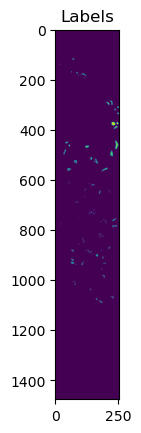

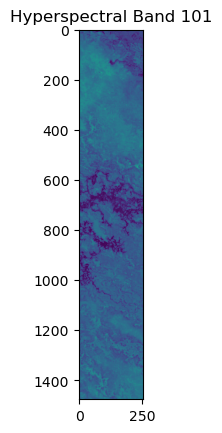

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(140, 5, 5, 145)
(70, 5, 5, 145)
(3038, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 140
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2215, PSNR: -10.0787


Epoch [1/50] Training Loss: 0.2134, PSNR: -8.6841
	[Val]   Batch [1/11] Loss: 0.2037, PSNR: -6.1270
	[Val]   Batch [10/11] Loss: 0.2039, PSNR: -8.3661
Epoch [1/50] Validation Loss: 0.2037, PSNR: -8.0581

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1984, PSNR: -7.9470


Epoch [2/50] Training Loss: 0.1917, PSNR: -8.2001
	[Val]   Batch [1/11] Loss: 0.1769, PSNR: -5.5138
	[Val]   Batch [10/11] Loss: 0.1774, PSNR: -7.7632
Epoch [2/50] Validation Loss: 0.1770, PSNR: -7.4480

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1773, PSNR: -9.8557


Epoch [3/50] Training Loss: 0.1707, PSNR: -7.7776
	[Val]   Batch [1/11] Loss: 0.1549, PSNR: -4.9371
	[Val]   Batch [10/11] Loss: 0.1552, PSNR: -7.1829
Epoch [3/50] Validation Loss: 0.1549, PSNR: -6.8693

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1565, PSNR: -7.9037


Epoch [4/50] Training Loss: 0.1506, PSNR: -7.3290
	[Val]   Batch [1/11] Loss: 0.1352, PSNR: -4.3482
	[Val]   Batch [10/11] Loss: 0.1355, PSNR: -6.5926
Epoch [4/50] Validation Loss: 0.1353, PSNR: -6.2799

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1378, PSNR: -8.9998


Epoch [5/50] Training Loss: 0.1316, PSNR: -6.6904
	[Val]   Batch [1/11] Loss: 0.1168, PSNR: -3.7129
	[Val]   Batch [10/11] Loss: 0.1170, PSNR: -5.9551
Epoch [5/50] Validation Loss: 0.1168, PSNR: -5.6414

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1195, PSNR: -8.0355


Epoch [6/50] Training Loss: 0.1140, PSNR: -6.2133
	[Val]   Batch [1/11] Loss: 0.1001, PSNR: -3.0401
	[Val]   Batch [10/11] Loss: 0.1002, PSNR: -5.2804
Epoch [6/50] Validation Loss: 0.1000, PSNR: -4.9681

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1035, PSNR: -5.6067


Epoch [7/50] Training Loss: 0.0984, PSNR: -5.4555
	[Val]   Batch [1/11] Loss: 0.0865, PSNR: -2.4049
	[Val]   Batch [10/11] Loss: 0.0865, PSNR: -4.6455
Epoch [7/50] Validation Loss: 0.0864, PSNR: -4.3328

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0883, PSNR: -2.4959


Epoch [8/50] Training Loss: 0.0849, PSNR: -4.6807
	[Val]   Batch [1/11] Loss: 0.0744, PSNR: -1.7547
	[Val]   Batch [10/11] Loss: 0.0745, PSNR: -3.9952
Epoch [8/50] Validation Loss: 0.0744, PSNR: -3.6847

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0776, PSNR: -4.9457


Epoch [9/50] Training Loss: 0.0732, PSNR: -4.1910
	[Val]   Batch [1/11] Loss: 0.0645, PSNR: -1.1316
	[Val]   Batch [10/11] Loss: 0.0645, PSNR: -3.3711
Epoch [9/50] Validation Loss: 0.0645, PSNR: -3.0618

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0670, PSNR: -5.9904


Epoch [10/50] Training Loss: 0.0634, PSNR: -3.5464
	[Val]   Batch [1/11] Loss: 0.0569, PSNR: -0.5902
	[Val]   Batch [10/11] Loss: 0.0570, PSNR: -2.8309
Epoch [10/50] Validation Loss: 0.0569, PSNR: -2.5209

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0584, PSNR: -3.5079


Epoch [11/50] Training Loss: 0.0551, PSNR: -3.0760
	[Val]   Batch [1/11] Loss: 0.0498, PSNR: -0.0103
	[Val]   Batch [10/11] Loss: 0.0499, PSNR: -2.2522
Epoch [11/50] Validation Loss: 0.0498, PSNR: -1.9417

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0504, PSNR: -1.9981


Epoch [12/50] Training Loss: 0.0483, PSNR: -2.5706
	[Val]   Batch [1/11] Loss: 0.0445, PSNR: 0.4825
	[Val]   Batch [10/11] Loss: 0.0445, PSNR: -1.7588
Epoch [12/50] Validation Loss: 0.0445, PSNR: -1.4501

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0447, PSNR: -1.4741


Epoch [13/50] Training Loss: 0.0425, PSNR: -1.7694
	[Val]   Batch [1/11] Loss: 0.0395, PSNR: 0.9953
	[Val]   Batch [10/11] Loss: 0.0396, PSNR: -1.2445
Epoch [13/50] Validation Loss: 0.0395, PSNR: -0.9359

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0387, PSNR: -2.3324


Epoch [14/50] Training Loss: 0.0377, PSNR: -1.4674
	[Val]   Batch [1/11] Loss: 0.0359, PSNR: 1.4168
	[Val]   Batch [10/11] Loss: 0.0359, PSNR: -0.8244
Epoch [14/50] Validation Loss: 0.0359, PSNR: -0.5150

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0349, PSNR: -1.8868


Epoch [15/50] Training Loss: 0.0337, PSNR: -0.8025
	[Val]   Batch [1/11] Loss: 0.0316, PSNR: 1.9688
	[Val]   Batch [10/11] Loss: 0.0316, PSNR: -0.2728
Epoch [15/50] Validation Loss: 0.0316, PSNR: 0.0367

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0313, PSNR: -1.4195


Epoch [16/50] Training Loss: 0.0302, PSNR: -0.3218
	[Val]   Batch [1/11] Loss: 0.0286, PSNR: 2.3947
	[Val]   Batch [10/11] Loss: 0.0287, PSNR: 0.1537
Epoch [16/50] Validation Loss: 0.0286, PSNR: 0.4626

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0281, PSNR: 2.4696


Epoch [17/50] Training Loss: 0.0273, PSNR: 0.1101
	[Val]   Batch [1/11] Loss: 0.0264, PSNR: 2.7394
	[Val]   Batch [10/11] Loss: 0.0265, PSNR: 0.4983
Epoch [17/50] Validation Loss: 0.0265, PSNR: 0.8062

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0253, PSNR: -1.5766


Epoch [18/50] Training Loss: 0.0248, PSNR: 0.3706
	[Val]   Batch [1/11] Loss: 0.0237, PSNR: 3.2138
	[Val]   Batch [10/11] Loss: 0.0237, PSNR: 0.9714
Epoch [18/50] Validation Loss: 0.0237, PSNR: 1.2816

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0234, PSNR: 0.2642


Epoch [19/50] Training Loss: 0.0226, PSNR: 1.1526
	[Val]   Batch [1/11] Loss: 0.0219, PSNR: 3.5665
	[Val]   Batch [10/11] Loss: 0.0219, PSNR: 1.3236
Epoch [19/50] Validation Loss: 0.0219, PSNR: 1.6333

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0212, PSNR: 2.1097


Epoch [20/50] Training Loss: 0.0207, PSNR: 1.4108
	[Val]   Batch [1/11] Loss: 0.0199, PSNR: 3.9820
	[Val]   Batch [10/11] Loss: 0.0199, PSNR: 1.7420
Epoch [20/50] Validation Loss: 0.0199, PSNR: 2.0496

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0198, PSNR: 0.2769


Epoch [21/50] Training Loss: 0.0190, PSNR: 1.6217
	[Val]   Batch [1/11] Loss: 0.0186, PSNR: 4.2689
	[Val]   Batch [10/11] Loss: 0.0186, PSNR: 2.0291
Epoch [21/50] Validation Loss: 0.0186, PSNR: 2.3371

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0174, PSNR: 4.5542


Epoch [22/50] Training Loss: 0.0176, PSNR: 2.0669
	[Val]   Batch [1/11] Loss: 0.0172, PSNR: 4.6053
	[Val]   Batch [10/11] Loss: 0.0172, PSNR: 2.3662
Epoch [22/50] Validation Loss: 0.0172, PSNR: 2.6740

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0165, PSNR: 2.8431


Epoch [23/50] Training Loss: 0.0163, PSNR: 2.3887
	[Val]   Batch [1/11] Loss: 0.0159, PSNR: 4.9456
	[Val]   Batch [10/11] Loss: 0.0159, PSNR: 2.7077
Epoch [23/50] Validation Loss: 0.0159, PSNR: 3.0163

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0152, PSNR: 3.2067


Epoch [24/50] Training Loss: 0.0151, PSNR: 2.5375
	[Val]   Batch [1/11] Loss: 0.0148, PSNR: 5.2511
	[Val]   Batch [10/11] Loss: 0.0148, PSNR: 3.0144
Epoch [24/50] Validation Loss: 0.0148, PSNR: 3.3233

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0145, PSNR: 1.9418


Epoch [25/50] Training Loss: 0.0141, PSNR: 3.1145
	[Val]   Batch [1/11] Loss: 0.0139, PSNR: 5.5352
	[Val]   Batch [10/11] Loss: 0.0139, PSNR: 3.3003
Epoch [25/50] Validation Loss: 0.0139, PSNR: 3.6075

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0136, PSNR: 2.2023


Epoch [26/50] Training Loss: 0.0132, PSNR: 3.1830
	[Val]   Batch [1/11] Loss: 0.0129, PSNR: 5.8550
	[Val]   Batch [10/11] Loss: 0.0129, PSNR: 3.6205
Epoch [26/50] Validation Loss: 0.0129, PSNR: 3.9276

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0131, PSNR: 1.8595


Epoch [27/50] Training Loss: 0.0124, PSNR: 3.6427
	[Val]   Batch [1/11] Loss: 0.0121, PSNR: 6.1235
	[Val]   Batch [10/11] Loss: 0.0121, PSNR: 3.8899
Epoch [27/50] Validation Loss: 0.0121, PSNR: 4.1969

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0118, PSNR: 6.2427


Epoch [28/50] Training Loss: 0.0116, PSNR: 3.7393
	[Val]   Batch [1/11] Loss: 0.0115, PSNR: 6.3727
	[Val]   Batch [10/11] Loss: 0.0114, PSNR: 4.1391
Epoch [28/50] Validation Loss: 0.0114, PSNR: 4.4456

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0111, PSNR: 6.5164


Epoch [29/50] Training Loss: 0.0109, PSNR: 3.9579
	[Val]   Batch [1/11] Loss: 0.0108, PSNR: 6.6368
	[Val]   Batch [10/11] Loss: 0.0108, PSNR: 4.4037
Epoch [29/50] Validation Loss: 0.0108, PSNR: 4.7104

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0110, PSNR: 5.2492


Epoch [30/50] Training Loss: 0.0103, PSNR: 4.3006
	[Val]   Batch [1/11] Loss: 0.0102, PSNR: 6.8953
	[Val]   Batch [10/11] Loss: 0.0102, PSNR: 4.6606
Epoch [30/50] Validation Loss: 0.0101, PSNR: 4.9686

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0098, PSNR: 4.2032


Epoch [31/50] Training Loss: 0.0097, PSNR: 4.7244
	[Val]   Batch [1/11] Loss: 0.0096, PSNR: 7.1422
	[Val]   Batch [10/11] Loss: 0.0096, PSNR: 4.9085
Epoch [31/50] Validation Loss: 0.0096, PSNR: 5.2153

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0090, PSNR: 4.4745


Epoch [32/50] Training Loss: 0.0092, PSNR: 4.8062
	[Val]   Batch [1/11] Loss: 0.0091, PSNR: 7.3843
	[Val]   Batch [10/11] Loss: 0.0091, PSNR: 5.1504
Epoch [32/50] Validation Loss: 0.0091, PSNR: 5.4573

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0088, PSNR: 3.0634


Epoch [33/50] Training Loss: 0.0087, PSNR: 5.1834
	[Val]   Batch [1/11] Loss: 0.0086, PSNR: 7.6358
	[Val]   Batch [10/11] Loss: 0.0086, PSNR: 5.4014
Epoch [33/50] Validation Loss: 0.0086, PSNR: 5.7089

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 4.2474


Epoch [34/50] Training Loss: 0.0082, PSNR: 5.4053
	[Val]   Batch [1/11] Loss: 0.0082, PSNR: 7.8429
	[Val]   Batch [10/11] Loss: 0.0082, PSNR: 5.6095
Epoch [34/50] Validation Loss: 0.0082, PSNR: 5.9161

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0078, PSNR: 5.6280


Epoch [35/50] Training Loss: 0.0078, PSNR: 5.4599
	[Val]   Batch [1/11] Loss: 0.0077, PSNR: 8.1048
	[Val]   Batch [10/11] Loss: 0.0077, PSNR: 5.8720
Epoch [35/50] Validation Loss: 0.0077, PSNR: 6.1788

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0075, PSNR: 4.6051


Epoch [36/50] Training Loss: 0.0074, PSNR: 5.7384
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3202
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.0871
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.3948

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0072, PSNR: 3.8851


Epoch [37/50] Training Loss: 0.0070, PSNR: 6.0425
	[Val]   Batch [1/11] Loss: 0.0070, PSNR: 8.4986
	[Val]   Batch [10/11] Loss: 0.0070, PSNR: 6.2656
Epoch [37/50] Validation Loss: 0.0070, PSNR: 6.5732

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0070, PSNR: 8.5289


Epoch [38/50] Training Loss: 0.0067, PSNR: 6.1714
	[Val]   Batch [1/11] Loss: 0.0067, PSNR: 8.7164
	[Val]   Batch [10/11] Loss: 0.0067, PSNR: 6.4833
Epoch [38/50] Validation Loss: 0.0067, PSNR: 6.7904

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0067, PSNR: 4.9979


Epoch [39/50] Training Loss: 0.0064, PSNR: 6.5146
	[Val]   Batch [1/11] Loss: 0.0064, PSNR: 8.9328
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.6999
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0063

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0065, PSNR: 5.9234


Epoch [40/50] Training Loss: 0.0061, PSNR: 6.6607
	[Val]   Batch [1/11] Loss: 0.0061, PSNR: 9.1176
	[Val]   Batch [10/11] Loss: 0.0061, PSNR: 6.8859
Epoch [40/50] Validation Loss: 0.0061, PSNR: 7.1921

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0060, PSNR: 9.2045


Epoch [41/50] Training Loss: 0.0058, PSNR: 6.6617
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3330
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.1015
Epoch [41/50] Validation Loss: 0.0058, PSNR: 7.4080

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 7.5555


Epoch [42/50] Training Loss: 0.0056, PSNR: 6.8918
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5278
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.2969
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6037

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0055, PSNR: 5.6511


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.2779
	[Val]   Batch [1/11] Loss: 0.0054, PSNR: 9.6668
	[Val]   Batch [10/11] Loss: 0.0054, PSNR: 7.4355
Epoch [43/50] Validation Loss: 0.0054, PSNR: 7.7428

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 7.9537


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.3629
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.8795
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6485
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9552

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0049, PSNR: 8.4379


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.8033
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0784
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8470
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.1542

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 8.1964


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.8155
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2570
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 8.0255
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.3333

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0047, PSNR: 8.6675


Epoch [47/50] Training Loss: 0.0045, PSNR: 8.0223
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.3965
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.1653
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.4731

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 10.4973


Epoch [48/50] Training Loss: 0.0044, PSNR: 8.1364
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.5840
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.3527
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.6608

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 9.0715


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.0737
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7600
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.5287
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.8375

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 8.6930


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.4644
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.8981
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.6672
Epoch [50/50] Validation Loss: 0.0040, PSNR: 8.9766


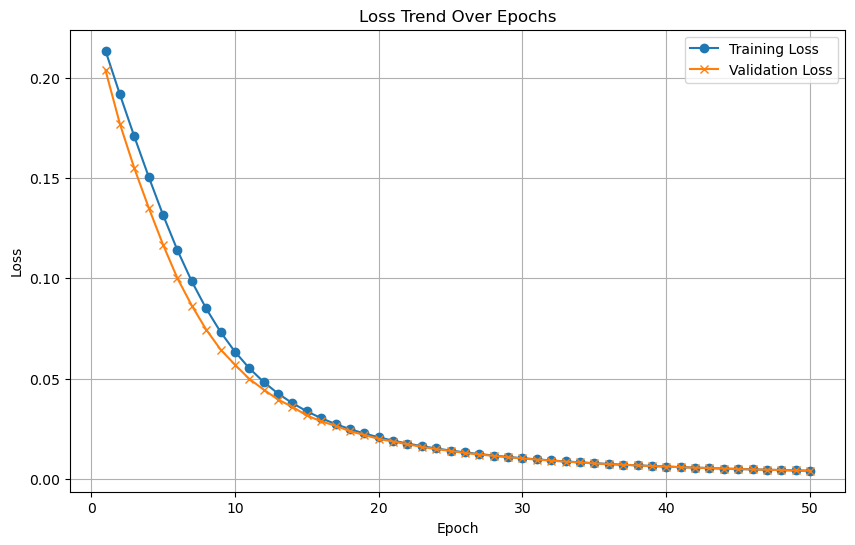

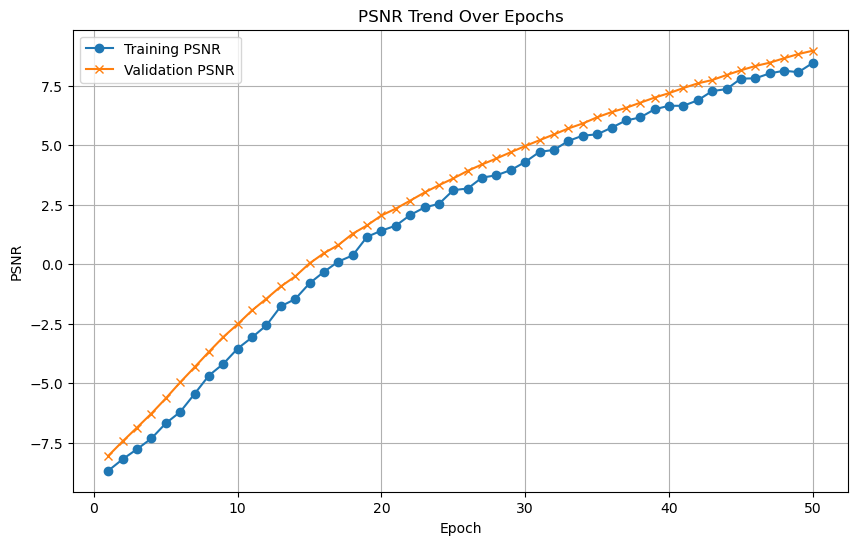

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6620
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6444. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6031
    Validation Batch [1/1], Loss: 2.6445
Validation Loss: 2.6445, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5831
    Validation Batch [1/1], Loss: 2.6445
Validation Loss: 2.6445, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5405
    Validation Batch [1/1], Loss: 2.6444
Validation Loss: 2.6444, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.5334
    Validati

Epoch [20/1000] completed, Average Training Loss: 2.3040
    Validation Batch [1/1], Loss: 2.6441
Validation Loss: 2.6441, Validation Accuracy: 7.14%
Validation loss improved from 2.6442 to 2.6441. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.2874
    Validation Batch [1/1], Loss: 2.6440
Validation Loss: 2.6440, Validation Accuracy: 7.14%
Validation loss improved from 2.6441 to 2.6440. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.2879
    Validation Batch [1/1], Loss: 2.6438
Validation Loss: 2.6438, Validation Accuracy: 7.14%
Validation loss improved from 2.6440 to 2.6438. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2478
    Validation Batch [1/1], Loss: 2.6437
Validation Loss: 2.6437, Validation Accuracy: 7.14%
Validation loss improved from 2.6438 to 2.6437. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/10

Epoch [29/1000] completed, Average Training Loss: 2.1783
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss improved from 2.6432 to 2.6428. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 2.1748
    Validation Batch [1/1], Loss: 2.6423
Validation Loss: 2.6423, Validation Accuracy: 7.14%
Validation loss improved from 2.6428 to 2.6423. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.1572
    Validation Batch [1/1], Loss: 2.6420
Validation Loss: 2.6420, Validation Accuracy: 7.14%
Validation loss improved from 2.6423 to 2.6420. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.1779
    Validation Batch [1/1], Loss: 2.6415
Validation Loss: 2.6415, Validation Accuracy: 7.14%
Validation loss improved from 2.6420 to 2.6415. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/10

    Validation Batch [1/1], Loss: 2.6128
Validation Loss: 2.6128, Validation Accuracy: 11.43%
Validation loss improved from 2.6162 to 2.6128. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.9159
    Validation Batch [1/1], Loss: 2.6090
Validation Loss: 2.6090, Validation Accuracy: 11.43%
Validation loss improved from 2.6128 to 2.6090. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 1.9333
    Validation Batch [1/1], Loss: 2.6049
Validation Loss: 2.6049, Validation Accuracy: 12.86%
Validation loss improved from 2.6090 to 2.6049. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 1.8839
    Validation Batch [1/1], Loss: 2.6015
Validation Loss: 2.6015, Validation Accuracy: 14.29%
Validation loss improved from 2.6049 to 2.6015. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 1.9196
    Vali

    Validation Batch [1/1], Loss: 2.5622
Validation Loss: 2.5622, Validation Accuracy: 27.14%
Validation loss improved from 2.5718 to 2.5622. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 1.8322
    Validation Batch [1/1], Loss: 2.5525
Validation Loss: 2.5525, Validation Accuracy: 27.14%
Validation loss improved from 2.5622 to 2.5525. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 1.8364
    Validation Batch [1/1], Loss: 2.5412
Validation Loss: 2.5412, Validation Accuracy: 27.14%
Validation loss improved from 2.5525 to 2.5412. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.7814
    Validation Batch [1/1], Loss: 2.5271
Validation Loss: 2.5271, Validation Accuracy: 27.14%
Validation loss improved from 2.5412 to 2.5271. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.7832
    Vali

Epoch [80/1000] completed, Average Training Loss: 1.6140
    Validation Batch [1/1], Loss: 2.1164
Validation Loss: 2.1164, Validation Accuracy: 67.14%
Validation loss improved from 2.1591 to 2.1164. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.5797
    Validation Batch [1/1], Loss: 2.0864
Validation Loss: 2.0864, Validation Accuracy: 67.14%
Validation loss improved from 2.1164 to 2.0864. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.5844
    Validation Batch [1/1], Loss: 2.0625
Validation Loss: 2.0625, Validation Accuracy: 70.00%
Validation loss improved from 2.0864 to 2.0625. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.5934
    Validation Batch [1/1], Loss: 2.0256
Validation Loss: 2.0256, Validation Accuracy: 72.86%
Validation loss improved from 2.0625 to 2.0256. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [8

Epoch [88/1000] completed, Average Training Loss: 1.5245
    Validation Batch [1/1], Loss: 1.8872
Validation Loss: 1.8872, Validation Accuracy: 78.57%
Validation loss improved from 1.9411 to 1.8872. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.5113
    Validation Batch [1/1], Loss: 1.8306
Validation Loss: 1.8306, Validation Accuracy: 81.43%
Validation loss improved from 1.8872 to 1.8306. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.4791
    Validation Batch [1/1], Loss: 1.8119
Validation Loss: 1.8119, Validation Accuracy: 81.43%
Validation loss improved from 1.8306 to 1.8119. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.5200
    Validation Batch [1/1], Loss: 1.8241
Validation Loss: 1.8241, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [92/1000] - Training
Epoch [92/1000] complet

    Validation Batch [1/1], Loss: 1.4887
Validation Loss: 1.4887, Validation Accuracy: 87.14%
Validation loss improved from 1.5062 to 1.4887. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.3614
    Validation Batch [1/1], Loss: 1.4781
Validation Loss: 1.4781, Validation Accuracy: 87.14%
Validation loss improved from 1.4887 to 1.4781. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.3532
    Validation Batch [1/1], Loss: 1.4755
Validation Loss: 1.4755, Validation Accuracy: 87.14%
Validation loss improved from 1.4781 to 1.4755. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.3547
    Validation Batch [1/1], Loss: 1.4649
Validation Loss: 1.4649, Validation Accuracy: 85.71%
Validation loss improved from 1.4755 to 1.4649. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.3305


Epoch [117/1000] completed, Average Training Loss: 1.2578
    Validation Batch [1/1], Loss: 1.3457
Validation Loss: 1.3457, Validation Accuracy: 84.29%
Validation loss improved from 1.3598 to 1.3457. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.2583
    Validation Batch [1/1], Loss: 1.3106
Validation Loss: 1.3106, Validation Accuracy: 87.14%
Validation loss improved from 1.3457 to 1.3106. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.2356
    Validation Batch [1/1], Loss: 1.3004
Validation Loss: 1.3004, Validation Accuracy: 88.57%
Validation loss improved from 1.3106 to 1.3004. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.2333
    Validation Batch [1/1], Loss: 1.3020
Validation Loss: 1.3020, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000

Epoch [135/1000] completed, Average Training Loss: 1.1142
    Validation Batch [1/1], Loss: 1.2076
Validation Loss: 1.2076, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 1.1138
    Validation Batch [1/1], Loss: 1.1949
Validation Loss: 1.1949, Validation Accuracy: 88.57%
Validation loss improved from 1.2046 to 1.1949. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 1.0958
    Validation Batch [1/1], Loss: 1.1596
Validation Loss: 1.1596, Validation Accuracy: 88.57%
Validation loss improved from 1.1949 to 1.1596. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.1018
    Validation Batch [1/1], Loss: 1.1684
Validation Loss: 1.1684, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Av

Epoch [146/1000] completed, Average Training Loss: 1.0181
    Validation Batch [1/1], Loss: 1.0950
Validation Loss: 1.0950, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.9993
    Validation Batch [1/1], Loss: 1.1066
Validation Loss: 1.1066, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.9930
    Validation Batch [1/1], Loss: 1.0860
Validation Loss: 1.0860, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 0.9903
    Validation Batch [1/1], Loss: 1.0416
Validation Loss: 1.0416, Validation Accuracy: 94.29%
Validation loss improved from 1.0762 to 1.0416. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training 

Epoch [164/1000] completed, Average Training Loss: 0.8706
    Validation Batch [1/1], Loss: 0.9547
Validation Loss: 0.9547, Validation Accuracy: 95.71%
Validation loss improved from 0.9547 to 0.9547. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 0.8839
    Validation Batch [1/1], Loss: 0.9644
Validation Loss: 0.9644, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 0.8971
    Validation Batch [1/1], Loss: 0.9597
Validation Loss: 0.9597, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.8807
    Validation Batch [1/1], Loss: 0.9414
Validation Loss: 0.9414, Validation Accuracy: 92.86%
Validation loss improved from 0.9547 to 0.9414. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Av

Epoch [174/1000] completed, Average Training Loss: 0.8411
    Validation Batch [1/1], Loss: 0.8804
Validation Loss: 0.8804, Validation Accuracy: 95.71%
Validation loss improved from 0.8982 to 0.8804. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.8529
    Validation Batch [1/1], Loss: 0.8753
Validation Loss: 0.8753, Validation Accuracy: 95.71%
Validation loss improved from 0.8804 to 0.8753. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.7978
    Validation Batch [1/1], Loss: 0.8852
Validation Loss: 0.8852, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.7730
    Validation Batch [1/1], Loss: 0.8716
Validation Loss: 0.8716, Validation Accuracy: 97.14%
Validation loss improved from 0.8753 to 0.8716. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000

Epoch [192/1000] completed, Average Training Loss: 0.6788
    Validation Batch [1/1], Loss: 0.7305
Validation Loss: 0.7305, Validation Accuracy: 98.57%
Validation loss improved from 0.7468 to 0.7305. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.7089
    Validation Batch [1/1], Loss: 0.7436
Validation Loss: 0.7436, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.7023
    Validation Batch [1/1], Loss: 0.7546
Validation Loss: 0.7546, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.6665
    Validation Batch [1/1], Loss: 0.7304
Validation Loss: 0.7304, Validation Accuracy: 97.14%
Validation loss improved from 0.7305 to 0.7304. Saving model...

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Av

    Validation Batch [1/1], Loss: 0.6839
Validation Loss: 0.6839, Validation Accuracy: 97.14%
Validation loss improved from 0.7031 to 0.6839. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.5673
    Validation Batch [1/1], Loss: 0.6877
Validation Loss: 0.6877, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.6457
    Validation Batch [1/1], Loss: 0.6913
Validation Loss: 0.6913, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.5905
    Validation Batch [1/1], Loss: 0.6862
Validation Loss: 0.6862, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.6123
    Validation Batch [1/1], Loss: 0.6695
Vali

Epoch [221/1000] completed, Average Training Loss: 0.5378
    Validation Batch [1/1], Loss: 0.5942
Validation Loss: 0.5942, Validation Accuracy: 97.14%
Validation loss improved from 0.6107 to 0.5942. Saving model...

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.5384
    Validation Batch [1/1], Loss: 0.5812
Validation Loss: 0.5812, Validation Accuracy: 97.14%
Validation loss improved from 0.5942 to 0.5812. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.5166
    Validation Batch [1/1], Loss: 0.5937
Validation Loss: 0.5937, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.5117
    Validation Batch [1/1], Loss: 0.6157
Validation Loss: 0.6157, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Av


LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.4819
    Validation Batch [1/1], Loss: 0.5588
Validation Loss: 0.5588, Validation Accuracy: 97.14%
Validation loss improved from 0.5668 to 0.5588. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.4463
    Validation Batch [1/1], Loss: 0.5460
Validation Loss: 0.5460, Validation Accuracy: 97.14%
Validation loss improved from 0.5588 to 0.5460. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.5007
    Validation Batch [1/1], Loss: 0.5387
Validation Loss: 0.5387, Validation Accuracy: 97.14%
Validation loss improved from 0.5460 to 0.5387. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.4640
    Validation Batch [1/1], Loss: 0.5449
Validation Loss: 0.5449, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [23

Epoch [250/1000] completed, Average Training Loss: 0.3947
    Validation Batch [1/1], Loss: 0.4612
Validation Loss: 0.4612, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.3965
    Validation Batch [1/1], Loss: 0.4716
Validation Loss: 0.4716, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.4000
    Validation Batch [1/1], Loss: 0.4689
Validation Loss: 0.4689, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.3885
    Validation Batch [1/1], Loss: 0.4974
Validation Loss: 0.4974, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.3955
  

    Validation Batch [1/1], Loss: 0.4794
Validation Loss: 0.4794, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.3930
    Validation Batch [1/1], Loss: 0.4526
Validation Loss: 0.4526, Validation Accuracy: 97.14%
Validation loss improved from 0.4589 to 0.4526. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.3633
    Validation Batch [1/1], Loss: 0.4314
Validation Loss: 0.4314, Validation Accuracy: 97.14%
Validation loss improved from 0.4526 to 0.4314. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.3865
    Validation Batch [1/1], Loss: 0.4388
Validation Loss: 0.4388, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.3354
    Validation Batch [1/1], Lo

Epoch [278/1000] completed, Average Training Loss: 0.3131
    Validation Batch [1/1], Loss: 0.3964
Validation Loss: 0.3964, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.3098
    Validation Batch [1/1], Loss: 0.3739
Validation Loss: 0.3739, Validation Accuracy: 97.14%
Validation loss improved from 0.3743 to 0.3739. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.3252
    Validation Batch [1/1], Loss: 0.3694
Validation Loss: 0.3694, Validation Accuracy: 98.57%
Validation loss improved from 0.3739 to 0.3694. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.3170
    Validation Batch [1/1], Loss: 0.3724
Validation Loss: 0.3724, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Av

Epoch [286/1000] completed, Average Training Loss: 0.2985
    Validation Batch [1/1], Loss: 0.3823
Validation Loss: 0.3823, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.3266
    Validation Batch [1/1], Loss: 0.3797
Validation Loss: 0.3797, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.2860
    Validation Batch [1/1], Loss: 0.3756
Validation Loss: 0.3756, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.2803
    Validation Batch [1/1], Loss: 0.3776
Validation Loss: 0.3776, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.2839
  

Epoch [308/1000] completed, Average Training Loss: 0.2431
    Validation Batch [1/1], Loss: 0.3055
Validation Loss: 0.3055, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.2542
    Validation Batch [1/1], Loss: 0.3091
Validation Loss: 0.3091, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.2936
    Validation Batch [1/1], Loss: 0.3303
Validation Loss: 0.3303, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.2453
    Validation Batch [1/1], Loss: 0.3486
Validation Loss: 0.3486, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.2557
  

    Validation Batch [1/1], Loss: 0.3144
Validation Loss: 0.3144, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.2368
    Validation Batch [1/1], Loss: 0.3250
Validation Loss: 0.3250, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.2138
    Validation Batch [1/1], Loss: 0.3100
Validation Loss: 0.3100, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.2340
    Validation Batch [1/1], Loss: 0.2933
Validation Loss: 0.2933, Validation Accuracy: 95.71%
Validation loss improved from 0.3025 to 0.2933. Saving model...

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.2408
    Validation Batch [1/1], Loss: 0.2869
Vali

    Validation Batch [1/1], Loss: 0.2673
Validation Loss: 0.2673, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.2101
    Validation Batch [1/1], Loss: 0.2630
Validation Loss: 0.2630, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.2053
    Validation Batch [1/1], Loss: 0.2617
Validation Loss: 0.2617, Validation Accuracy: 97.14%
Validation loss improved from 0.2628 to 0.2617. Saving model...

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.2006
    Validation Batch [1/1], Loss: 0.2708
Validation Loss: 0.2708, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.1992
    Validation Batch [1/1], Loss: 0.2832
Vali

Epoch [342/1000] completed, Average Training Loss: 0.1713
    Validation Batch [1/1], Loss: 0.2735
Validation Loss: 0.2735, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.1817
    Validation Batch [1/1], Loss: 0.2914
Validation Loss: 0.2914, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.1938
    Validation Batch [1/1], Loss: 0.2683
Validation Loss: 0.2683, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2028
    Validation Batch [1/1], Loss: 0.2499
Validation Loss: 0.2499, Validation Accuracy: 97.14%
Validation loss improved from 0.2611 to 0.2499. Saving model...

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2416
Validation Loss: 0.2416, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.1958
    Validation Batch [1/1], Loss: 0.2434
Validation Loss: 0.2434, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1892
    Validation Batch [1/1], Loss: 0.2398
Validation Loss: 0.2398, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1546
    Validation Batch [1/1], Loss: 0.2430
Validation Loss: 0.2430, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.1825
    Validation Batch [1/1], Loss: 0.2553
Validation Loss

Epoch [370/1000] completed, Average Training Loss: 0.1477
    Validation Batch [1/1], Loss: 0.2156
Validation Loss: 0.2156, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.1668
    Validation Batch [1/1], Loss: 0.2265
Validation Loss: 0.2265, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.1656
    Validation Batch [1/1], Loss: 0.2491
Validation Loss: 0.2491, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.1609
    Validation Batch [1/1], Loss: 0.2525
Validation Loss: 0.2525, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.1757
  

    Validation Batch [1/1], Loss: 0.2085
Validation Loss: 0.2085, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.1516
    Validation Batch [1/1], Loss: 0.2161
Validation Loss: 0.2161, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.1398
    Validation Batch [1/1], Loss: 0.2131
Validation Loss: 0.2131, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1335
    Validation Batch [1/1], Loss: 0.1947
Validation Loss: 0.1947, Validation Accuracy: 95.71%
Validation loss improved from 0.1956 to 0.1947. Saving model...

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1574
    Validation Batch [1/1], Loss: 0.1919
Vali

Epoch [401/1000] completed, Average Training Loss: 0.1416
    Validation Batch [1/1], Loss: 0.2038
Validation Loss: 0.2038, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.1351
    Validation Batch [1/1], Loss: 0.2054
Validation Loss: 0.2054, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.1259
    Validation Batch [1/1], Loss: 0.2057
Validation Loss: 0.2057, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.1159
    Validation Batch [1/1], Loss: 0.2107
Validation Loss: 0.2107, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.1427
  

    Validation Batch [1/1], Loss: 0.1861
Validation Loss: 0.1861, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1284
    Validation Batch [1/1], Loss: 0.1852
Validation Loss: 0.1852, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1220
    Validation Batch [1/1], Loss: 0.1820
Validation Loss: 0.1820, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1131
    Validation Batch [1/1], Loss: 0.1877
Validation Loss: 0.1877, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.1099
    Validation Batch [1/1], Loss: 0.1945
Validation Loss: 0.

Epoch [429/1000] completed, Average Training Loss: 0.1128
    Validation Batch [1/1], Loss: 0.1999
Validation Loss: 0.1999, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.1214
    Validation Batch [1/1], Loss: 0.2104
Validation Loss: 0.2104, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1077
    Validation Batch [1/1], Loss: 0.2100
Validation Loss: 0.2100, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1202
    Validation Batch [1/1], Loss: 0.1995
Validation Loss: 0.1995, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.095

Epoch [452/1000] completed, Average Training Loss: 0.0932
    Validation Batch [1/1], Loss: 0.1678
Validation Loss: 0.1678, Validation Accuracy: 97.14%
Validation loss improved from 0.1696 to 0.1678. Saving model...

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0909
    Validation Batch [1/1], Loss: 0.1693
Validation Loss: 0.1693, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1045
    Validation Batch [1/1], Loss: 0.1728
Validation Loss: 0.1728, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.0936
    Validation Batch [1/1], Loss: 0.1983
Validation Loss: 0.1983, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training 

Epoch [457/1000] completed, Average Training Loss: 0.1114
    Validation Batch [1/1], Loss: 0.1978
Validation Loss: 0.1978, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0913
    Validation Batch [1/1], Loss: 0.1908
Validation Loss: 0.1908, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0954
    Validation Batch [1/1], Loss: 0.1923
Validation Loss: 0.1923, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0974
    Validation Batch [1/1], Loss: 0.1840
Validation Loss: 0.1840, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0999
  

Epoch [481/1000] completed, Average Training Loss: 0.0832


    Validation Batch [1/1], Loss: 0.1609
Validation Loss: 0.1609, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0758
    Validation Batch [1/1], Loss: 0.1587
Validation Loss: 0.1587, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 0.1604
Validation Loss: 0.1604, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0861
    Validation Batch [1/1], Loss: 0.1625
Validation Loss: 0.1625, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0848
    Validation Batch [1/1], Loss: 0.1667
Validation Loss: 

Epoch [510/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.1581
Validation Loss: 0.1581, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0704
    Validation Batch [1/1], Loss: 0.1900
Validation Loss: 0.1900, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.0817
    Validation Batch [1/1], Loss: 0.1894
Validation Loss: 0.1894, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0745
    Validation Batch [1/1], Loss: 0.1700
Validation Loss: 0.1700, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.069

Epoch [540/1000] completed, Average Training Loss: 0.0858
    Validation Batch [1/1], Loss: 0.1729
Validation Loss: 0.1729, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.0725
    Validation Batch [1/1], Loss: 0.1678
Validation Loss: 0.1678, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [542/1000] - Training
Epoch [542/1000] completed, Average Training Loss: 0.0678
    Validation Batch [1/1], Loss: 0.1638
Validation Loss: 0.1638, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.1595
Validation Loss: 0.1595, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0571
  

Epoch [570/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.1326
Validation Loss: 0.1326, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0453
    Validation Batch [1/1], Loss: 0.1240
Validation Loss: 0.1240, Validation Accuracy: 98.57%
Validation loss improved from 0.1298 to 0.1240. Saving model...

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0733
    Validation Batch [1/1], Loss: 0.1295
Validation Loss: 0.1295, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0538
    Validation Batch [1/1], Loss: 0.1437
Validation Loss: 0.1437, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.1388
Validation Loss: 0.1388, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0573
    Validation Batch [1/1], Loss: 0.1197
Validation Loss: 0.1197, Validation Accuracy: 97.14%
Validation loss improved from 0.1240 to 0.1197. Saving model...

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.1170
Validation Loss: 0.1170, Validation Accuracy: 95.71%
Validation loss improved from 0.1197 to 0.1170. Saving model...

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0579
    Validation Batch [1/1], Loss: 0.1372
Validation Loss: 0.1372, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0511
    Validation Batch [1/1], L

Epoch [627/1000] completed, Average Training Loss: 0.0584
    Validation Batch [1/1], Loss: 0.1425
Validation Loss: 0.1425, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.1337
Validation Loss: 0.1337, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.1273
Validation Loss: 0.1273, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.0490
    Validation Batch [1/1], Loss: 0.1265
Validation Loss: 0.1265, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [631/1000] - Training
Epoch [631/1000] completed, Average Training Loss: 0.058

Epoch [655/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.1367
Validation Loss: 0.1367, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.1206
Validation Loss: 0.1206, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.1128
Validation Loss: 0.1128, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0362
    Validation Batch [1/1], Loss: 0.1113
Validation Loss: 0.1113, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.0554
  

Epoch [682/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.1108
Validation Loss: 0.1108, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.1098
Validation Loss: 0.1098, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0358
    Validation Batch [1/1], Loss: 0.1127
Validation Loss: 0.1127, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.0373
    Validation Batch [1/1], Loss: 0.1132
Validation Loss: 0.1132, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [686/1000] - Training
Epoch [686/1000] completed, Average Training Loss: 0.029

Epoch [711/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.1107
Validation Loss: 0.1107, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [712/1000] - Training
Epoch [712/1000] completed, Average Training Loss: 0.0373
    Validation Batch [1/1], Loss: 0.1137
Validation Loss: 0.1137, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.1221
Validation Loss: 0.1221, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.1236
Validation Loss: 0.1236, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.037

Epoch [740/1000] completed, Average Training Loss: 0.0362
    Validation Batch [1/1], Loss: 0.1163
Validation Loss: 0.1163, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [741/1000] - Training
Epoch [741/1000] completed, Average Training Loss: 0.0290
    Validation Batch [1/1], Loss: 0.1085
Validation Loss: 0.1085, Validation Accuracy: 97.14%
Validation loss improved from 0.1089 to 0.1085. Saving model...

LOG: Epoch [742/1000] - Training
Epoch [742/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.1073
Validation Loss: 0.1073, Validation Accuracy: 97.14%
Validation loss improved from 0.1085 to 0.1073. Saving model...

LOG: Epoch [743/1000] - Training
Epoch [743/1000] completed, Average Training Loss: 0.0338
    Validation Batch [1/1], Loss: 0.1048
Validation Loss: 0.1048, Validation Accuracy: 97.14%
Validation loss improved from 0.1073 to 0.1048. Saving model...

LOG: Epoch [744/1000] - Training
Epoch [744/100

Epoch [770/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.1162
Validation Loss: 0.1162, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [771/1000] - Training
Epoch [771/1000] completed, Average Training Loss: 0.0228
    Validation Batch [1/1], Loss: 0.1115
Validation Loss: 0.1115, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [772/1000] - Training
Epoch [772/1000] completed, Average Training Loss: 0.0332
    Validation Batch [1/1], Loss: 0.1216
Validation Loss: 0.1216, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [773/1000] - Training
Epoch [773/1000] completed, Average Training Loss: 0.0310
    Validation Batch [1/1], Loss: 0.1372
Validation Loss: 0.1372, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [774/1000] - Training
Epoch [774/1000] completed, Average Training Loss: 0.029

Epoch [799/1000] completed, Average Training Loss: 0.0343
    Validation Batch [1/1], Loss: 0.1152
Validation Loss: 0.1152, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [800/1000] - Training
Epoch [800/1000] completed, Average Training Loss: 0.0275
    Validation Batch [1/1], Loss: 0.1021
Validation Loss: 0.1021, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [801/1000] - Training
Epoch [801/1000] completed, Average Training Loss: 0.0345
    Validation Batch [1/1], Loss: 0.0990
Validation Loss: 0.0990, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [802/1000] - Training
Epoch [802/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.1063
Validation Loss: 0.1063, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [803/1000] - Training
Epoch [803/1000] completed, Average Training Loss: 0.0299
  

Epoch [829/1000] completed, Average Training Loss: 0.0299
    Validation Batch [1/1], Loss: 0.1146
Validation Loss: 0.1146, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [830/1000] - Training
Epoch [830/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.1175
Validation Loss: 0.1175, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [831/1000] - Training
Epoch [831/1000] completed, Average Training Loss: 0.0246
    Validation Batch [1/1], Loss: 0.1172
Validation Loss: 0.1172, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [832/1000] - Training
Epoch [832/1000] completed, Average Training Loss: 0.0179
    Validation Batch [1/1], Loss: 0.1198
Validation Loss: 0.1198, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [833/1000] - Training
Epoch [833/1000] completed, Average Training Loss: 0.024

Epoch [859/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.1200
Validation Loss: 0.1200, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [860/1000] - Training
Epoch [860/1000] completed, Average Training Loss: 0.0271
    Validation Batch [1/1], Loss: 0.1166
Validation Loss: 0.1166, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [861/1000] - Training
Epoch [861/1000] completed, Average Training Loss: 0.0257
    Validation Batch [1/1], Loss: 0.0997
Validation Loss: 0.0997, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [862/1000] - Training
Epoch [862/1000] completed, Average Training Loss: 0.0280
    Validation Batch [1/1], Loss: 0.0992
Validation Loss: 0.0992, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [863/1000] - Training
Epoch [863/1000] completed, Average Training Loss: 0.024

Epoch [888/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.1099
Validation Loss: 0.1099, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [889/1000] - Training
Epoch [889/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.1384
Validation Loss: 0.1384, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [890/1000] - Training
Epoch [890/1000] completed, Average Training Loss: 0.0229
    Validation Batch [1/1], Loss: 0.1618
Validation Loss: 0.1618, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [891/1000] - Training
Epoch [891/1000] completed, Average Training Loss: 0.0212
    Validation Batch [1/1], Loss: 0.1641
Validation Loss: 0.1641, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [892/1000] - Training
Epoch [892/1000] completed, Average Training Loss: 0.0254
  

Epoch [916/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.0939
Validation Loss: 0.0939, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [917/1000] - Training
Epoch [917/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.0875
Validation Loss: 0.0875, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [918/1000] - Training
Epoch [918/1000] completed, Average Training Loss: 0.0197
    Validation Batch [1/1], Loss: 0.0845
Validation Loss: 0.0845, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [919/1000] - Training
Epoch [919/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.0832
Validation Loss: 0.0832, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [920/1000] - Training
Epoch [920/1000] completed, Average Training Loss: 0.022

Epoch [947/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.1088
Validation Loss: 0.1088, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [948/1000] - Training
Epoch [948/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.1044
Validation Loss: 0.1044, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [949/1000] - Training
Epoch [949/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.1011
Validation Loss: 0.1011, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [950/1000] - Training
Epoch [950/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.0986
Validation Loss: 0.0986, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [951/1000] - Training
Epoch [951/1000] completed, Average Training Loss: 0.018

Epoch [977/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.1166
Validation Loss: 0.1166, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [978/1000] - Training
Epoch [978/1000] completed, Average Training Loss: 0.0217
    Validation Batch [1/1], Loss: 0.1409
Validation Loss: 0.1409, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [979/1000] - Training
Epoch [979/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.1601
Validation Loss: 0.1601, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [980/1000] - Training
Epoch [980/1000] completed, Average Training Loss: 0.0150
    Validation Batch [1/1], Loss: 0.1762
Validation Loss: 0.1762, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [981/1000] - Training
Epoch [981/1000] completed, Average Training Loss: 0.023

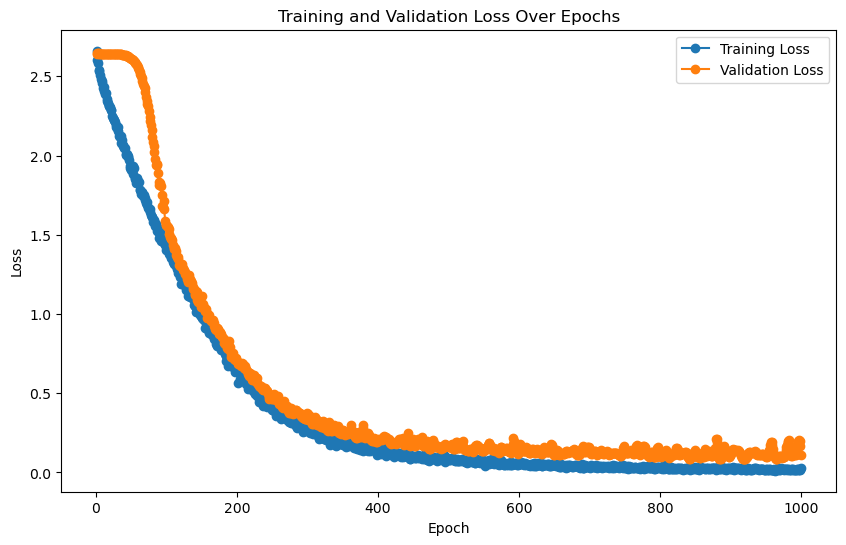

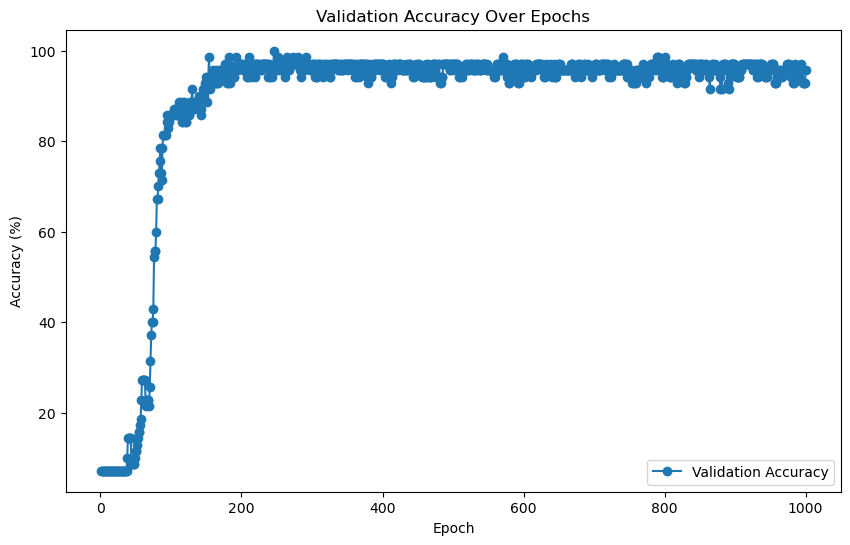


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0640

Final Test Loss: 0.1491, Test Accuracy: 95.16%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)

LOG: Training features shape: (140, 64), Training labels shape: (140,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3038, 64), Test labels shape: (3038,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 64.29%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)
Train reps shape: (140, 64)
Train labels shape: (140,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3038, 64)
Test labels shape: (3038,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7308  |  Val Loss: 2.6720
Validation loss improved from inf to 2.6720.
[Epoch 2/1000] Train Loss: 2.6706  |  Val Loss: 2.6465
Validation loss improved from 2.6720 to 2.6465.
[Epoch 3/1000] Train Loss: 2.6449  |  Val Loss: 2.6355
Validation loss improved from 2.6465 to 2.6355.
[Epoch 4/1000] Train Loss: 2.6365  |  Val Loss: 2.6328
Validation loss improved from 2.6355 to 2.6328.
[Epoch 5/1000] Train Loss: 2.6338  |  Val Loss: 2.6307
Validation loss improved from 2.6328 to 2.6307.
[Epoch 6/1000] Train Loss: 2.6307  |  Val Loss: 2.6255
Validation loss improved from 2.6307 to 2.6255.
[Epoch 7/1000] Train Loss: 2.6244  |  Val Loss: 2.6199
Validation loss improved from 2.6255 to 2.6199.
[Epoch 8/1000] Train Loss: 2.6172  |  Val Loss: 2.6135
Validation loss improved from 2.6199 to 2.6135.
[Epoch 9/1000] Train Loss: 2.6137  |  Val Loss: 2.6174
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 10/1000] Train Loss: 2.6164  |  Val Loss: 2.6153
!! Validation 

[Epoch 23/1000] Train Loss: 2.5615  |  Val Loss: 2.5535
Validation loss improved from 2.5589 to 2.5535.
[Epoch 24/1000] Train Loss: 2.5533  |  Val Loss: 2.5464
Validation loss improved from 2.5535 to 2.5464.
[Epoch 25/1000] Train Loss: 2.5457  |  Val Loss: 2.5406
Validation loss improved from 2.5464 to 2.5406.
[Epoch 26/1000] Train Loss: 2.5421  |  Val Loss: 2.5342
Validation loss improved from 2.5406 to 2.5342.
[Epoch 27/1000] Train Loss: 2.5339  |  Val Loss: 2.5254
Validation loss improved from 2.5342 to 2.5254.
[Epoch 28/1000] Train Loss: 2.5256  |  Val Loss: 2.5165
Validation loss improved from 2.5254 to 2.5165.
[Epoch 29/1000] Train Loss: 2.5158  |  Val Loss: 2.5082
Validation loss improved from 2.5165 to 2.5082.
[Epoch 30/1000] Train Loss: 2.5081  |  Val Loss: 2.5013
Validation loss improved from 2.5082 to 2.5013.
[Epoch 31/1000] Train Loss: 2.5007  |  Val Loss: 2.5010
Validation loss improved from 2.5013 to 2.5010.


[Epoch 32/1000] Train Loss: 2.5050  |  Val Loss: 2.4969
Validation loss improved from 2.5010 to 2.4969.
[Epoch 33/1000] Train Loss: 2.4979  |  Val Loss: 2.4837
Validation loss improved from 2.4969 to 2.4837.
[Epoch 34/1000] Train Loss: 2.4855  |  Val Loss: 2.4799
Validation loss improved from 2.4837 to 2.4799.
[Epoch 35/1000] Train Loss: 2.4822  |  Val Loss: 2.4708
Validation loss improved from 2.4799 to 2.4708.
[Epoch 36/1000] Train Loss: 2.4699  |  Val Loss: 2.4574
Validation loss improved from 2.4708 to 2.4574.
[Epoch 37/1000] Train Loss: 2.4561  |  Val Loss: 2.4483
Validation loss improved from 2.4574 to 2.4483.
[Epoch 38/1000] Train Loss: 2.4478  |  Val Loss: 2.4373
Validation loss improved from 2.4483 to 2.4373.
[Epoch 39/1000] Train Loss: 2.4360  |  Val Loss: 2.4227
Validation loss improved from 2.4373 to 2.4227.
[Epoch 40/1000] Train Loss: 2.4236  |  Val Loss: 2.4102
Validation loss improved from 2.4227 to 2.4102.
[Epoch 41/1000] Train Loss: 2.4149  |  Val Loss: 2.4047
Validati

[Epoch 53/1000] Train Loss: 2.3039  |  Val Loss: 2.2914
Validation loss improved from 2.3018 to 2.2914.
[Epoch 54/1000] Train Loss: 2.2965  |  Val Loss: 2.2898
Validation loss improved from 2.2914 to 2.2898.
[Epoch 55/1000] Train Loss: 2.2911  |  Val Loss: 2.2668
Validation loss improved from 2.2898 to 2.2668.
[Epoch 56/1000] Train Loss: 2.2717  |  Val Loss: 2.2593
Validation loss improved from 2.2668 to 2.2593.
[Epoch 57/1000] Train Loss: 2.2602  |  Val Loss: 2.2474
Validation loss improved from 2.2593 to 2.2474.
[Epoch 58/1000] Train Loss: 2.2482  |  Val Loss: 2.2360
Validation loss improved from 2.2474 to 2.2360.
[Epoch 59/1000] Train Loss: 2.2361  |  Val Loss: 2.2224
Validation loss improved from 2.2360 to 2.2224.


[Epoch 60/1000] Train Loss: 2.2196  |  Val Loss: 2.2127
Validation loss improved from 2.2224 to 2.2127.
[Epoch 61/1000] Train Loss: 2.2189  |  Val Loss: 2.1977
Validation loss improved from 2.2127 to 2.1977.
[Epoch 62/1000] Train Loss: 2.1976  |  Val Loss: 2.1970
Validation loss improved from 2.1977 to 2.1970.
[Epoch 63/1000] Train Loss: 2.1976  |  Val Loss: 2.1720
Validation loss improved from 2.1970 to 2.1720.
[Epoch 64/1000] Train Loss: 2.1721  |  Val Loss: 2.1553
Validation loss improved from 2.1720 to 2.1553.
[Epoch 65/1000] Train Loss: 2.1537  |  Val Loss: 2.1343
Validation loss improved from 2.1553 to 2.1343.
[Epoch 66/1000] Train Loss: 2.1342  |  Val Loss: 2.1157
Validation loss improved from 2.1343 to 2.1157.
[Epoch 67/1000] Train Loss: 2.1165  |  Val Loss: 2.1076
Validation loss improved from 2.1157 to 2.1076.
[Epoch 68/1000] Train Loss: 2.1027  |  Val Loss: 2.0998
Validation loss improved from 2.1076 to 2.0998.
[Epoch 69/1000] Train Loss: 2.1045  |  Val Loss: 2.0733
Validati

[Epoch 78/1000] Train Loss: 1.9513  |  Val Loss: 1.9526
Validation loss improved from 1.9717 to 1.9526.
[Epoch 79/1000] Train Loss: 1.9534  |  Val Loss: 1.9113
Validation loss improved from 1.9526 to 1.9113.
[Epoch 80/1000] Train Loss: 1.9133  |  Val Loss: 1.9078
Validation loss improved from 1.9113 to 1.9078.
[Epoch 81/1000] Train Loss: 1.8979  |  Val Loss: 1.9016
Validation loss improved from 1.9078 to 1.9016.
[Epoch 82/1000] Train Loss: 1.9035  |  Val Loss: 1.8723
Validation loss improved from 1.9016 to 1.8723.
[Epoch 83/1000] Train Loss: 1.8731  |  Val Loss: 1.8603
Validation loss improved from 1.8723 to 1.8603.
[Epoch 84/1000] Train Loss: 1.8549  |  Val Loss: 1.8448
Validation loss improved from 1.8603 to 1.8448.
[Epoch 85/1000] Train Loss: 1.8443  |  Val Loss: 1.8423
Validation loss improved from 1.8448 to 1.8423.
[Epoch 86/1000] Train Loss: 1.8374  |  Val Loss: 1.8115
Validation loss improved from 1.8423 to 1.8115.
[Epoch 87/1000] Train Loss: 1.8105  |  Val Loss: 1.7946
Validati

[Epoch 88/1000] Train Loss: 1.7944  |  Val Loss: 1.7817
Validation loss improved from 1.7946 to 1.7817.
[Epoch 89/1000] Train Loss: 1.7795  |  Val Loss: 1.7655
Validation loss improved from 1.7817 to 1.7655.
[Epoch 90/1000] Train Loss: 1.7646  |  Val Loss: 1.7498
Validation loss improved from 1.7655 to 1.7498.
[Epoch 91/1000] Train Loss: 1.7502  |  Val Loss: 1.7360
Validation loss improved from 1.7498 to 1.7360.
[Epoch 92/1000] Train Loss: 1.7411  |  Val Loss: 1.7322
Validation loss improved from 1.7360 to 1.7322.
[Epoch 93/1000] Train Loss: 1.7373  |  Val Loss: 1.7224
Validation loss improved from 1.7322 to 1.7224.
[Epoch 94/1000] Train Loss: 1.7180  |  Val Loss: 1.7127
Validation loss improved from 1.7224 to 1.7127.
[Epoch 95/1000] Train Loss: 1.6929  |  Val Loss: 1.7137
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 96/1000] Train Loss: 1.7045  |  Val Loss: 1.7096
Validation loss improved from 1.7127 to 1.7096.
[Epoch 97/1000] Train Loss: 1.7056  |  Val Loss: 1.6857
Va

[Epoch 104/1000] Train Loss: 1.6202  |  Val Loss: 1.6981
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 105/1000] Train Loss: 1.6529  |  Val Loss: 1.6249
Validation loss improved from 1.6350 to 1.6249.
[Epoch 106/1000] Train Loss: 1.6435  |  Val Loss: 1.6000
Validation loss improved from 1.6249 to 1.6000.
[Epoch 107/1000] Train Loss: 1.6069  |  Val Loss: 1.6045
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 108/1000] Train Loss: 1.5947  |  Val Loss: 1.5940
Validation loss improved from 1.6000 to 1.5940.
[Epoch 109/1000] Train Loss: 1.5837  |  Val Loss: 1.5804
Validation loss improved from 1.5940 to 1.5804.
[Epoch 110/1000] Train Loss: 1.5627  |  Val Loss: 1.5653
Validation loss improved from 1.5804 to 1.5653.
[Epoch 111/1000] Train Loss: 1.5702  |  Val Loss: 1.5512
Validation loss improved from 1.5653 to 1.5512.
[Epoch 112/1000] Train Loss: 1.5478  |  Val Loss: 1.5486
Validation loss improved from 1.5512 to 1.5486.
[Epoch 113/1000] Train Loss: 1.5419  |  Val

[Epoch 115/1000] Train Loss: 1.5315  |  Val Loss: 1.5223
Validation loss improved from 1.5390 to 1.5223.
[Epoch 116/1000] Train Loss: 1.5168  |  Val Loss: 1.5464
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 1.5338  |  Val Loss: 1.5415
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 118/1000] Train Loss: 1.5343  |  Val Loss: 1.5137
Validation loss improved from 1.5223 to 1.5137.
[Epoch 119/1000] Train Loss: 1.5021  |  Val Loss: 1.5035
Validation loss improved from 1.5137 to 1.5035.
[Epoch 120/1000] Train Loss: 1.4920  |  Val Loss: 1.4984
Validation loss improved from 1.5035 to 1.4984.
[Epoch 121/1000] Train Loss: 1.4924  |  Val Loss: 1.4989
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 1.4866  |  Val Loss: 1.4986
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 123/1000] Train Loss: 1.4824  |  Val Loss: 1.4742
Validation loss improved from 1.4984 to 1.4742.
[Epoch 124/1000] Train Loss: 1.

[Epoch 130/1000] Train Loss: 1.4610  |  Val Loss: 1.4575
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 1.4493  |  Val Loss: 1.4460
Validation loss improved from 1.4567 to 1.4460.
[Epoch 132/1000] Train Loss: 1.4334  |  Val Loss: 1.4997
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 133/1000] Train Loss: 1.4618  |  Val Loss: 1.4391
Validation loss improved from 1.4460 to 1.4391.
[Epoch 134/1000] Train Loss: 1.4262  |  Val Loss: 1.4543
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 1.4344  |  Val Loss: 1.4528
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 136/1000] Train Loss: 1.4294  |  Val Loss: 1.4377
Validation loss improved from 1.4391 to 1.4377.
[Epoch 137/1000] Train Loss: 1.4331  |  Val Loss: 1.4344
Validation loss improved from 1.4377 to 1.4344.
[Epoch 138/1000] Train Loss: 1.4210  |  Val Loss: 1.4406
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 139/1000] Train Lo

[Epoch 140/1000] Train Loss: 1.4726  |  Val Loss: 1.4443
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 141/1000] Train Loss: 1.4235  |  Val Loss: 1.4446
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 142/1000] Train Loss: 1.4212  |  Val Loss: 1.4499
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 143/1000] Train Loss: 1.4129  |  Val Loss: 1.4371
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 144/1000] Train Loss: 1.4298  |  Val Loss: 1.4595
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 145/1000] Train Loss: 1.4359  |  Val Loss: 1.4291
Validation loss improved from 1.4344 to 1.4291.
[Epoch 146/1000] Train Loss: 1.3946  |  Val Loss: 1.4298
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 147/1000] Train Loss: 1.4073  |  Val Loss: 1.4295
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 148/1000] Train Loss: 1.3936  |  Val Loss: 1.4239
Validation loss improved from 1.4291 to 1.4239.
[Epoch 149/10

[Epoch 153/1000] Train Loss: 1.3945  |  Val Loss: 1.3930
Validation loss improved from 1.4181 to 1.3930.
[Epoch 154/1000] Train Loss: 1.4036  |  Val Loss: 1.3988
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 1.3895  |  Val Loss: 1.3911
Validation loss improved from 1.3930 to 1.3911.
[Epoch 156/1000] Train Loss: 1.3604  |  Val Loss: 1.3999
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.3768  |  Val Loss: 1.4020
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 1.3637  |  Val Loss: 1.3723
Validation loss improved from 1.3911 to 1.3723.
[Epoch 159/1000] Train Loss: 1.3573  |  Val Loss: 1.3815
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 160/1000] Train Loss: 1.3695  |  Val Loss: 1.3848
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 161/1000] Train Loss: 1.3918  |  Val Loss: 1.3772
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 162/1000] Tr

[Epoch 164/1000] Train Loss: 1.3582  |  Val Loss: 1.3854
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 165/1000] Train Loss: 1.3652  |  Val Loss: 1.3694
Validation loss improved from 1.3723 to 1.3694.
[Epoch 166/1000] Train Loss: 1.3337  |  Val Loss: 1.4282
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 1.3644  |  Val Loss: 1.3603
Validation loss improved from 1.3694 to 1.3603.
[Epoch 168/1000] Train Loss: 1.3449  |  Val Loss: 1.3738
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 169/1000] Train Loss: 1.3827  |  Val Loss: 1.3606
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 170/1000] Train Loss: 1.3434  |  Val Loss: 1.3536
Validation loss improved from 1.3603 to 1.3536.
[Epoch 171/1000] Train Loss: 1.3355  |  Val Loss: 1.4033
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 172/1000] Train Loss: 1.3581  |  Val Loss: 1.3694
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 173/1000] Tr

[Epoch 179/1000] Train Loss: 1.3170  |  Val Loss: 1.3361
Validation loss improved from 1.3370 to 1.3361.
[Epoch 180/1000] Train Loss: 1.3181  |  Val Loss: 1.3402
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 181/1000] Train Loss: 1.3207  |  Val Loss: 1.3503
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 182/1000] Train Loss: 1.3205  |  Val Loss: 1.3376
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 183/1000] Train Loss: 1.3112  |  Val Loss: 1.3356
Validation loss improved from 1.3361 to 1.3356.
[Epoch 184/1000] Train Loss: 1.3263  |  Val Loss: 1.3431
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 185/1000] Train Loss: 1.3247  |  Val Loss: 1.3288
Validation loss improved from 1.3356 to 1.3288.
[Epoch 186/1000] Train Loss: 1.3113  |  Val Loss: 1.3658
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 187/1000] Train Loss: 1.3208  |  Val Loss: 1.3297
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 188/1000] Tr

[Epoch 193/1000] Train Loss: 1.3133  |  Val Loss: 1.3520
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 194/1000] Train Loss: 1.3007  |  Val Loss: 1.3368
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 195/1000] Train Loss: 1.3198  |  Val Loss: 1.3333
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 196/1000] Train Loss: 1.2915  |  Val Loss: 1.3374
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 197/1000] Train Loss: 1.3326  |  Val Loss: 1.3749
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 198/1000] Train Loss: 1.4013  |  Val Loss: 1.3872
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 199/1000] Train Loss: 1.3229  |  Val Loss: 1.3639
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 200/1000] Train Loss: 1.3131  |  Val Loss: 1.4094
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 201/1000] Train Loss: 1.3469  |  Val Loss: 1.3170
Validation loss improved from 1.3280 to 1.3170.
[Epoch

[Epoch 205/1000] Train Loss: 1.3007  |  Val Loss: 1.3577
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 206/1000] Train Loss: 1.2952  |  Val Loss: 1.3477
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 207/1000] Train Loss: 1.3771  |  Val Loss: 1.3339
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 208/1000] Train Loss: 1.3078  |  Val Loss: 1.4681
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 209/1000] Train Loss: 1.3551  |  Val Loss: 1.3383
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 210/1000] Train Loss: 1.3141  |  Val Loss: 1.3079
Validation loss improved from 1.3170 to 1.3079.
[Epoch 211/1000] Train Loss: 1.2736  |  Val Loss: 1.3477
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 1.3004  |  Val Loss: 1.3238
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 213/1000] Train Loss: 1.2809  |  Val Loss: 1.3065
Validation loss improved from 1.3079 to 1.3065.
[Epoch 214/10

[Epoch 219/1000] Train Loss: 1.2656  |  Val Loss: 1.3006
Validation loss improved from 1.3049 to 1.3006.
[Epoch 220/1000] Train Loss: 1.2607  |  Val Loss: 1.2897
Validation loss improved from 1.3006 to 1.2897.
[Epoch 221/1000] Train Loss: 1.2560  |  Val Loss: 1.2949
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 222/1000] Train Loss: 1.2777  |  Val Loss: 1.2905
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 223/1000] Train Loss: 1.2658  |  Val Loss: 1.3036
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 224/1000] Train Loss: 1.2682  |  Val Loss: 1.2973
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 225/1000] Train Loss: 1.2625  |  Val Loss: 1.3149
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 226/1000] Train Loss: 1.2732  |  Val Loss: 1.3026
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 227/1000] Train Loss: 1.2764  |  Val Loss: 1.3021
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 228/10

[Epoch 231/1000] Train Loss: 1.2763  |  Val Loss: 1.2981
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 232/1000] Train Loss: 1.2694  |  Val Loss: 1.3208
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 233/1000] Train Loss: 1.2741  |  Val Loss: 1.2925
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 234/1000] Train Loss: 1.2527  |  Val Loss: 1.2854
Validation loss improved from 1.2897 to 1.2854.
[Epoch 235/1000] Train Loss: 1.2544  |  Val Loss: 1.3031
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 236/1000] Train Loss: 1.2762  |  Val Loss: 1.2854
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 237/1000] Train Loss: 1.2743  |  Val Loss: 1.2961
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 238/1000] Train Loss: 1.2747  |  Val Loss: 1.3136
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 239/1000] Train Loss: 1.2575  |  Val Loss: 1.2738
Validation loss improved from 1.2854 to 1.2738.
[Epoch 240

[Epoch 245/1000] Train Loss: 1.3197  |  Val Loss: 1.2764
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 246/1000] Train Loss: 1.2517  |  Val Loss: 1.2800
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 247/1000] Train Loss: 1.2473  |  Val Loss: 1.2970
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 248/1000] Train Loss: 1.2812  |  Val Loss: 1.3243
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 249/1000] Train Loss: 1.2851  |  Val Loss: 1.2959
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 250/1000] Train Loss: 1.2445  |  Val Loss: 1.3170
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 251/1000] Train Loss: 1.2899  |  Val Loss: 1.3340
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 252/1000] Train Loss: 1.2944  |  Val Loss: 1.2832
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 253/1000] Train Loss: 1.2998  |  Val Loss: 1.3069
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 258/1000] Train Loss: 1.2533  |  Val Loss: 1.2859
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 259/1000] Train Loss: 1.2553  |  Val Loss: 1.3659
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 260/1000] Train Loss: 1.2931  |  Val Loss: 1.2851
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 261/1000] Train Loss: 1.3189  |  Val Loss: 1.2741
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 262/1000] Train Loss: 1.2543  |  Val Loss: 1.4117
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 263/1000] Train Loss: 1.3036  |  Val Loss: 1.2637
Validation loss improved from 1.2730 to 1.2637.
[Epoch 264/1000] Train Loss: 1.2481  |  Val Loss: 1.2686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 265/1000] Train Loss: 1.2415  |  Val Loss: 1.2860
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 266/1000] Train Loss: 1.2482  |  Val Loss: 1.2656
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 272/1000] Train Loss: 1.2466  |  Val Loss: 1.2847
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 273/1000] Train Loss: 1.2520  |  Val Loss: 1.2920
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 274/1000] Train Loss: 1.2486  |  Val Loss: 1.3336
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 275/1000] Train Loss: 1.2347  |  Val Loss: 1.3062
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 276/1000] Train Loss: 1.2683  |  Val Loss: 1.3060
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 277/1000] Train Loss: 1.2513  |  Val Loss: 1.3075
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 278/1000] Train Loss: 1.2417  |  Val Loss: 1.2666
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 279/1000] Train Loss: 1.2393  |  Val Loss: 1.2712
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 280/1000] Train Loss: 1.2418  |  Val Loss: 1.2672
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 284/1000] Train Loss: 1.2383  |  Val Loss: 1.3328
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 285/1000] Train Loss: 1.2340  |  Val Loss: 1.3058
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 286/1000] Train Loss: 1.3193  |  Val Loss: 1.2539
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 287/1000] Train Loss: 1.2236  |  Val Loss: 1.3512
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 288/1000] Train Loss: 1.2650  |  Val Loss: 1.2437
Validation loss improved from 1.2474 to 1.2437.
[Epoch 289/1000] Train Loss: 1.2269  |  Val Loss: 1.2409
Validation loss improved from 1.2437 to 1.2409.
[Epoch 290/1000] Train Loss: 1.2081  |  Val Loss: 1.2809
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 291/1000] Train Loss: 1.2228  |  Val Loss: 1.2461
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 292/1000] Train Loss: 1.2115  |  Val Loss: 1.2426
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 29

[Epoch 299/1000] Train Loss: 1.2126  |  Val Loss: 1.2522
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 300/1000] Train Loss: 1.2071  |  Val Loss: 1.2333
Validation loss improved from 1.2409 to 1.2333.
[Epoch 301/1000] Train Loss: 1.2199  |  Val Loss: 1.2409
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 1.2199  |  Val Loss: 1.2399
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 1.2179  |  Val Loss: 1.2354
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 1.2153  |  Val Loss: 1.2742
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 305/1000] Train Loss: 1.2204  |  Val Loss: 1.2559
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 306/1000] Train Loss: 1.2191  |  Val Loss: 1.2352
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 307/1000] Train Loss: 1.2366  |  Val Loss: 1.2541
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 311/1000] Train Loss: 1.3368  |  Val Loss: 1.3666
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 312/1000] Train Loss: 1.2371  |  Val Loss: 1.3239
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 313/1000] Train Loss: 1.3008  |  Val Loss: 1.2612
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 314/1000] Train Loss: 1.2206  |  Val Loss: 1.2606
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 315/1000] Train Loss: 1.2213  |  Val Loss: 1.2561
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 316/1000] Train Loss: 1.2127  |  Val Loss: 1.3935
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 317/1000] Train Loss: 1.3507  |  Val Loss: 1.2366
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 318/1000] Train Loss: 1.3237  |  Val Loss: 1.3689
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 319/1000] Train Loss: 1.3011  |  Val Loss: 1.4539
!! Validation loss did NOT improve !! Patience:

[Epoch 327/1000] Train Loss: 1.2253  |  Val Loss: 1.2286
Validation loss improved from 1.2322 to 1.2286.
[Epoch 328/1000] Train Loss: 1.1973  |  Val Loss: 1.3355
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 329/1000] Train Loss: 1.2535  |  Val Loss: 1.2724
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 330/1000] Train Loss: 1.2268  |  Val Loss: 1.2795
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 331/1000] Train Loss: 1.2248  |  Val Loss: 1.3291
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 332/1000] Train Loss: 1.2360  |  Val Loss: 1.2643
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 333/1000] Train Loss: 1.2145  |  Val Loss: 1.2568
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 334/1000] Train Loss: 1.1989  |  Val Loss: 1.3136
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 335/1000] Train Loss: 1.2407  |  Val Loss: 1.2565
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 341/1000] Train Loss: 1.2431  |  Val Loss: 1.2538
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 342/1000] Train Loss: 1.2383  |  Val Loss: 1.2489
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 343/1000] Train Loss: 1.2119  |  Val Loss: 1.2603
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 344/1000] Train Loss: 1.1977  |  Val Loss: 1.2280
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 345/1000] Train Loss: 1.1891  |  Val Loss: 1.2200
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 346/1000] Train Loss: 1.1830  |  Val Loss: 1.2408
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 347/1000] Train Loss: 1.1909  |  Val Loss: 1.2309
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 348/1000] Train Loss: 1.1984  |  Val Loss: 1.2285
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 349/1000] Train Loss: 1.1938  |  Val Loss: 1.2803
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 358/1000] Train Loss: 1.2088  |  Val Loss: 1.2449
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 359/1000] Train Loss: 1.1964  |  Val Loss: 1.2175
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 360/1000] Train Loss: 1.2292  |  Val Loss: 1.2286
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 361/1000] Train Loss: 1.2064  |  Val Loss: 1.3010
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 362/1000] Train Loss: 1.2433  |  Val Loss: 1.2329
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 363/1000] Train Loss: 1.1886  |  Val Loss: 1.2140
Validation loss improved from 1.2171 to 1.2140.
[Epoch 364/1000] Train Loss: 1.1839  |  Val Loss: 1.2957
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 365/1000] Train Loss: 1.2440  |  Val Loss: 1.2553
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 366/1000] Train Loss: 1.2205  |  Val Loss: 1.2492
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 370/1000] Train Loss: 1.1928  |  Val Loss: 1.2553
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 371/1000] Train Loss: 1.2156  |  Val Loss: 1.2305
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 372/1000] Train Loss: 1.1821  |  Val Loss: 1.2252
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 373/1000] Train Loss: 1.1943  |  Val Loss: 1.2945
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 374/1000] Train Loss: 1.2162  |  Val Loss: 1.2239
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 375/1000] Train Loss: 1.2036  |  Val Loss: 1.2227
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 376/1000] Train Loss: 1.1883  |  Val Loss: 1.2791
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 377/1000] Train Loss: 1.2062  |  Val Loss: 1.2629
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 378/1000] Train Loss: 1.1982  |  Val Loss: 1.2536
!! Validation loss did NOT improve !! Patience: 15

[Epoch 387/1000] Train Loss: 1.2095  |  Val Loss: 1.2804
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 388/1000] Train Loss: 1.1872  |  Val Loss: 1.2203
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 389/1000] Train Loss: 1.1957  |  Val Loss: 1.2137
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 390/1000] Train Loss: 1.1813  |  Val Loss: 1.2296
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 391/1000] Train Loss: 1.2005  |  Val Loss: 1.2293
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 392/1000] Train Loss: 1.2024  |  Val Loss: 1.2113
Validation loss improved from 1.2132 to 1.2113.
[Epoch 393/1000] Train Loss: 1.1809  |  Val Loss: 1.2143
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 394/1000] Train Loss: 1.1718  |  Val Loss: 1.2149
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 395/1000] Train Loss: 1.1778  |  Val Loss: 1.2619
!! Validation loss did NOT improve !! Patience: 3/100
[Epoc

[Epoch 399/1000] Train Loss: 1.1695  |  Val Loss: 1.2145
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 400/1000] Train Loss: 1.1756  |  Val Loss: 1.2087
Validation loss improved from 1.2113 to 1.2087.
[Epoch 401/1000] Train Loss: 1.1789  |  Val Loss: 1.2231
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 402/1000] Train Loss: 1.1773  |  Val Loss: 1.2075
Validation loss improved from 1.2087 to 1.2075.
[Epoch 403/1000] Train Loss: 1.1661  |  Val Loss: 1.2874
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 404/1000] Train Loss: 1.1959  |  Val Loss: 1.2140
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 405/1000] Train Loss: 1.1583  |  Val Loss: 1.2002
Validation loss improved from 1.2075 to 1.2002.
[Epoch 406/1000] Train Loss: 1.1733  |  Val Loss: 1.2224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 407/1000] Train Loss: 1.1791  |  Val Loss: 1.2151
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 408/1000] Tr

[Epoch 418/1000] Train Loss: 1.1758  |  Val Loss: 1.1962
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 419/1000] Train Loss: 1.1644  |  Val Loss: 1.2426
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 420/1000] Train Loss: 1.1774  |  Val Loss: 1.1960
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 421/1000] Train Loss: 1.1823  |  Val Loss: 1.2003
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 422/1000] Train Loss: 1.1701  |  Val Loss: 1.2751
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 423/1000] Train Loss: 1.1772  |  Val Loss: 1.2150
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 424/1000] Train Loss: 1.1916  |  Val Loss: 1.2401
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 425/1000] Train Loss: 1.1913  |  Val Loss: 1.2183
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 426/1000] Train Loss: 1.1667  |  Val Loss: 1.2024
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 432/1000] Train Loss: 1.1784  |  Val Loss: 1.1897
Validation loss improved from 1.1921 to 1.1897.
[Epoch 433/1000] Train Loss: 1.1711  |  Val Loss: 1.2202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 434/1000] Train Loss: 1.1727  |  Val Loss: 1.1975
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 435/1000] Train Loss: 1.1737  |  Val Loss: 1.1967
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 436/1000] Train Loss: 1.1714  |  Val Loss: 1.2742
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 437/1000] Train Loss: 1.1967  |  Val Loss: 1.1924
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 438/1000] Train Loss: 1.2390  |  Val Loss: 1.1977
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 439/1000] Train Loss: 1.1968  |  Val Loss: 1.4108
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 440/1000] Train Loss: 1.2462  |  Val Loss: 1.2310
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 448/1000] Train Loss: 1.1854  |  Val Loss: 1.3329
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 449/1000] Train Loss: 1.1943  |  Val Loss: 1.2213
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 450/1000] Train Loss: 1.2312  |  Val Loss: 1.2032
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 451/1000] Train Loss: 1.1748  |  Val Loss: 1.2079
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 452/1000] Train Loss: 1.1683  |  Val Loss: 1.2008
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 453/1000] Train Loss: 1.1628  |  Val Loss: 1.2865
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 454/1000] Train Loss: 1.2053  |  Val Loss: 1.2200
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 455/1000] Train Loss: 1.1935  |  Val Loss: 1.2070
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 456/1000] Train Loss: 1.1551  |  Val Loss: 1.3145
!! Validation loss did NOT improve !! Patience:

[Epoch 460/1000] Train Loss: 1.1817  |  Val Loss: 1.1910
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 461/1000] Train Loss: 1.1643  |  Val Loss: 1.2295
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 462/1000] Train Loss: 1.1634  |  Val Loss: 1.1909
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 463/1000] Train Loss: 1.1465  |  Val Loss: 1.1899
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 464/1000] Train Loss: 1.1577  |  Val Loss: 1.2662
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 465/1000] Train Loss: 1.2165  |  Val Loss: 1.2396
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 466/1000] Train Loss: 1.1555  |  Val Loss: 1.2743
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 467/1000] Train Loss: 1.2439  |  Val Loss: 1.2493
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 468/1000] Train Loss: 1.2311  |  Val Loss: 1.3163
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 476/1000] Train Loss: 1.2774  |  Val Loss: 1.2547
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 477/1000] Train Loss: 1.2199  |  Val Loss: 1.2713
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 478/1000] Train Loss: 1.1607  |  Val Loss: 1.2928
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 479/1000] Train Loss: 1.2729  |  Val Loss: 1.2460
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 480/1000] Train Loss: 1.2066  |  Val Loss: 1.2937
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 481/1000] Train Loss: 1.1673  |  Val Loss: 1.2626
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 482/1000] Train Loss: 1.2882  |  Val Loss: 1.2027
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 483/1000] Train Loss: 1.1811  |  Val Loss: 1.3666
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 484/1000] Train Loss: 1.2233  |  Val Loss: 1.1898
!! Validation loss did NOT improve !! Patience:

[Epoch 486/1000] Train Loss: 1.2044  |  Val Loss: 1.3563
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 487/1000] Train Loss: 1.1922  |  Val Loss: 1.2172
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 488/1000] Train Loss: 1.1939  |  Val Loss: 1.2231
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 489/1000] Train Loss: 1.1729  |  Val Loss: 1.2688
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 490/1000] Train Loss: 1.1754  |  Val Loss: 1.2070
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 491/1000] Train Loss: 1.1711  |  Val Loss: 1.1893
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 492/1000] Train Loss: 1.1335  |  Val Loss: 1.2044
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 493/1000] Train Loss: 1.1385  |  Val Loss: 1.2206
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 494/1000] Train Loss: 1.1423  |  Val Loss: 1.1996
!! Validation loss did NOT improve !! Patience:

[Epoch 504/1000] Train Loss: 1.1667  |  Val Loss: 1.1980
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 505/1000] Train Loss: 1.1403  |  Val Loss: 1.1879
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 506/1000] Train Loss: 1.1604  |  Val Loss: 1.2509
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 507/1000] Train Loss: 1.1815  |  Val Loss: 1.2426
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 508/1000] Train Loss: 1.1528  |  Val Loss: 1.2361
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 509/1000] Train Loss: 1.2114  |  Val Loss: 1.2152
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 510/1000] Train Loss: 1.1724  |  Val Loss: 1.2581
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 511/1000] Train Loss: 1.1584  |  Val Loss: 1.2023
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 512/1000] Train Loss: 1.1425  |  Val Loss: 1.2464
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 514/1000] Train Loss: 1.1370  |  Val Loss: 1.1937
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 515/1000] Train Loss: 1.1358  |  Val Loss: 1.2281
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 516/1000] Train Loss: 1.1451  |  Val Loss: 1.2218
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 517/1000] Train Loss: 1.1379  |  Val Loss: 1.2162
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 518/1000] Train Loss: 1.1448  |  Val Loss: 1.1973
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 519/1000] Train Loss: 1.1379  |  Val Loss: 1.2147
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 520/1000] Train Loss: 1.1411  |  Val Loss: 1.1744
Validation loss improved from 1.1803 to 1.1744.
[Epoch 521/1000] Train Loss: 1.1507  |  Val Loss: 1.1759
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 522/1000] Train Loss: 1.1402  |  Val Loss: 1.3114
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 532/1000] Train Loss: 1.1533  |  Val Loss: 1.2339
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 533/1000] Train Loss: 1.1518  |  Val Loss: 1.1607
Validation loss improved from 1.1727 to 1.1607.
[Epoch 534/1000] Train Loss: 1.1492  |  Val Loss: 1.2336
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 535/1000] Train Loss: 1.2166  |  Val Loss: 1.2255
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 536/1000] Train Loss: 1.1534  |  Val Loss: 1.2171
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 537/1000] Train Loss: 1.1788  |  Val Loss: 1.3525
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 538/1000] Train Loss: 1.2702  |  Val Loss: 1.2665
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 539/1000] Train Loss: 1.1636  |  Val Loss: 1.2061
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 540/1000] Train Loss: 1.1546  |  Val Loss: 1.2543
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 541/1000] Train Loss: 1.1657  |  Val Loss: 1.2027
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 542/1000] Train Loss: 1.1279  |  Val Loss: 1.1754
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 543/1000] Train Loss: 1.1275  |  Val Loss: 1.2209
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 544/1000] Train Loss: 1.1354  |  Val Loss: 1.1830
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 545/1000] Train Loss: 1.1378  |  Val Loss: 1.1876
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 546/1000] Train Loss: 1.1341  |  Val Loss: 1.2380
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 547/1000] Train Loss: 1.1381  |  Val Loss: 1.2050
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 548/1000] Train Loss: 1.1371  |  Val Loss: 1.2153
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 549/1000] Train Loss: 1.1363  |  Val Loss: 1.1968
!! Validation loss did NOT improve !! Patience: 1

[Epoch 556/1000] Train Loss: 1.1473  |  Val Loss: 1.1765
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 557/1000] Train Loss: 1.1443  |  Val Loss: 1.2751
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 558/1000] Train Loss: 1.1602  |  Val Loss: 1.1605
Validation loss improved from 1.1607 to 1.1605.
[Epoch 559/1000] Train Loss: 1.1967  |  Val Loss: 1.1605
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 560/1000] Train Loss: 1.1336  |  Val Loss: 1.2524
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 561/1000] Train Loss: 1.1431  |  Val Loss: 1.1976
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 562/1000] Train Loss: 1.1848  |  Val Loss: 1.1760
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 563/1000] Train Loss: 1.1381  |  Val Loss: 1.2572
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 564/1000] Train Loss: 1.1501  |  Val Loss: 1.1861
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 569/1000] Train Loss: 1.1358  |  Val Loss: 1.2182
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 570/1000] Train Loss: 1.1449  |  Val Loss: 1.2393
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 571/1000] Train Loss: 1.1440  |  Val Loss: 1.2058
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 572/1000] Train Loss: 1.1190  |  Val Loss: 1.2050
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 573/1000] Train Loss: 1.1243  |  Val Loss: 1.2046
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 574/1000] Train Loss: 1.1344  |  Val Loss: 1.1971
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 575/1000] Train Loss: 1.1299  |  Val Loss: 1.1914
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 576/1000] Train Loss: 1.1235  |  Val Loss: 1.1786
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 577/1000] Train Loss: 1.1177  |  Val Loss: 1.2391
!! Validation loss did NOT improve !! Patience:

[Epoch 583/1000] Train Loss: 1.1355  |  Val Loss: 1.1735
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 584/1000] Train Loss: 1.1214  |  Val Loss: 1.2033
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 585/1000] Train Loss: 1.1199  |  Val Loss: 1.1806
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 586/1000] Train Loss: 1.1371  |  Val Loss: 1.1809
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 587/1000] Train Loss: 1.1304  |  Val Loss: 1.1938
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 588/1000] Train Loss: 1.1361  |  Val Loss: 1.1944
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 589/1000] Train Loss: 1.1376  |  Val Loss: 1.1959
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 590/1000] Train Loss: 1.1171  |  Val Loss: 1.1715
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 591/1000] Train Loss: 1.1396  |  Val Loss: 1.2379
!! Validation loss did NOT improve !! Patience:

[Epoch 596/1000] Train Loss: 1.1432  |  Val Loss: 1.1973
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 597/1000] Train Loss: 1.1469  |  Val Loss: 1.2156
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 598/1000] Train Loss: 1.1350  |  Val Loss: 1.1847
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 599/1000] Train Loss: 1.1191  |  Val Loss: 1.1914
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 600/1000] Train Loss: 1.1194  |  Val Loss: 1.2017
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 601/1000] Train Loss: 1.1206  |  Val Loss: 1.1844
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 602/1000] Train Loss: 1.1832  |  Val Loss: 1.1809
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 603/1000] Train Loss: 1.1267  |  Val Loss: 1.2278
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 604/1000] Train Loss: 1.1193  |  Val Loss: 1.1629
!! Validation loss did NOT improve !! Patience:

[Epoch 610/1000] Train Loss: 1.1281  |  Val Loss: 1.1854
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 611/1000] Train Loss: 1.1107  |  Val Loss: 1.1729
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 612/1000] Train Loss: 1.1156  |  Val Loss: 1.1939
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 613/1000] Train Loss: 1.1221  |  Val Loss: 1.1786
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 614/1000] Train Loss: 1.1102  |  Val Loss: 1.1625
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 615/1000] Train Loss: 1.1101  |  Val Loss: 1.2207
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 616/1000] Train Loss: 1.1397  |  Val Loss: 1.1977
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 617/1000] Train Loss: 1.1400  |  Val Loss: 1.1914
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 618/1000] Train Loss: 1.1248  |  Val Loss: 1.2718
!! Validation loss did NOT improve !! Patience:

[Epoch 623/1000] Train Loss: 1.1182  |  Val Loss: 1.1788
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 624/1000] Train Loss: 1.1370  |  Val Loss: 1.2240
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 625/1000] Train Loss: 1.1047  |  Val Loss: 1.1810
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 626/1000] Train Loss: 1.1762  |  Val Loss: 1.1862
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 627/1000] Train Loss: 1.1125  |  Val Loss: 1.3026
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 628/1000] Train Loss: 1.1586  |  Val Loss: 1.1555
Validation loss improved from 1.1605 to 1.1555.
[Epoch 629/1000] Train Loss: 1.1204  |  Val Loss: 1.1519
Validation loss improved from 1.1555 to 1.1519.
[Epoch 630/1000] Train Loss: 1.1170  |  Val Loss: 1.2077
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 631/1000] Train Loss: 1.1268  |  Val Loss: 1.1642
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 6

[Epoch 636/1000] Train Loss: 1.1059  |  Val Loss: 1.2052
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 637/1000] Train Loss: 1.1082  |  Val Loss: 1.1567
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 638/1000] Train Loss: 1.1389  |  Val Loss: 1.1435
Validation loss improved from 1.1519 to 1.1435.
[Epoch 639/1000] Train Loss: 1.1171  |  Val Loss: 1.1665
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 640/1000] Train Loss: 1.1104  |  Val Loss: 1.1527
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 641/1000] Train Loss: 1.1254  |  Val Loss: 1.1823
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 642/1000] Train Loss: 1.1084  |  Val Loss: 1.1996
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 643/1000] Train Loss: 1.1182  |  Val Loss: 1.1926
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 644/1000] Train Loss: 1.1138  |  Val Loss: 1.1633
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 653/1000] Train Loss: 1.1186  |  Val Loss: 1.1895
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 654/1000] Train Loss: 1.0892  |  Val Loss: 1.1775
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 655/1000] Train Loss: 1.1775  |  Val Loss: 1.1702
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 656/1000] Train Loss: 1.1323  |  Val Loss: 1.2019
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 657/1000] Train Loss: 1.1041  |  Val Loss: 1.1641
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 658/1000] Train Loss: 1.1444  |  Val Loss: 1.1733
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 659/1000] Train Loss: 1.1006  |  Val Loss: 1.1780
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 660/1000] Train Loss: 1.0994  |  Val Loss: 1.1479
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 661/1000] Train Loss: 1.0965  |  Val Loss: 1.1632
!! Validation loss did NOT improve !! Patience:

[Epoch 668/1000] Train Loss: 1.1368  |  Val Loss: 1.1761
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 669/1000] Train Loss: 1.1198  |  Val Loss: 1.2912
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 670/1000] Train Loss: 1.1298  |  Val Loss: 1.1726
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 671/1000] Train Loss: 1.1607  |  Val Loss: 1.2084
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 672/1000] Train Loss: 1.1795  |  Val Loss: 1.2404
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 673/1000] Train Loss: 1.1050  |  Val Loss: 1.2278
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 674/1000] Train Loss: 1.1621  |  Val Loss: 1.2480
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 675/1000] Train Loss: 1.1557  |  Val Loss: 1.2504
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 676/1000] Train Loss: 1.1177  |  Val Loss: 1.1679
!! Validation loss did NOT improve !! Patience:

[Epoch 682/1000] Train Loss: 1.1055  |  Val Loss: 1.1609
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 683/1000] Train Loss: 1.0878  |  Val Loss: 1.1684
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 684/1000] Train Loss: 1.0877  |  Val Loss: 1.1835
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 685/1000] Train Loss: 1.0913  |  Val Loss: 1.1420
Validation loss improved from 1.1435 to 1.1420.
[Epoch 686/1000] Train Loss: 1.0983  |  Val Loss: 1.1569
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 687/1000] Train Loss: 1.1010  |  Val Loss: 1.1697
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 688/1000] Train Loss: 1.1044  |  Val Loss: 1.1681
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 689/1000] Train Loss: 1.0814  |  Val Loss: 1.1600
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 690/1000] Train Loss: 1.1270  |  Val Loss: 1.1612
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 694/1000] Train Loss: 1.1657  |  Val Loss: 1.2916
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 695/1000] Train Loss: 1.1354  |  Val Loss: 1.1553
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 696/1000] Train Loss: 1.1223  |  Val Loss: 1.1734
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 697/1000] Train Loss: 1.0994  |  Val Loss: 1.1590
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 698/1000] Train Loss: 1.0798  |  Val Loss: 1.1454
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 699/1000] Train Loss: 1.0875  |  Val Loss: 1.1786
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 700/1000] Train Loss: 1.0888  |  Val Loss: 1.1503
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 701/1000] Train Loss: 1.0781  |  Val Loss: 1.1522
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 702/1000] Train Loss: 1.0773  |  Val Loss: 1.1537
!! Validation loss did NOT improve !! Patience: 

[Epoch 707/1000] Train Loss: 1.0949  |  Val Loss: 1.1625
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 708/1000] Train Loss: 1.0977  |  Val Loss: 1.1718
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 709/1000] Train Loss: 1.0954  |  Val Loss: 1.1658
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 710/1000] Train Loss: 1.1003  |  Val Loss: 1.1667
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 711/1000] Train Loss: 1.0849  |  Val Loss: 1.1779
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 712/1000] Train Loss: 1.0932  |  Val Loss: 1.1499
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 713/1000] Train Loss: 1.1048  |  Val Loss: 1.1385
Validation loss improved from 1.1420 to 1.1385.
[Epoch 714/1000] Train Loss: 1.0774  |  Val Loss: 1.1791
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 715/1000] Train Loss: 1.0862  |  Val Loss: 1.1318
Validation loss improved from 1.1385 to 1.1318.
[Epoch 

[Epoch 723/1000] Train Loss: 1.0927  |  Val Loss: 1.1792
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 724/1000] Train Loss: 1.0936  |  Val Loss: 1.1673
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 725/1000] Train Loss: 1.0818  |  Val Loss: 1.2380
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 726/1000] Train Loss: 1.1075  |  Val Loss: 1.1545
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 727/1000] Train Loss: 1.0781  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 728/1000] Train Loss: 1.0919  |  Val Loss: 1.1598
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 729/1000] Train Loss: 1.0872  |  Val Loss: 1.1674
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 730/1000] Train Loss: 1.0830  |  Val Loss: 1.1307
Validation loss improved from 1.1318 to 1.1307.
[Epoch 731/1000] Train Loss: 1.0776  |  Val Loss: 1.1379
!! Validation loss did NOT improve !! Patience: 1/100
[E

[Epoch 735/1000] Train Loss: 1.0707  |  Val Loss: 1.2015
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 736/1000] Train Loss: 1.0880  |  Val Loss: 1.1503
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 737/1000] Train Loss: 1.0931  |  Val Loss: 1.1512
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 738/1000] Train Loss: 1.0701  |  Val Loss: 1.2082
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 739/1000] Train Loss: 1.1050  |  Val Loss: 1.1517
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 740/1000] Train Loss: 1.0748  |  Val Loss: 1.1513
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 741/1000] Train Loss: 1.0862  |  Val Loss: 1.2405
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 742/1000] Train Loss: 1.1224  |  Val Loss: 1.1916
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 743/1000] Train Loss: 1.0943  |  Val Loss: 1.1451
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 749/1000] Train Loss: 1.0860  |  Val Loss: 1.1148
Validation loss improved from 1.1231 to 1.1148.
[Epoch 750/1000] Train Loss: 1.1214  |  Val Loss: 1.1175
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 751/1000] Train Loss: 1.0842  |  Val Loss: 1.2040
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 752/1000] Train Loss: 1.1005  |  Val Loss: 1.1313
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 753/1000] Train Loss: 1.0763  |  Val Loss: 1.1356
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 754/1000] Train Loss: 1.1123  |  Val Loss: 1.2202
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 755/1000] Train Loss: 1.0950  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 756/1000] Train Loss: 1.0824  |  Val Loss: 1.2143
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 757/1000] Train Loss: 1.1002  |  Val Loss: 1.1686
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 762/1000] Train Loss: 1.0617  |  Val Loss: 1.1632
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 763/1000] Train Loss: 1.0830  |  Val Loss: 1.1829
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 764/1000] Train Loss: 1.0941  |  Val Loss: 1.1418
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 765/1000] Train Loss: 1.0723  |  Val Loss: 1.1527
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 766/1000] Train Loss: 1.0952  |  Val Loss: 1.1334
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 767/1000] Train Loss: 1.1018  |  Val Loss: 1.1466
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 768/1000] Train Loss: 1.0896  |  Val Loss: 1.2629
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 769/1000] Train Loss: 1.1545  |  Val Loss: 1.1458
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 770/1000] Train Loss: 1.0722  |  Val Loss: 1.1292
!! Validation loss did NOT improve !! Patience:

[Epoch 779/1000] Train Loss: 1.0763  |  Val Loss: 1.1327
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 780/1000] Train Loss: 1.0605  |  Val Loss: 1.1306
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 781/1000] Train Loss: 1.0645  |  Val Loss: 1.2361
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 782/1000] Train Loss: 1.1294  |  Val Loss: 1.1550
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 783/1000] Train Loss: 1.0892  |  Val Loss: 1.1299
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 784/1000] Train Loss: 1.0923  |  Val Loss: 1.3292
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 785/1000] Train Loss: 1.1452  |  Val Loss: 1.1115
Validation loss improved from 1.1148 to 1.1115.
[Epoch 786/1000] Train Loss: 1.0941  |  Val Loss: 1.1540
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 787/1000] Train Loss: 1.0770  |  Val Loss: 1.2054
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 794/1000] Train Loss: 1.0886  |  Val Loss: 1.1661
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 795/1000] Train Loss: 1.0740  |  Val Loss: 1.1784
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 796/1000] Train Loss: 1.0846  |  Val Loss: 1.1237
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 797/1000] Train Loss: 1.0629  |  Val Loss: 1.1629
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 798/1000] Train Loss: 1.0578  |  Val Loss: 1.1198
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 799/1000] Train Loss: 1.0887  |  Val Loss: 1.1673
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 800/1000] Train Loss: 1.0822  |  Val Loss: 1.2274
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 801/1000] Train Loss: 1.0710  |  Val Loss: 1.1425
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 802/1000] Train Loss: 1.1005  |  Val Loss: 1.1680
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 808/1000] Train Loss: 1.0714  |  Val Loss: 1.1170
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 809/1000] Train Loss: 1.0769  |  Val Loss: 1.1241
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 810/1000] Train Loss: 1.0658  |  Val Loss: 1.1647
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 811/1000] Train Loss: 1.0594  |  Val Loss: 1.1109
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 812/1000] Train Loss: 1.0489  |  Val Loss: 1.1724
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 813/1000] Train Loss: 1.0722  |  Val Loss: 1.1433
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 814/1000] Train Loss: 1.0743  |  Val Loss: 1.1113
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 815/1000] Train Loss: 1.0745  |  Val Loss: 1.2251
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 816/1000] Train Loss: 1.1119  |  Val Loss: 1.1309
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 822/1000] Train Loss: 1.0842  |  Val Loss: 1.1635
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 823/1000] Train Loss: 1.0623  |  Val Loss: 1.1499
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 824/1000] Train Loss: 1.0669  |  Val Loss: 1.1737
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 825/1000] Train Loss: 1.0889  |  Val Loss: 1.1124
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 826/1000] Train Loss: 1.0818  |  Val Loss: 1.1732
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 827/1000] Train Loss: 1.1052  |  Val Loss: 1.2935
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 828/1000] Train Loss: 1.1474  |  Val Loss: 1.1087
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 829/1000] Train Loss: 1.0722  |  Val Loss: 1.1003
Validation loss improved from 1.1040 to 1.1003.
[Epoch 830/1000] Train Loss: 1.0794  |  Val Loss: 1.2252
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 837/1000] Train Loss: 1.0527  |  Val Loss: 1.1042
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 838/1000] Train Loss: 1.0670  |  Val Loss: 1.1549
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 839/1000] Train Loss: 1.0592  |  Val Loss: 1.0995
Validation loss improved from 1.1003 to 1.0995.
[Epoch 840/1000] Train Loss: 1.0262  |  Val Loss: 1.0966
Validation loss improved from 1.0995 to 1.0966.
[Epoch 841/1000] Train Loss: 1.0483  |  Val Loss: 1.1181
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 842/1000] Train Loss: 1.0287  |  Val Loss: 1.2028
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 843/1000] Train Loss: 1.0810  |  Val Loss: 1.1309
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 844/1000] Train Loss: 1.0482  |  Val Loss: 1.1170
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 845/1000] Train Loss: 1.0632  |  Val Loss: 1.1213
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 846/10

[Epoch 849/1000] Train Loss: 1.0779  |  Val Loss: 1.0924
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 850/1000] Train Loss: 1.0384  |  Val Loss: 1.2033
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 851/1000] Train Loss: 1.0674  |  Val Loss: 1.1193
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 852/1000] Train Loss: 1.0450  |  Val Loss: 1.1347
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 853/1000] Train Loss: 1.0538  |  Val Loss: 1.1262
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 854/1000] Train Loss: 1.0395  |  Val Loss: 1.1258
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 855/1000] Train Loss: 1.0398  |  Val Loss: 1.1687
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 856/1000] Train Loss: 1.0524  |  Val Loss: 1.1642
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 857/1000] Train Loss: 1.0605  |  Val Loss: 1.1374
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 866/1000] Train Loss: 1.0627  |  Val Loss: 1.1541
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 867/1000] Train Loss: 1.0826  |  Val Loss: 1.1144
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 868/1000] Train Loss: 1.0435  |  Val Loss: 1.1492
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 869/1000] Train Loss: 1.1340  |  Val Loss: 1.1376
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 870/1000] Train Loss: 1.1006  |  Val Loss: 1.1180
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 871/1000] Train Loss: 1.0501  |  Val Loss: 1.1659
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 872/1000] Train Loss: 1.0992  |  Val Loss: 1.3155
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 873/1000] Train Loss: 1.2155  |  Val Loss: 1.1488
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 874/1000] Train Loss: 1.0803  |  Val Loss: 1.1645
!! Validation loss did NOT improve !! Patience:

[Epoch 877/1000] Train Loss: 1.0641  |  Val Loss: 1.1332
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 878/1000] Train Loss: 1.0780  |  Val Loss: 1.2118
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 879/1000] Train Loss: 1.0791  |  Val Loss: 1.1104
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 880/1000] Train Loss: 1.0465  |  Val Loss: 1.1527
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 881/1000] Train Loss: 1.0826  |  Val Loss: 1.2480
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 882/1000] Train Loss: 1.0803  |  Val Loss: 1.1218
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 883/1000] Train Loss: 1.1060  |  Val Loss: 1.0938
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 884/1000] Train Loss: 1.0439  |  Val Loss: 1.2855
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 885/1000] Train Loss: 1.1187  |  Val Loss: 1.1095
!! Validation loss did NOT improve !! Patience:

[Epoch 892/1000] Train Loss: 1.0190  |  Val Loss: 1.1709
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 893/1000] Train Loss: 1.0831  |  Val Loss: 1.0992
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 894/1000] Train Loss: 1.0100  |  Val Loss: 1.1520
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 895/1000] Train Loss: 1.1087  |  Val Loss: 1.2093
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 896/1000] Train Loss: 1.1209  |  Val Loss: 1.1441
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 897/1000] Train Loss: 1.0509  |  Val Loss: 1.2377
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 898/1000] Train Loss: 1.1682  |  Val Loss: 1.2311
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 899/1000] Train Loss: 1.1894  |  Val Loss: 1.2595
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 900/1000] Train Loss: 1.0615  |  Val Loss: 1.1035
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 904/1000] Train Loss: 1.0151  |  Val Loss: 1.1094
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 905/1000] Train Loss: 1.0194  |  Val Loss: 1.0830
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 906/1000] Train Loss: 1.0499  |  Val Loss: 1.1374
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 907/1000] Train Loss: 1.0889  |  Val Loss: 1.1289
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 908/1000] Train Loss: 1.0647  |  Val Loss: 1.0708
Validation loss improved from 1.0811 to 1.0708.
[Epoch 909/1000] Train Loss: 1.0428  |  Val Loss: 1.1873
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 910/1000] Train Loss: 1.0626  |  Val Loss: 1.0647
Validation loss improved from 1.0708 to 1.0647.
[Epoch 911/1000] Train Loss: 1.0360  |  Val Loss: 1.0981
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 912/1000] Train Loss: 1.0308  |  Val Loss: 1.2237
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 91

[Epoch 918/1000] Train Loss: 1.0233  |  Val Loss: 1.1064
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 919/1000] Train Loss: 1.0445  |  Val Loss: 1.1645
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 920/1000] Train Loss: 1.0346  |  Val Loss: 1.1055
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 921/1000] Train Loss: 1.0498  |  Val Loss: 1.0891
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 922/1000] Train Loss: 1.0188  |  Val Loss: 1.1338
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 923/1000] Train Loss: 1.0085  |  Val Loss: 1.0851
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 924/1000] Train Loss: 1.0544  |  Val Loss: 1.1008
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 925/1000] Train Loss: 1.0300  |  Val Loss: 1.1383
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 926/1000] Train Loss: 1.0067  |  Val Loss: 1.1693
!! Validation loss did NOT improve !! Patience: 1

[Epoch 928/1000] Train Loss: 1.0674  |  Val Loss: 1.2039
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 929/1000] Train Loss: 1.0457  |  Val Loss: 1.0699
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 930/1000] Train Loss: 1.0475  |  Val Loss: 1.1371
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 931/1000] Train Loss: 1.0585  |  Val Loss: 1.1090
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 932/1000] Train Loss: 1.0243  |  Val Loss: 1.0528
Validation loss improved from 1.0647 to 1.0528.
[Epoch 933/1000] Train Loss: 1.0089  |  Val Loss: 1.1057
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 934/1000] Train Loss: 1.0195  |  Val Loss: 1.0563
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 935/1000] Train Loss: 1.0118  |  Val Loss: 1.0844
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 936/1000] Train Loss: 1.0185  |  Val Loss: 1.0812
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 946/1000] Train Loss: 0.9943  |  Val Loss: 1.0642
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 947/1000] Train Loss: 1.0051  |  Val Loss: 1.0941
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 948/1000] Train Loss: 0.9939  |  Val Loss: 1.0650
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 949/1000] Train Loss: 0.9965  |  Val Loss: 1.1035
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 950/1000] Train Loss: 1.0000  |  Val Loss: 1.1061
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 951/1000] Train Loss: 1.0033  |  Val Loss: 1.0796
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 952/1000] Train Loss: 1.0110  |  Val Loss: 1.1178
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 953/1000] Train Loss: 1.0345  |  Val Loss: 1.1306
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 954/1000] Train Loss: 0.9952  |  Val Loss: 1.1150
!! Validation loss did NOT improve !! Patience:

[Epoch 955/1000] Train Loss: 1.0344  |  Val Loss: 1.1081
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 956/1000] Train Loss: 1.0062  |  Val Loss: 1.1072
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 957/1000] Train Loss: 0.9985  |  Val Loss: 1.0619
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 958/1000] Train Loss: 1.0064  |  Val Loss: 1.1132
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 959/1000] Train Loss: 1.0511  |  Val Loss: 1.1177
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 960/1000] Train Loss: 0.9954  |  Val Loss: 1.0605
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 961/1000] Train Loss: 0.9952  |  Val Loss: 1.1381
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 962/1000] Train Loss: 1.0011  |  Val Loss: 1.1168
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 963/1000] Train Loss: 1.0026  |  Val Loss: 1.0819
!! Validation loss did NOT improve !! Patience:

[Epoch 971/1000] Train Loss: 1.0301  |  Val Loss: 1.1055
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 972/1000] Train Loss: 0.9811  |  Val Loss: 1.0810
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 973/1000] Train Loss: 1.0449  |  Val Loss: 1.1273
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 974/1000] Train Loss: 1.0277  |  Val Loss: 1.1093
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 975/1000] Train Loss: 0.9897  |  Val Loss: 1.0638
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 976/1000] Train Loss: 1.0418  |  Val Loss: 1.0901
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 977/1000] Train Loss: 1.0060  |  Val Loss: 1.0585
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 978/1000] Train Loss: 0.9805  |  Val Loss: 1.0740
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 979/1000] Train Loss: 0.9840  |  Val Loss: 1.1591
!! Validation loss did NOT improve !! Patience:

[Epoch 982/1000] Train Loss: 0.9937  |  Val Loss: 1.0528
Validation loss improved from 1.0528 to 1.0528.
[Epoch 983/1000] Train Loss: 0.9904  |  Val Loss: 1.0469
Validation loss improved from 1.0528 to 1.0469.
[Epoch 984/1000] Train Loss: 1.0148  |  Val Loss: 1.1370
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 985/1000] Train Loss: 0.9967  |  Val Loss: 1.0468
Validation loss improved from 1.0469 to 1.0468.
[Epoch 986/1000] Train Loss: 0.9947  |  Val Loss: 1.1091
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 987/1000] Train Loss: 1.0068  |  Val Loss: 1.0951
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 988/1000] Train Loss: 0.9831  |  Val Loss: 1.0427
Validation loss improved from 1.0468 to 1.0427.
[Epoch 989/1000] Train Loss: 0.9919  |  Val Loss: 1.1256
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 990/1000] Train Loss: 1.0112  |  Val Loss: 1.0716
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 991/1000] Train Lo

[Epoch 1000/1000] Train Loss: 0.9883  |  Val Loss: 1.0371
Validation loss improved from 1.0397 to 1.0371.


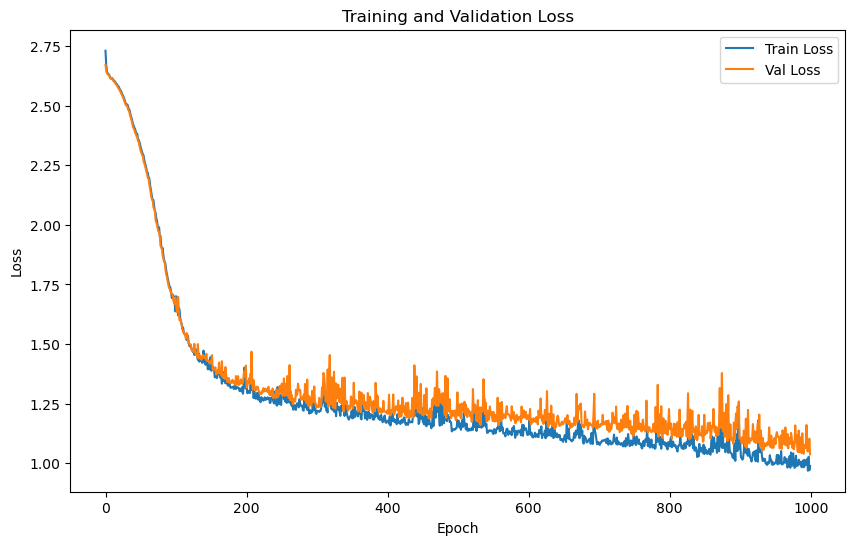

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.2103 | Test Accuracy: 46.77%


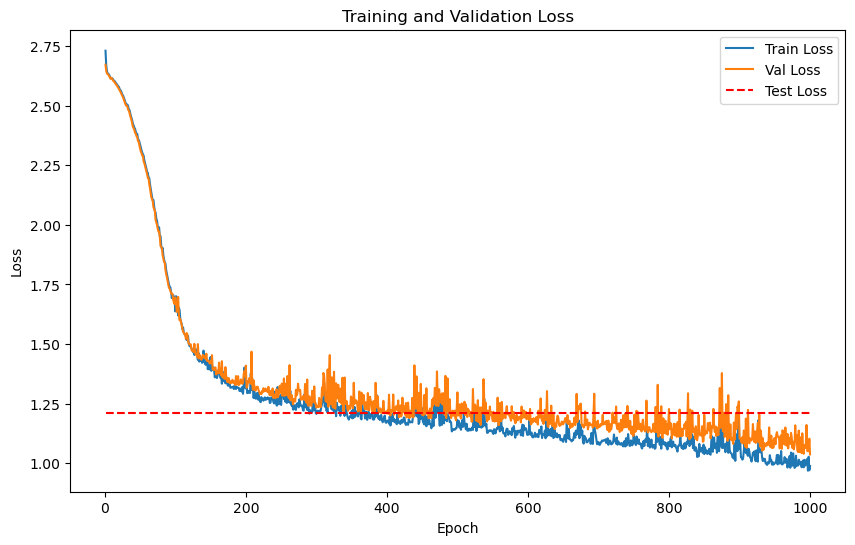

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.2526
Epoch [1/2000], Avg Train Loss: 8.2526
Epoch [1/2000], Avg Val Loss: 3.4169
Validation loss improved from inf to 3.4169. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1488
Epoch [2/2000], Avg Train Loss: 8.1488
Epoch [2/2000], Avg Val Loss: 3.4040
Validation loss improved from 3.4169 to 3.4040. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1084
Epoch [3/2000], Avg Train Loss: 8.1084
Epoch [3/2000], Avg Val Loss: 3.3922
Validation loss improved from 3.4040 to 3.3922. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.3362
Epoch [4/2000], Avg Train Loss: 8.3362
Epoch [4/2000], Avg Val Loss: 3.3810
Validation loss improved from 3.3922 to 3.3810. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.1404
Epoch [5/2000], Avg Train Loss: 8.1404
Epoch [5/2000], Avg Val Loss: 3.3707
Validation loss improved from 3.3810 to 3.3707. Saving mode

Epoch [18/2000], Avg Val Loss: 3.2796
Validation loss improved from 3.2841 to 3.2796. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.9655
Epoch [19/2000], Avg Train Loss: 6.9655
Epoch [19/2000], Avg Val Loss: 3.2753
Validation loss improved from 3.2796 to 3.2753. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.8763
Epoch [20/2000], Avg Train Loss: 6.8763
Epoch [20/2000], Avg Val Loss: 3.2714
Validation loss improved from 3.2753 to 3.2714. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.1056
Epoch [21/2000], Avg Train Loss: 7.1056
Epoch [21/2000], Avg Val Loss: 3.2678
Validation loss improved from 3.2714 to 3.2678. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.9389
Epoch [22/2000], Avg Train Loss: 6.9389
Epoch [22/2000], Avg Val Loss: 3.2645
Validation loss improved from 3.2678 to 3.2645. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 6.2644
Epoch [31/2000], Avg Train Loss: 6.2644
Epoch [31/2000], Avg Val Loss: 3.2448
Validation loss improved from 3.2463 to 3.2448. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.4532
Epoch [32/2000], Avg Train Loss: 6.4532
Epoch [32/2000], Avg Val Loss: 3.2436
Validation loss improved from 3.2448 to 3.2436. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.1594
Epoch [33/2000], Avg Train Loss: 6.1594
Epoch [33/2000], Avg Val Loss: 3.2425
Validation loss improved from 3.2436 to 3.2425. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.1673
Epoch [34/2000], Avg Train Loss: 6.1673
Epoch [34/2000], Avg Val Loss: 3.2417
Validation loss improved from 3.2425 to 3.2417. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.1370
Epoch [35/2000], Avg Train Loss: 6.1370
Epoch [35/2000], Avg Val Loss: 3.2409
Validation loss improved from 3.2417 to 3.

    Batch [1/1], Train Loss: 5.5834
Epoch [47/2000], Avg Train Loss: 5.5834
Epoch [47/2000], Avg Val Loss: 3.2392
Validation loss did not improve. Patience: 5/100

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.5728
Epoch [48/2000], Avg Train Loss: 5.5728
Epoch [48/2000], Avg Val Loss: 3.2396
Validation loss did not improve. Patience: 6/100

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.5797
Epoch [49/2000], Avg Train Loss: 5.5797
Epoch [49/2000], Avg Val Loss: 3.2399
Validation loss did not improve. Patience: 7/100

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.5332
Epoch [50/2000], Avg Train Loss: 5.5332
Epoch [50/2000], Avg Val Loss: 3.2404
Validation loss did not improve. Patience: 8/100

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.5049
Epoch [51/2000], Avg Train Loss: 5.5049
Epoch [51/2000], Avg Val Loss: 3.2408
Validation loss did not improve. Patience: 9/100

LOG: Epoch [52/2000] - Training
    Batch [1/1], Tra

    Batch [1/1], Train Loss: 5.1820
Epoch [63/2000], Avg Train Loss: 5.1820
Epoch [63/2000], Avg Val Loss: 3.2465
Validation loss did not improve. Patience: 21/100

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.1649
Epoch [64/2000], Avg Train Loss: 5.1649
Epoch [64/2000], Avg Val Loss: 3.2471
Validation loss did not improve. Patience: 22/100

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.2377
Epoch [65/2000], Avg Train Loss: 5.2377
Epoch [65/2000], Avg Val Loss: 3.2477
Validation loss did not improve. Patience: 23/100

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.0803
Epoch [66/2000], Avg Train Loss: 5.0803
Epoch [66/2000], Avg Val Loss: 3.2482
Validation loss did not improve. Patience: 24/100

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.0789
Epoch [67/2000], Avg Train Loss: 5.0789
Epoch [67/2000], Avg Val Loss: 3.2488
Validation loss did not improve. Patience: 25/100

LOG: Epoch [68/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.8866
Epoch [76/2000], Avg Train Loss: 4.8866
Epoch [76/2000], Avg Val Loss: 3.2537
Validation loss did not improve. Patience: 34/100

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.0160
Epoch [77/2000], Avg Train Loss: 5.0160
Epoch [77/2000], Avg Val Loss: 3.2542
Validation loss did not improve. Patience: 35/100

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.0887
Epoch [78/2000], Avg Train Loss: 5.0887
Epoch [78/2000], Avg Val Loss: 3.2548
Validation loss did not improve. Patience: 36/100

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 4.9397
Epoch [79/2000], Avg Train Loss: 4.9397
Epoch [79/2000], Avg Val Loss: 3.2554
Validation loss did not improve. Patience: 37/100

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.9159
Epoch [80/2000], Avg Train Loss: 4.9159
Epoch [80/2000], Avg Val Loss: 3.2559
Validation loss did not improve. Patience: 38/100

LOG: Epoch [81/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.8590
Epoch [90/2000], Avg Train Loss: 4.8590
Epoch [90/2000], Avg Val Loss: 3.2605
Validation loss did not improve. Patience: 48/100

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 4.7238
Epoch [91/2000], Avg Train Loss: 4.7238
Epoch [91/2000], Avg Val Loss: 3.2609
Validation loss did not improve. Patience: 49/100

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.7146
Epoch [92/2000], Avg Train Loss: 4.7146
Epoch [92/2000], Avg Val Loss: 3.2612
Validation loss did not improve. Patience: 50/100

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.7516
Epoch [93/2000], Avg Train Loss: 4.7516
Epoch [93/2000], Avg Val Loss: 3.2615
Validation loss did not improve. Patience: 51/100

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.8071
Epoch [94/2000], Avg Train Loss: 4.8071
Epoch [94/2000], Avg Val Loss: 3.2618
Validation loss did not improve. Patience: 52/100

LOG: Epoch [95/2000] - Training
    Batch [1/1]

    Batch [1/1], Train Loss: 4.7394
Epoch [104/2000], Avg Train Loss: 4.7394
Epoch [104/2000], Avg Val Loss: 3.2632
Validation loss did not improve. Patience: 62/100

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.7553
Epoch [105/2000], Avg Train Loss: 4.7553
Epoch [105/2000], Avg Val Loss: 3.2632
Validation loss did not improve. Patience: 63/100

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.6535
Epoch [106/2000], Avg Train Loss: 4.6535
Epoch [106/2000], Avg Val Loss: 3.2633
Validation loss did not improve. Patience: 64/100

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.5990
Epoch [107/2000], Avg Train Loss: 4.5990
Epoch [107/2000], Avg Val Loss: 3.2633
Validation loss did not improve. Patience: 65/100

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.6787
Epoch [108/2000], Avg Train Loss: 4.6787
Epoch [108/2000], Avg Val Loss: 3.2632
Validation loss did not improve. Patience: 66/100

LOG: Epoch [109/2000] - Training


Epoch [115/2000], Avg Val Loss: 3.2623
Validation loss did not improve. Patience: 73/100

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.6121
Epoch [116/2000], Avg Train Loss: 4.6121
Epoch [116/2000], Avg Val Loss: 3.2621
Validation loss did not improve. Patience: 74/100

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.5847
Epoch [117/2000], Avg Train Loss: 4.5847
Epoch [117/2000], Avg Val Loss: 3.2619
Validation loss did not improve. Patience: 75/100

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.5473
Epoch [118/2000], Avg Train Loss: 4.5473
Epoch [118/2000], Avg Val Loss: 3.2617
Validation loss did not improve. Patience: 76/100

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.5096
Epoch [119/2000], Avg Train Loss: 4.5096
Epoch [119/2000], Avg Val Loss: 3.2614
Validation loss did not improve. Patience: 77/100

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.6053
Epoch [120/2000], Avg Train Loss: 4.6053


    Batch [1/1], Train Loss: 4.4735
Epoch [132/2000], Avg Train Loss: 4.4735
Epoch [132/2000], Avg Val Loss: 3.2576
Validation loss did not improve. Patience: 90/100

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.3826
Epoch [133/2000], Avg Train Loss: 4.3826
Epoch [133/2000], Avg Val Loss: 3.2572
Validation loss did not improve. Patience: 91/100

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.4249
Epoch [134/2000], Avg Train Loss: 4.4249
Epoch [134/2000], Avg Val Loss: 3.2567
Validation loss did not improve. Patience: 92/100

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.4277
Epoch [135/2000], Avg Train Loss: 4.4277
Epoch [135/2000], Avg Val Loss: 3.2562
Validation loss did not improve. Patience: 93/100

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.5801
Epoch [136/2000], Avg Train Loss: 4.5801
Epoch [136/2000], Avg Val Loss: 3.2557
Validation loss did not improve. Patience: 94/100

LOG: Epoch [137/2000] - Training


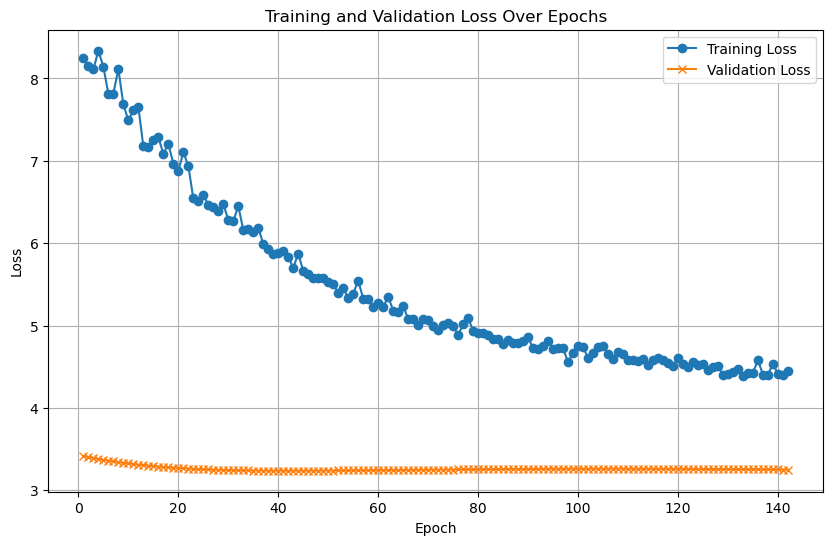

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.2064

Test Loss: 4.9889


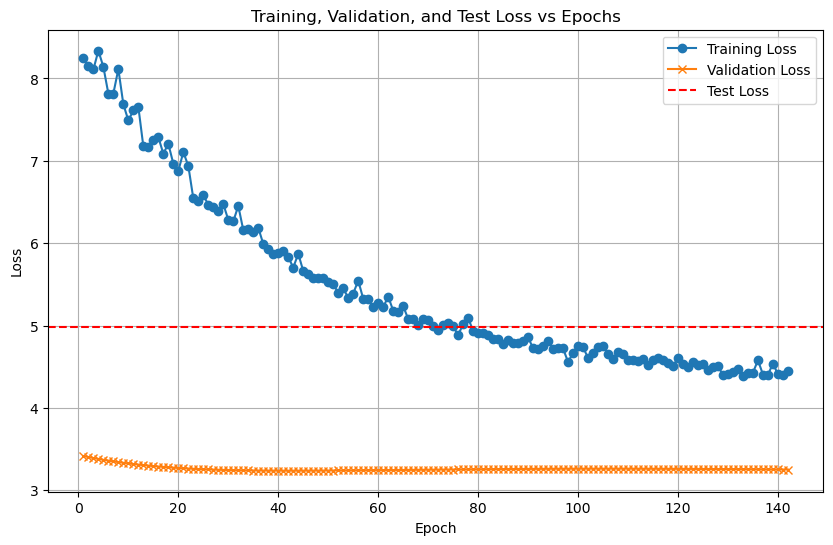

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.83      1.00      0.91         5
           3       0.83      1.00      0.91         5
           4       1.00      0.20      0.33         5
           5       0.00      0.00      0.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.40      0.57         5
           8       0.43      0.60      0.50         5
           9       0.83      1.00      0.91         5
          10       0.83      1.00      0.91         5
          11       0.56      1.00      0.71         5
          12       0.71      1.00      0.83         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6324  |  Val Loss: 2.6322
Validation loss improved from inf to 2.6322.
[Epoch 2/1000] Train Loss: 2.6230  |  Val Loss: 2.6241
Validation loss improved from 2.6322 to 2.6241.
[Epoch 3/1000] Train Loss: 2.6147  |  Val Loss: 2.6163
Validation loss improved from 2.6241 to 2.6163.
[Epoch 4/1000] Train Loss: 2.6072  |  Val Loss: 2.6092
Validation loss improved from 2.6163 to 2.6092.
[Epoch 5/1000] Train Loss: 2.5996  |  Val Loss: 2.6026
Validation loss improved from 2.6092 to 2.6026.
[Epoch 6/1000] Train Loss: 2.5929  |  Val Loss: 2.5960
Validation loss improved from 2.6026 to 2.5960.
[Epoch 7/1000] Train Loss: 2.5864  |  Val Loss: 2.5892
Validation loss improved from 2.5960 to 2.5892.
[Epoch 8/1000] Train Loss: 2.5793  |  Val Loss: 2.5829
Validation loss improved from 2.5892 to 2.5829.
[Epoch 9/1000] Train Loss: 2.5726  |  Val Loss: 2.5769
Validation loss improved from 2.5829 to 2.5769.
[Epoch 10/1000] Train Loss: 2.5662  |  Val Loss: 2.5708
Validation loss impr

[Epoch 16/1000] Train Loss: 2.5302  |  Val Loss: 2.5370
Validation loss improved from 2.5421 to 2.5370.
[Epoch 17/1000] Train Loss: 2.5242  |  Val Loss: 2.5317
Validation loss improved from 2.5370 to 2.5317.
[Epoch 18/1000] Train Loss: 2.5188  |  Val Loss: 2.5263
Validation loss improved from 2.5317 to 2.5263.
[Epoch 19/1000] Train Loss: 2.5131  |  Val Loss: 2.5211
Validation loss improved from 2.5263 to 2.5211.
[Epoch 20/1000] Train Loss: 2.5078  |  Val Loss: 2.5161
Validation loss improved from 2.5211 to 2.5161.
[Epoch 21/1000] Train Loss: 2.5022  |  Val Loss: 2.5112
Validation loss improved from 2.5161 to 2.5112.
[Epoch 22/1000] Train Loss: 2.4968  |  Val Loss: 2.5064
Validation loss improved from 2.5112 to 2.5064.
[Epoch 23/1000] Train Loss: 2.4916  |  Val Loss: 2.5016
Validation loss improved from 2.5064 to 2.5016.


[Epoch 24/1000] Train Loss: 2.4865  |  Val Loss: 2.4968
Validation loss improved from 2.5016 to 2.4968.
[Epoch 25/1000] Train Loss: 2.4809  |  Val Loss: 2.4923
Validation loss improved from 2.4968 to 2.4923.
[Epoch 26/1000] Train Loss: 2.4758  |  Val Loss: 2.4877
Validation loss improved from 2.4923 to 2.4877.
[Epoch 27/1000] Train Loss: 2.4709  |  Val Loss: 2.4832
Validation loss improved from 2.4877 to 2.4832.
[Epoch 28/1000] Train Loss: 2.4655  |  Val Loss: 2.4786
Validation loss improved from 2.4832 to 2.4786.
[Epoch 29/1000] Train Loss: 2.4603  |  Val Loss: 2.4737
Validation loss improved from 2.4786 to 2.4737.
[Epoch 30/1000] Train Loss: 2.4550  |  Val Loss: 2.4687
Validation loss improved from 2.4737 to 2.4687.
[Epoch 31/1000] Train Loss: 2.4495  |  Val Loss: 2.4638
Validation loss improved from 2.4687 to 2.4638.
[Epoch 32/1000] Train Loss: 2.4439  |  Val Loss: 2.4589
Validation loss improved from 2.4638 to 2.4589.
[Epoch 33/1000] Train Loss: 2.4387  |  Val Loss: 2.4540
Validati

[Epoch 44/1000] Train Loss: 2.3764  |  Val Loss: 2.3988
Validation loss improved from 2.4042 to 2.3988.
[Epoch 45/1000] Train Loss: 2.3705  |  Val Loss: 2.3933
Validation loss improved from 2.3988 to 2.3933.
[Epoch 46/1000] Train Loss: 2.3648  |  Val Loss: 2.3877
Validation loss improved from 2.3933 to 2.3877.
[Epoch 47/1000] Train Loss: 2.3586  |  Val Loss: 2.3822
Validation loss improved from 2.3877 to 2.3822.
[Epoch 48/1000] Train Loss: 2.3527  |  Val Loss: 2.3765
Validation loss improved from 2.3822 to 2.3765.
[Epoch 49/1000] Train Loss: 2.3469  |  Val Loss: 2.3709
Validation loss improved from 2.3765 to 2.3709.
[Epoch 50/1000] Train Loss: 2.3404  |  Val Loss: 2.3654
Validation loss improved from 2.3709 to 2.3654.
[Epoch 51/1000] Train Loss: 2.3347  |  Val Loss: 2.3597
Validation loss improved from 2.3654 to 2.3597.
[Epoch 52/1000] Train Loss: 2.3286  |  Val Loss: 2.3540
Validation loss improved from 2.3597 to 2.3540.
[Epoch 53/1000] Train Loss: 2.3225  |  Val Loss: 2.3483
Validati

[Epoch 54/1000] Train Loss: 2.3168  |  Val Loss: 2.3427
Validation loss improved from 2.3483 to 2.3427.
[Epoch 55/1000] Train Loss: 2.3108  |  Val Loss: 2.3373
Validation loss improved from 2.3427 to 2.3373.
[Epoch 56/1000] Train Loss: 2.3052  |  Val Loss: 2.3319
Validation loss improved from 2.3373 to 2.3319.
[Epoch 57/1000] Train Loss: 2.2990  |  Val Loss: 2.3265
Validation loss improved from 2.3319 to 2.3265.
[Epoch 58/1000] Train Loss: 2.2934  |  Val Loss: 2.3209
Validation loss improved from 2.3265 to 2.3209.
[Epoch 59/1000] Train Loss: 2.2875  |  Val Loss: 2.3152
Validation loss improved from 2.3209 to 2.3152.
[Epoch 60/1000] Train Loss: 2.2815  |  Val Loss: 2.3094
Validation loss improved from 2.3152 to 2.3094.
[Epoch 61/1000] Train Loss: 2.2754  |  Val Loss: 2.3034
Validation loss improved from 2.3094 to 2.3034.
[Epoch 62/1000] Train Loss: 2.2695  |  Val Loss: 2.2974
Validation loss improved from 2.3034 to 2.2974.
[Epoch 63/1000] Train Loss: 2.2631  |  Val Loss: 2.2916
Validati

[Epoch 73/1000] Train Loss: 2.2014  |  Val Loss: 2.2338
Validation loss improved from 2.2396 to 2.2338.
[Epoch 74/1000] Train Loss: 2.1950  |  Val Loss: 2.2280
Validation loss improved from 2.2338 to 2.2280.
[Epoch 75/1000] Train Loss: 2.1890  |  Val Loss: 2.2223
Validation loss improved from 2.2280 to 2.2223.
[Epoch 76/1000] Train Loss: 2.1828  |  Val Loss: 2.2166
Validation loss improved from 2.2223 to 2.2166.
[Epoch 77/1000] Train Loss: 2.1769  |  Val Loss: 2.2110
Validation loss improved from 2.2166 to 2.2110.
[Epoch 78/1000] Train Loss: 2.1707  |  Val Loss: 2.2053
Validation loss improved from 2.2110 to 2.2053.
[Epoch 79/1000] Train Loss: 2.1646  |  Val Loss: 2.1995
Validation loss improved from 2.2053 to 2.1995.
[Epoch 80/1000] Train Loss: 2.1587  |  Val Loss: 2.1936
Validation loss improved from 2.1995 to 2.1936.
[Epoch 81/1000] Train Loss: 2.1528  |  Val Loss: 2.1878
Validation loss improved from 2.1936 to 2.1878.
[Epoch 82/1000] Train Loss: 2.1469  |  Val Loss: 2.1824
Validati

[Epoch 83/1000] Train Loss: 2.1409  |  Val Loss: 2.1770
Validation loss improved from 2.1824 to 2.1770.
[Epoch 84/1000] Train Loss: 2.1353  |  Val Loss: 2.1717
Validation loss improved from 2.1770 to 2.1717.
[Epoch 85/1000] Train Loss: 2.1299  |  Val Loss: 2.1663
Validation loss improved from 2.1717 to 2.1663.
[Epoch 86/1000] Train Loss: 2.1242  |  Val Loss: 2.1606
Validation loss improved from 2.1663 to 2.1606.
[Epoch 87/1000] Train Loss: 2.1182  |  Val Loss: 2.1551
Validation loss improved from 2.1606 to 2.1551.
[Epoch 88/1000] Train Loss: 2.1127  |  Val Loss: 2.1496
Validation loss improved from 2.1551 to 2.1496.
[Epoch 89/1000] Train Loss: 2.1070  |  Val Loss: 2.1441
Validation loss improved from 2.1496 to 2.1441.
[Epoch 90/1000] Train Loss: 2.1011  |  Val Loss: 2.1385
Validation loss improved from 2.1441 to 2.1385.
[Epoch 91/1000] Train Loss: 2.0954  |  Val Loss: 2.1328
Validation loss improved from 2.1385 to 2.1328.
[Epoch 92/1000] Train Loss: 2.0893  |  Val Loss: 2.1273
Validati

[Epoch 103/1000] Train Loss: 2.0220  |  Val Loss: 2.0635
Validation loss improved from 2.0692 to 2.0635.
[Epoch 104/1000] Train Loss: 2.0159  |  Val Loss: 2.0580
Validation loss improved from 2.0635 to 2.0580.
[Epoch 105/1000] Train Loss: 2.0102  |  Val Loss: 2.0525
Validation loss improved from 2.0580 to 2.0525.
[Epoch 106/1000] Train Loss: 2.0045  |  Val Loss: 2.0468
Validation loss improved from 2.0525 to 2.0468.
[Epoch 107/1000] Train Loss: 1.9989  |  Val Loss: 2.0406
Validation loss improved from 2.0468 to 2.0406.
[Epoch 108/1000] Train Loss: 1.9925  |  Val Loss: 2.0347
Validation loss improved from 2.0406 to 2.0347.
[Epoch 109/1000] Train Loss: 1.9865  |  Val Loss: 2.0288
Validation loss improved from 2.0347 to 2.0288.


[Epoch 110/1000] Train Loss: 1.9804  |  Val Loss: 2.0231
Validation loss improved from 2.0288 to 2.0231.
[Epoch 111/1000] Train Loss: 1.9746  |  Val Loss: 2.0175
Validation loss improved from 2.0231 to 2.0175.
[Epoch 112/1000] Train Loss: 1.9693  |  Val Loss: 2.0124
Validation loss improved from 2.0175 to 2.0124.
[Epoch 113/1000] Train Loss: 1.9635  |  Val Loss: 2.0073
Validation loss improved from 2.0124 to 2.0073.
[Epoch 114/1000] Train Loss: 1.9579  |  Val Loss: 2.0020
Validation loss improved from 2.0073 to 2.0020.
[Epoch 115/1000] Train Loss: 1.9520  |  Val Loss: 1.9966
Validation loss improved from 2.0020 to 1.9966.
[Epoch 116/1000] Train Loss: 1.9462  |  Val Loss: 1.9914
Validation loss improved from 1.9966 to 1.9914.
[Epoch 117/1000] Train Loss: 1.9406  |  Val Loss: 1.9863
Validation loss improved from 1.9914 to 1.9863.
[Epoch 118/1000] Train Loss: 1.9353  |  Val Loss: 1.9811
Validation loss improved from 1.9863 to 1.9811.
[Epoch 119/1000] Train Loss: 1.9295  |  Val Loss: 1.975

[Epoch 128/1000] Train Loss: 1.8807  |  Val Loss: 1.9296
Validation loss improved from 1.9346 to 1.9296.
[Epoch 129/1000] Train Loss: 1.8749  |  Val Loss: 1.9243
Validation loss improved from 1.9296 to 1.9243.
[Epoch 130/1000] Train Loss: 1.8698  |  Val Loss: 1.9192
Validation loss improved from 1.9243 to 1.9192.
[Epoch 131/1000] Train Loss: 1.8639  |  Val Loss: 1.9136
Validation loss improved from 1.9192 to 1.9136.
[Epoch 132/1000] Train Loss: 1.8579  |  Val Loss: 1.9080
Validation loss improved from 1.9136 to 1.9080.
[Epoch 133/1000] Train Loss: 1.8519  |  Val Loss: 1.9023
Validation loss improved from 1.9080 to 1.9023.
[Epoch 134/1000] Train Loss: 1.8461  |  Val Loss: 1.8968
Validation loss improved from 1.9023 to 1.8968.


[Epoch 135/1000] Train Loss: 1.8404  |  Val Loss: 1.8913
Validation loss improved from 1.8968 to 1.8913.
[Epoch 136/1000] Train Loss: 1.8351  |  Val Loss: 1.8863
Validation loss improved from 1.8913 to 1.8863.
[Epoch 137/1000] Train Loss: 1.8295  |  Val Loss: 1.8815
Validation loss improved from 1.8863 to 1.8815.
[Epoch 138/1000] Train Loss: 1.8248  |  Val Loss: 1.8770
Validation loss improved from 1.8815 to 1.8770.
[Epoch 139/1000] Train Loss: 1.8197  |  Val Loss: 1.8722
Validation loss improved from 1.8770 to 1.8722.
[Epoch 140/1000] Train Loss: 1.8145  |  Val Loss: 1.8672
Validation loss improved from 1.8722 to 1.8672.
[Epoch 141/1000] Train Loss: 1.8094  |  Val Loss: 1.8618
Validation loss improved from 1.8672 to 1.8618.
[Epoch 142/1000] Train Loss: 1.8040  |  Val Loss: 1.8564
Validation loss improved from 1.8618 to 1.8564.
[Epoch 143/1000] Train Loss: 1.7987  |  Val Loss: 1.8512
Validation loss improved from 1.8564 to 1.8512.
[Epoch 144/1000] Train Loss: 1.7934  |  Val Loss: 1.846

[Epoch 158/1000] Train Loss: 1.7236  |  Val Loss: 1.7813
Validation loss improved from 1.7861 to 1.7813.
[Epoch 159/1000] Train Loss: 1.7192  |  Val Loss: 1.7765
Validation loss improved from 1.7813 to 1.7765.
[Epoch 160/1000] Train Loss: 1.7140  |  Val Loss: 1.7718
Validation loss improved from 1.7765 to 1.7718.
[Epoch 161/1000] Train Loss: 1.7092  |  Val Loss: 1.7672
Validation loss improved from 1.7718 to 1.7672.
[Epoch 162/1000] Train Loss: 1.7047  |  Val Loss: 1.7629
Validation loss improved from 1.7672 to 1.7629.
[Epoch 163/1000] Train Loss: 1.7001  |  Val Loss: 1.7586
Validation loss improved from 1.7629 to 1.7586.
[Epoch 164/1000] Train Loss: 1.6953  |  Val Loss: 1.7541
Validation loss improved from 1.7586 to 1.7541.
[Epoch 165/1000] Train Loss: 1.6905  |  Val Loss: 1.7495
Validation loss improved from 1.7541 to 1.7495.
[Epoch 166/1000] Train Loss: 1.6860  |  Val Loss: 1.7450
Validation loss improved from 1.7495 to 1.7450.
[Epoch 167/1000] Train Loss: 1.6811  |  Val Loss: 1.740

[Epoch 168/1000] Train Loss: 1.6767  |  Val Loss: 1.7358
Validation loss improved from 1.7405 to 1.7358.
[Epoch 169/1000] Train Loss: 1.6719  |  Val Loss: 1.7313
Validation loss improved from 1.7358 to 1.7313.
[Epoch 170/1000] Train Loss: 1.6674  |  Val Loss: 1.7272
Validation loss improved from 1.7313 to 1.7272.
[Epoch 171/1000] Train Loss: 1.6626  |  Val Loss: 1.7234
Validation loss improved from 1.7272 to 1.7234.
[Epoch 172/1000] Train Loss: 1.6582  |  Val Loss: 1.7196
Validation loss improved from 1.7234 to 1.7196.
[Epoch 173/1000] Train Loss: 1.6538  |  Val Loss: 1.7156
Validation loss improved from 1.7196 to 1.7156.
[Epoch 174/1000] Train Loss: 1.6498  |  Val Loss: 1.7114
Validation loss improved from 1.7156 to 1.7114.
[Epoch 175/1000] Train Loss: 1.6446  |  Val Loss: 1.7074
Validation loss improved from 1.7114 to 1.7074.
[Epoch 176/1000] Train Loss: 1.6399  |  Val Loss: 1.7034
Validation loss improved from 1.7074 to 1.7034.
[Epoch 177/1000] Train Loss: 1.6358  |  Val Loss: 1.699

[Epoch 190/1000] Train Loss: 1.5798  |  Val Loss: 1.6457
Validation loss improved from 1.6499 to 1.6457.
[Epoch 191/1000] Train Loss: 1.5754  |  Val Loss: 1.6415
Validation loss improved from 1.6457 to 1.6415.
[Epoch 192/1000] Train Loss: 1.5710  |  Val Loss: 1.6370
Validation loss improved from 1.6415 to 1.6370.
[Epoch 193/1000] Train Loss: 1.5663  |  Val Loss: 1.6327
Validation loss improved from 1.6370 to 1.6327.
[Epoch 194/1000] Train Loss: 1.5626  |  Val Loss: 1.6286
Validation loss improved from 1.6327 to 1.6286.
[Epoch 195/1000] Train Loss: 1.5584  |  Val Loss: 1.6248
Validation loss improved from 1.6286 to 1.6248.
[Epoch 196/1000] Train Loss: 1.5544  |  Val Loss: 1.6209
Validation loss improved from 1.6248 to 1.6209.
[Epoch 197/1000] Train Loss: 1.5498  |  Val Loss: 1.6169
Validation loss improved from 1.6209 to 1.6169.


[Epoch 198/1000] Train Loss: 1.5453  |  Val Loss: 1.6129
Validation loss improved from 1.6169 to 1.6129.
[Epoch 199/1000] Train Loss: 1.5409  |  Val Loss: 1.6090
Validation loss improved from 1.6129 to 1.6090.
[Epoch 200/1000] Train Loss: 1.5365  |  Val Loss: 1.6054
Validation loss improved from 1.6090 to 1.6054.
[Epoch 201/1000] Train Loss: 1.5322  |  Val Loss: 1.6019
Validation loss improved from 1.6054 to 1.6019.
[Epoch 202/1000] Train Loss: 1.5283  |  Val Loss: 1.5984
Validation loss improved from 1.6019 to 1.5984.
[Epoch 203/1000] Train Loss: 1.5239  |  Val Loss: 1.5947
Validation loss improved from 1.5984 to 1.5947.
[Epoch 204/1000] Train Loss: 1.5201  |  Val Loss: 1.5912
Validation loss improved from 1.5947 to 1.5912.
[Epoch 205/1000] Train Loss: 1.5160  |  Val Loss: 1.5876
Validation loss improved from 1.5912 to 1.5876.
[Epoch 206/1000] Train Loss: 1.5120  |  Val Loss: 1.5838
Validation loss improved from 1.5876 to 1.5838.
[Epoch 207/1000] Train Loss: 1.5078  |  Val Loss: 1.580

[Epoch 216/1000] Train Loss: 1.4695  |  Val Loss: 1.5424
Validation loss improved from 1.5464 to 1.5424.
[Epoch 217/1000] Train Loss: 1.4654  |  Val Loss: 1.5387
Validation loss improved from 1.5424 to 1.5387.
[Epoch 218/1000] Train Loss: 1.4613  |  Val Loss: 1.5352
Validation loss improved from 1.5387 to 1.5352.
[Epoch 219/1000] Train Loss: 1.4573  |  Val Loss: 1.5317
Validation loss improved from 1.5352 to 1.5317.
[Epoch 220/1000] Train Loss: 1.4533  |  Val Loss: 1.5277
Validation loss improved from 1.5317 to 1.5277.
[Epoch 221/1000] Train Loss: 1.4497  |  Val Loss: 1.5239
Validation loss improved from 1.5277 to 1.5239.
[Epoch 222/1000] Train Loss: 1.4455  |  Val Loss: 1.5205
Validation loss improved from 1.5239 to 1.5205.
[Epoch 223/1000] Train Loss: 1.4416  |  Val Loss: 1.5172
Validation loss improved from 1.5205 to 1.5172.


[Epoch 224/1000] Train Loss: 1.4381  |  Val Loss: 1.5139
Validation loss improved from 1.5172 to 1.5139.
[Epoch 225/1000] Train Loss: 1.4347  |  Val Loss: 1.5105
Validation loss improved from 1.5139 to 1.5105.
[Epoch 226/1000] Train Loss: 1.4318  |  Val Loss: 1.5074
Validation loss improved from 1.5105 to 1.5074.
[Epoch 227/1000] Train Loss: 1.4280  |  Val Loss: 1.5043
Validation loss improved from 1.5074 to 1.5043.
[Epoch 228/1000] Train Loss: 1.4239  |  Val Loss: 1.5009
Validation loss improved from 1.5043 to 1.5009.
[Epoch 229/1000] Train Loss: 1.4200  |  Val Loss: 1.4973
Validation loss improved from 1.5009 to 1.4973.
[Epoch 230/1000] Train Loss: 1.4157  |  Val Loss: 1.4933
Validation loss improved from 1.4973 to 1.4933.
[Epoch 231/1000] Train Loss: 1.4113  |  Val Loss: 1.4891
Validation loss improved from 1.4933 to 1.4891.
[Epoch 232/1000] Train Loss: 1.4074  |  Val Loss: 1.4854
Validation loss improved from 1.4891 to 1.4854.
[Epoch 233/1000] Train Loss: 1.4038  |  Val Loss: 1.481

[Epoch 242/1000] Train Loss: 1.3690  |  Val Loss: 1.4490
Validation loss improved from 1.4522 to 1.4490.
[Epoch 243/1000] Train Loss: 1.3653  |  Val Loss: 1.4461
Validation loss improved from 1.4490 to 1.4461.
[Epoch 244/1000] Train Loss: 1.3618  |  Val Loss: 1.4432
Validation loss improved from 1.4461 to 1.4432.
[Epoch 245/1000] Train Loss: 1.3582  |  Val Loss: 1.4402
Validation loss improved from 1.4432 to 1.4402.
[Epoch 246/1000] Train Loss: 1.3549  |  Val Loss: 1.4371
Validation loss improved from 1.4402 to 1.4371.
[Epoch 247/1000] Train Loss: 1.3511  |  Val Loss: 1.4343
Validation loss improved from 1.4371 to 1.4343.
[Epoch 248/1000] Train Loss: 1.3478  |  Val Loss: 1.4316
Validation loss improved from 1.4343 to 1.4316.
[Epoch 249/1000] Train Loss: 1.3443  |  Val Loss: 1.4287
Validation loss improved from 1.4316 to 1.4287.
[Epoch 250/1000] Train Loss: 1.3403  |  Val Loss: 1.4251
Validation loss improved from 1.4287 to 1.4251.
[Epoch 251/1000] Train Loss: 1.3366  |  Val Loss: 1.421

[Epoch 253/1000] Train Loss: 1.3285  |  Val Loss: 1.4140
Validation loss improved from 1.4177 to 1.4140.
[Epoch 254/1000] Train Loss: 1.3244  |  Val Loss: 1.4110
Validation loss improved from 1.4140 to 1.4110.
[Epoch 255/1000] Train Loss: 1.3213  |  Val Loss: 1.4084
Validation loss improved from 1.4110 to 1.4084.
[Epoch 256/1000] Train Loss: 1.3178  |  Val Loss: 1.4060
Validation loss improved from 1.4084 to 1.4060.
[Epoch 257/1000] Train Loss: 1.3145  |  Val Loss: 1.4032
Validation loss improved from 1.4060 to 1.4032.
[Epoch 258/1000] Train Loss: 1.3110  |  Val Loss: 1.3996
Validation loss improved from 1.4032 to 1.3996.
[Epoch 259/1000] Train Loss: 1.3076  |  Val Loss: 1.3960
Validation loss improved from 1.3996 to 1.3960.
[Epoch 260/1000] Train Loss: 1.3040  |  Val Loss: 1.3925
Validation loss improved from 1.3960 to 1.3925.
[Epoch 261/1000] Train Loss: 1.2999  |  Val Loss: 1.3896
Validation loss improved from 1.3925 to 1.3896.
[Epoch 262/1000] Train Loss: 1.2965  |  Val Loss: 1.386

[Epoch 271/1000] Train Loss: 1.2631  |  Val Loss: 1.3541
Validation loss improved from 1.3567 to 1.3541.
[Epoch 272/1000] Train Loss: 1.2603  |  Val Loss: 1.3517
Validation loss improved from 1.3541 to 1.3517.
[Epoch 273/1000] Train Loss: 1.2567  |  Val Loss: 1.3489
Validation loss improved from 1.3517 to 1.3489.
[Epoch 274/1000] Train Loss: 1.2532  |  Val Loss: 1.3459
Validation loss improved from 1.3489 to 1.3459.
[Epoch 275/1000] Train Loss: 1.2497  |  Val Loss: 1.3431
Validation loss improved from 1.3459 to 1.3431.
[Epoch 276/1000] Train Loss: 1.2465  |  Val Loss: 1.3410
Validation loss improved from 1.3431 to 1.3410.
[Epoch 277/1000] Train Loss: 1.2433  |  Val Loss: 1.3384
Validation loss improved from 1.3410 to 1.3384.
[Epoch 278/1000] Train Loss: 1.2400  |  Val Loss: 1.3357
Validation loss improved from 1.3384 to 1.3357.
[Epoch 279/1000] Train Loss: 1.2366  |  Val Loss: 1.3330
Validation loss improved from 1.3357 to 1.3330.
[Epoch 280/1000] Train Loss: 1.2335  |  Val Loss: 1.329

[Epoch 282/1000] Train Loss: 1.2270  |  Val Loss: 1.3227
Validation loss improved from 1.3260 to 1.3227.
[Epoch 283/1000] Train Loss: 1.2238  |  Val Loss: 1.3194
Validation loss improved from 1.3227 to 1.3194.
[Epoch 284/1000] Train Loss: 1.2209  |  Val Loss: 1.3161
Validation loss improved from 1.3194 to 1.3161.
[Epoch 285/1000] Train Loss: 1.2174  |  Val Loss: 1.3131
Validation loss improved from 1.3161 to 1.3131.
[Epoch 286/1000] Train Loss: 1.2146  |  Val Loss: 1.3103
Validation loss improved from 1.3131 to 1.3103.
[Epoch 287/1000] Train Loss: 1.2112  |  Val Loss: 1.3078
Validation loss improved from 1.3103 to 1.3078.
[Epoch 288/1000] Train Loss: 1.2083  |  Val Loss: 1.3058
Validation loss improved from 1.3078 to 1.3058.
[Epoch 289/1000] Train Loss: 1.2059  |  Val Loss: 1.3037
Validation loss improved from 1.3058 to 1.3037.
[Epoch 290/1000] Train Loss: 1.2027  |  Val Loss: 1.3017
Validation loss improved from 1.3037 to 1.3017.
[Epoch 291/1000] Train Loss: 1.1997  |  Val Loss: 1.299

[Epoch 303/1000] Train Loss: 1.1652  |  Val Loss: 1.2671
Validation loss improved from 1.2696 to 1.2671.
[Epoch 304/1000] Train Loss: 1.1615  |  Val Loss: 1.2642
Validation loss improved from 1.2671 to 1.2642.
[Epoch 305/1000] Train Loss: 1.1580  |  Val Loss: 1.2614
Validation loss improved from 1.2642 to 1.2614.
[Epoch 306/1000] Train Loss: 1.1548  |  Val Loss: 1.2589
Validation loss improved from 1.2614 to 1.2589.
[Epoch 307/1000] Train Loss: 1.1519  |  Val Loss: 1.2566
Validation loss improved from 1.2589 to 1.2566.
[Epoch 308/1000] Train Loss: 1.1490  |  Val Loss: 1.2550
Validation loss improved from 1.2566 to 1.2550.
[Epoch 309/1000] Train Loss: 1.1463  |  Val Loss: 1.2533
Validation loss improved from 1.2550 to 1.2533.
[Epoch 310/1000] Train Loss: 1.1439  |  Val Loss: 1.2514
Validation loss improved from 1.2533 to 1.2514.
[Epoch 311/1000] Train Loss: 1.1417  |  Val Loss: 1.2490
Validation loss improved from 1.2514 to 1.2490.
[Epoch 312/1000] Train Loss: 1.1384  |  Val Loss: 1.246

[Epoch 314/1000] Train Loss: 1.1324  |  Val Loss: 1.2426
Validation loss improved from 1.2447 to 1.2426.
[Epoch 315/1000] Train Loss: 1.1301  |  Val Loss: 1.2404
Validation loss improved from 1.2426 to 1.2404.
[Epoch 316/1000] Train Loss: 1.1273  |  Val Loss: 1.2383
Validation loss improved from 1.2404 to 1.2383.
[Epoch 317/1000] Train Loss: 1.1250  |  Val Loss: 1.2363
Validation loss improved from 1.2383 to 1.2363.
[Epoch 318/1000] Train Loss: 1.1219  |  Val Loss: 1.2345
Validation loss improved from 1.2363 to 1.2345.
[Epoch 319/1000] Train Loss: 1.1195  |  Val Loss: 1.2328
Validation loss improved from 1.2345 to 1.2328.
[Epoch 320/1000] Train Loss: 1.1168  |  Val Loss: 1.2311
Validation loss improved from 1.2328 to 1.2311.
[Epoch 321/1000] Train Loss: 1.1145  |  Val Loss: 1.2296
Validation loss improved from 1.2311 to 1.2296.
[Epoch 322/1000] Train Loss: 1.1116  |  Val Loss: 1.2275
Validation loss improved from 1.2296 to 1.2275.
[Epoch 323/1000] Train Loss: 1.1105  |  Val Loss: 1.225

[Epoch 332/1000] Train Loss: 1.0878  |  Val Loss: 1.2064
Validation loss improved from 1.2077 to 1.2064.
[Epoch 333/1000] Train Loss: 1.0856  |  Val Loss: 1.2055
Validation loss improved from 1.2064 to 1.2055.
[Epoch 334/1000] Train Loss: 1.0850  |  Val Loss: 1.2042
Validation loss improved from 1.2055 to 1.2042.
[Epoch 335/1000] Train Loss: 1.0823  |  Val Loss: 1.2018
Validation loss improved from 1.2042 to 1.2018.
[Epoch 336/1000] Train Loss: 1.0809  |  Val Loss: 1.1999
Validation loss improved from 1.2018 to 1.1999.
[Epoch 337/1000] Train Loss: 1.0779  |  Val Loss: 1.1971
Validation loss improved from 1.1999 to 1.1971.
[Epoch 338/1000] Train Loss: 1.0750  |  Val Loss: 1.1942
Validation loss improved from 1.1971 to 1.1942.
[Epoch 339/1000] Train Loss: 1.0721  |  Val Loss: 1.1920
Validation loss improved from 1.1942 to 1.1920.
[Epoch 340/1000] Train Loss: 1.0698  |  Val Loss: 1.1897
Validation loss improved from 1.1920 to 1.1897.
[Epoch 341/1000] Train Loss: 1.0684  |  Val Loss: 1.187

[Epoch 343/1000] Train Loss: 1.0632  |  Val Loss: 1.1844
Validation loss improved from 1.1857 to 1.1844.
[Epoch 344/1000] Train Loss: 1.0603  |  Val Loss: 1.1837
Validation loss improved from 1.1844 to 1.1837.
[Epoch 345/1000] Train Loss: 1.0577  |  Val Loss: 1.1833
Validation loss improved from 1.1837 to 1.1833.
[Epoch 346/1000] Train Loss: 1.0556  |  Val Loss: 1.1826
Validation loss improved from 1.1833 to 1.1826.
[Epoch 347/1000] Train Loss: 1.0535  |  Val Loss: 1.1809
Validation loss improved from 1.1826 to 1.1809.
[Epoch 348/1000] Train Loss: 1.0510  |  Val Loss: 1.1790
Validation loss improved from 1.1809 to 1.1790.
[Epoch 349/1000] Train Loss: 1.0481  |  Val Loss: 1.1777
Validation loss improved from 1.1790 to 1.1777.
[Epoch 350/1000] Train Loss: 1.0461  |  Val Loss: 1.1766
Validation loss improved from 1.1777 to 1.1766.
[Epoch 351/1000] Train Loss: 1.0444  |  Val Loss: 1.1751
Validation loss improved from 1.1766 to 1.1751.
[Epoch 352/1000] Train Loss: 1.0425  |  Val Loss: 1.172

[Epoch 362/1000] Train Loss: 1.0203  |  Val Loss: 1.1538
Validation loss improved from 1.1549 to 1.1538.
[Epoch 363/1000] Train Loss: 1.0182  |  Val Loss: 1.1525
Validation loss improved from 1.1538 to 1.1525.
[Epoch 364/1000] Train Loss: 1.0164  |  Val Loss: 1.1508
Validation loss improved from 1.1525 to 1.1508.
[Epoch 365/1000] Train Loss: 1.0143  |  Val Loss: 1.1488
Validation loss improved from 1.1508 to 1.1488.
[Epoch 366/1000] Train Loss: 1.0119  |  Val Loss: 1.1473
Validation loss improved from 1.1488 to 1.1473.
[Epoch 367/1000] Train Loss: 1.0096  |  Val Loss: 1.1461
Validation loss improved from 1.1473 to 1.1461.
[Epoch 368/1000] Train Loss: 1.0080  |  Val Loss: 1.1443
Validation loss improved from 1.1461 to 1.1443.
[Epoch 369/1000] Train Loss: 1.0061  |  Val Loss: 1.1425
Validation loss improved from 1.1443 to 1.1425.
[Epoch 370/1000] Train Loss: 1.0040  |  Val Loss: 1.1407
Validation loss improved from 1.1425 to 1.1407.
[Epoch 371/1000] Train Loss: 1.0016  |  Val Loss: 1.139

[Epoch 374/1000] Train Loss: 0.9954  |  Val Loss: 1.1379
Validation loss improved from 1.1380 to 1.1379.
[Epoch 375/1000] Train Loss: 0.9936  |  Val Loss: 1.1372
Validation loss improved from 1.1379 to 1.1372.
[Epoch 376/1000] Train Loss: 0.9922  |  Val Loss: 1.1350
Validation loss improved from 1.1372 to 1.1350.
[Epoch 377/1000] Train Loss: 0.9895  |  Val Loss: 1.1324
Validation loss improved from 1.1350 to 1.1324.
[Epoch 378/1000] Train Loss: 0.9871  |  Val Loss: 1.1300
Validation loss improved from 1.1324 to 1.1300.
[Epoch 379/1000] Train Loss: 0.9849  |  Val Loss: 1.1280
Validation loss improved from 1.1300 to 1.1280.
[Epoch 380/1000] Train Loss: 0.9831  |  Val Loss: 1.1256
Validation loss improved from 1.1280 to 1.1256.
[Epoch 381/1000] Train Loss: 0.9805  |  Val Loss: 1.1246
Validation loss improved from 1.1256 to 1.1246.
[Epoch 382/1000] Train Loss: 0.9785  |  Val Loss: 1.1236
Validation loss improved from 1.1246 to 1.1236.
[Epoch 383/1000] Train Loss: 0.9769  |  Val Loss: 1.122

[Epoch 394/1000] Train Loss: 0.9568  |  Val Loss: 1.1082
Validation loss improved from 1.1096 to 1.1082.
[Epoch 395/1000] Train Loss: 0.9550  |  Val Loss: 1.1065
Validation loss improved from 1.1082 to 1.1065.
[Epoch 396/1000] Train Loss: 0.9531  |  Val Loss: 1.1044
Validation loss improved from 1.1065 to 1.1044.
[Epoch 397/1000] Train Loss: 0.9510  |  Val Loss: 1.1022
Validation loss improved from 1.1044 to 1.1022.
[Epoch 398/1000] Train Loss: 0.9496  |  Val Loss: 1.1003
Validation loss improved from 1.1022 to 1.1003.
[Epoch 399/1000] Train Loss: 0.9485  |  Val Loss: 1.0986
Validation loss improved from 1.1003 to 1.0986.
[Epoch 400/1000] Train Loss: 0.9470  |  Val Loss: 1.0968
Validation loss improved from 1.0986 to 1.0968.
[Epoch 401/1000] Train Loss: 0.9461  |  Val Loss: 1.0953
Validation loss improved from 1.0968 to 1.0953.
[Epoch 402/1000] Train Loss: 0.9444  |  Val Loss: 1.0940
Validation loss improved from 1.0953 to 1.0940.
[Epoch 403/1000] Train Loss: 0.9423  |  Val Loss: 1.092

[Epoch 405/1000] Train Loss: 0.9370  |  Val Loss: 1.0895
Validation loss improved from 1.0903 to 1.0895.
[Epoch 406/1000] Train Loss: 0.9346  |  Val Loss: 1.0888
Validation loss improved from 1.0895 to 1.0888.
[Epoch 407/1000] Train Loss: 0.9329  |  Val Loss: 1.0881
Validation loss improved from 1.0888 to 1.0881.
[Epoch 408/1000] Train Loss: 0.9314  |  Val Loss: 1.0872
Validation loss improved from 1.0881 to 1.0872.
[Epoch 409/1000] Train Loss: 0.9299  |  Val Loss: 1.0867
Validation loss improved from 1.0872 to 1.0867.
[Epoch 410/1000] Train Loss: 0.9284  |  Val Loss: 1.0855
Validation loss improved from 1.0867 to 1.0855.
[Epoch 411/1000] Train Loss: 0.9266  |  Val Loss: 1.0850
Validation loss improved from 1.0855 to 1.0850.
[Epoch 412/1000] Train Loss: 0.9249  |  Val Loss: 1.0844
Validation loss improved from 1.0850 to 1.0844.
[Epoch 413/1000] Train Loss: 0.9234  |  Val Loss: 1.0835
Validation loss improved from 1.0844 to 1.0835.
[Epoch 414/1000] Train Loss: 0.9215  |  Val Loss: 1.082

[Epoch 423/1000] Train Loss: 0.9078  |  Val Loss: 1.0737
Validation loss improved from 1.0757 to 1.0737.
[Epoch 424/1000] Train Loss: 0.9059  |  Val Loss: 1.0713
Validation loss improved from 1.0737 to 1.0713.
[Epoch 425/1000] Train Loss: 0.9037  |  Val Loss: 1.0698
Validation loss improved from 1.0713 to 1.0698.
[Epoch 426/1000] Train Loss: 0.9023  |  Val Loss: 1.0687
Validation loss improved from 1.0698 to 1.0687.
[Epoch 427/1000] Train Loss: 0.9003  |  Val Loss: 1.0667
Validation loss improved from 1.0687 to 1.0667.
[Epoch 428/1000] Train Loss: 0.8990  |  Val Loss: 1.0646
Validation loss improved from 1.0667 to 1.0646.
[Epoch 429/1000] Train Loss: 0.8972  |  Val Loss: 1.0636
Validation loss improved from 1.0646 to 1.0636.
[Epoch 430/1000] Train Loss: 0.8957  |  Val Loss: 1.0640
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 431/1000] Train Loss: 0.8940  |  Val Loss: 1.0647
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 432/1000] Train Loss: 0.8931  |  Val Loss: 1.0646
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 433/1000] Train Loss: 0.8914  |  Val Loss: 1.0632
Validation loss improved from 1.0636 to 1.0632.
[Epoch 434/1000] Train Loss: 0.8894  |  Val Loss: 1.0612
Validation loss improved from 1.0632 to 1.0612.
[Epoch 435/1000] Train Loss: 0.8877  |  Val Loss: 1.0594
Validation loss improved from 1.0612 to 1.0594.
[Epoch 436/1000] Train Loss: 0.8861  |  Val Loss: 1.0575
Validation loss improved from 1.0594 to 1.0575.
[Epoch 437/1000] Train Loss: 0.8841  |  Val Loss: 1.0552
Validation loss improved from 1.0575 to 1.0552.
[Epoch 438/1000] Train Loss: 0.8831  |  Val Loss: 1.0534
Validation loss improved from 1.0552 to 1.0534.
[Epoch 439/1000] Train Loss: 0.8816  |  Val Loss: 1.0525
Validation loss improved from 1.0534 to 1.0525.
[Epoch 440/1000] Train Loss: 0.8803  |  Val Loss: 1.0518
Validation loss improved from 1.0525 to 1.0518.
[Epoch 441/1000] Train Loss: 0.8780  |  Val Loss:

[Epoch 451/1000] Train Loss: 0.8639  |  Val Loss: 1.0391
Validation loss improved from 1.0401 to 1.0391.
[Epoch 452/1000] Train Loss: 0.8621  |  Val Loss: 1.0379
Validation loss improved from 1.0391 to 1.0379.
[Epoch 453/1000] Train Loss: 0.8607  |  Val Loss: 1.0366
Validation loss improved from 1.0379 to 1.0366.
[Epoch 454/1000] Train Loss: 0.8585  |  Val Loss: 1.0363
Validation loss improved from 1.0366 to 1.0363.
[Epoch 455/1000] Train Loss: 0.8567  |  Val Loss: 1.0359
Validation loss improved from 1.0363 to 1.0359.
[Epoch 456/1000] Train Loss: 0.8556  |  Val Loss: 1.0348
Validation loss improved from 1.0359 to 1.0348.
[Epoch 457/1000] Train Loss: 0.8543  |  Val Loss: 1.0334
Validation loss improved from 1.0348 to 1.0334.
[Epoch 458/1000] Train Loss: 0.8530  |  Val Loss: 1.0326
Validation loss improved from 1.0334 to 1.0326.


[Epoch 459/1000] Train Loss: 0.8520  |  Val Loss: 1.0325
Validation loss improved from 1.0326 to 1.0325.
[Epoch 460/1000] Train Loss: 0.8504  |  Val Loss: 1.0315
Validation loss improved from 1.0325 to 1.0315.
[Epoch 461/1000] Train Loss: 0.8494  |  Val Loss: 1.0298
Validation loss improved from 1.0315 to 1.0298.
[Epoch 462/1000] Train Loss: 0.8478  |  Val Loss: 1.0288
Validation loss improved from 1.0298 to 1.0288.
[Epoch 463/1000] Train Loss: 0.8470  |  Val Loss: 1.0277
Validation loss improved from 1.0288 to 1.0277.
[Epoch 464/1000] Train Loss: 0.8457  |  Val Loss: 1.0262
Validation loss improved from 1.0277 to 1.0262.
[Epoch 465/1000] Train Loss: 0.8439  |  Val Loss: 1.0245
Validation loss improved from 1.0262 to 1.0245.
[Epoch 466/1000] Train Loss: 0.8418  |  Val Loss: 1.0229
Validation loss improved from 1.0245 to 1.0229.
[Epoch 467/1000] Train Loss: 0.8405  |  Val Loss: 1.0212
Validation loss improved from 1.0229 to 1.0212.
[Epoch 468/1000] Train Loss: 0.8384  |  Val Loss: 1.019

[Epoch 480/1000] Train Loss: 0.8220  |  Val Loss: 1.0070
Validation loss improved from 1.0079 to 1.0070.
[Epoch 481/1000] Train Loss: 0.8201  |  Val Loss: 1.0073
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 482/1000] Train Loss: 0.8187  |  Val Loss: 1.0086
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 483/1000] Train Loss: 0.8181  |  Val Loss: 1.0094
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 484/1000] Train Loss: 0.8177  |  Val Loss: 1.0090
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 485/1000] Train Loss: 0.8158  |  Val Loss: 1.0078
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 486/1000] Train Loss: 0.8145  |  Val Loss: 1.0059
Validation loss improved from 1.0070 to 1.0059.
[Epoch 487/1000] Train Loss: 0.8134  |  Val Loss: 1.0034
Validation loss improved from 1.0059 to 1.0034.


[Epoch 488/1000] Train Loss: 0.8114  |  Val Loss: 1.0011
Validation loss improved from 1.0034 to 1.0011.
[Epoch 489/1000] Train Loss: 0.8102  |  Val Loss: 0.9997
Validation loss improved from 1.0011 to 0.9997.
[Epoch 490/1000] Train Loss: 0.8086  |  Val Loss: 0.9995
Validation loss improved from 0.9997 to 0.9995.
[Epoch 491/1000] Train Loss: 0.8076  |  Val Loss: 0.9994
Validation loss improved from 0.9995 to 0.9994.
[Epoch 492/1000] Train Loss: 0.8058  |  Val Loss: 0.9998
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 493/1000] Train Loss: 0.8045  |  Val Loss: 1.0005
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 494/1000] Train Loss: 0.8033  |  Val Loss: 1.0015
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 495/1000] Train Loss: 0.8021  |  Val Loss: 1.0017
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 496/1000] Train Loss: 0.8010  |  Val Loss: 1.0004
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 497/1000] Train Lo

[Epoch 508/1000] Train Loss: 0.7866  |  Val Loss: 0.9901
Validation loss improved from 0.9909 to 0.9901.
[Epoch 509/1000] Train Loss: 0.7848  |  Val Loss: 0.9878
Validation loss improved from 0.9901 to 0.9878.
[Epoch 510/1000] Train Loss: 0.7832  |  Val Loss: 0.9854
Validation loss improved from 0.9878 to 0.9854.
[Epoch 511/1000] Train Loss: 0.7816  |  Val Loss: 0.9838
Validation loss improved from 0.9854 to 0.9838.


[Epoch 512/1000] Train Loss: 0.7805  |  Val Loss: 0.9830
Validation loss improved from 0.9838 to 0.9830.
[Epoch 513/1000] Train Loss: 0.7796  |  Val Loss: 0.9822
Validation loss improved from 0.9830 to 0.9822.
[Epoch 514/1000] Train Loss: 0.7783  |  Val Loss: 0.9819
Validation loss improved from 0.9822 to 0.9819.
[Epoch 515/1000] Train Loss: 0.7776  |  Val Loss: 0.9811
Validation loss improved from 0.9819 to 0.9811.
[Epoch 516/1000] Train Loss: 0.7776  |  Val Loss: 0.9804
Validation loss improved from 0.9811 to 0.9804.
[Epoch 517/1000] Train Loss: 0.7762  |  Val Loss: 0.9803
Validation loss improved from 0.9804 to 0.9803.
[Epoch 518/1000] Train Loss: 0.7748  |  Val Loss: 0.9794
Validation loss improved from 0.9803 to 0.9794.
[Epoch 519/1000] Train Loss: 0.7730  |  Val Loss: 0.9781
Validation loss improved from 0.9794 to 0.9781.
[Epoch 520/1000] Train Loss: 0.7711  |  Val Loss: 0.9768
Validation loss improved from 0.9781 to 0.9768.
[Epoch 521/1000] Train Loss: 0.7698  |  Val Loss: 0.976

[Epoch 534/1000] Train Loss: 0.7548  |  Val Loss: 0.9683
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 535/1000] Train Loss: 0.7536  |  Val Loss: 0.9674
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 536/1000] Train Loss: 0.7527  |  Val Loss: 0.9673
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 537/1000] Train Loss: 0.7513  |  Val Loss: 0.9676
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 538/1000] Train Loss: 0.7501  |  Val Loss: 0.9677
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 539/1000] Train Loss: 0.7487  |  Val Loss: 0.9674
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 540/1000] Train Loss: 0.7469  |  Val Loss: 0.9652
Validation loss improved from 0.9659 to 0.9652.
[Epoch 541/1000] Train Loss: 0.7460  |  Val Loss: 0.9638
Validation loss improved from 0.9652 to 0.9638.
[Epoch 542/1000] Train Loss: 0.7459  |  Val Loss: 0.9624
Validation loss improved from 0.9638 to 0.9624.
[Epoch 543/1000] Tr

[Epoch 563/1000] Train Loss: 0.7218  |  Val Loss: 0.9539
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 564/1000] Train Loss: 0.7216  |  Val Loss: 0.9568
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 565/1000] Train Loss: 0.7216  |  Val Loss: 0.9568
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 566/1000] Train Loss: 0.7206  |  Val Loss: 0.9542
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 567/1000] Train Loss: 0.7185  |  Val Loss: 0.9492
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 568/1000] Train Loss: 0.7163  |  Val Loss: 0.9447
Validation loss improved from 0.9479 to 0.9447.
[Epoch 569/1000] Train Loss: 0.7143  |  Val Loss: 0.9418
Validation loss improved from 0.9447 to 0.9418.
[Epoch 570/1000] Train Loss: 0.7136  |  Val Loss: 0.9396
Validation loss improved from 0.9418 to 0.9396.
[Epoch 571/1000] Train Loss: 0.7124  |  Val Loss: 0.9378
Validation loss improved from 0.9396 to 0.9378.
[Epoch 572/1000] Train Lo

[Epoch 587/1000] Train Loss: 0.6969  |  Val Loss: 0.9221
Validation loss improved from 0.9224 to 0.9221.
[Epoch 588/1000] Train Loss: 0.6958  |  Val Loss: 0.9222
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 589/1000] Train Loss: 0.6948  |  Val Loss: 0.9210
Validation loss improved from 0.9221 to 0.9210.
[Epoch 590/1000] Train Loss: 0.6938  |  Val Loss: 0.9201
Validation loss improved from 0.9210 to 0.9201.
[Epoch 591/1000] Train Loss: 0.6927  |  Val Loss: 0.9197
Validation loss improved from 0.9201 to 0.9197.
[Epoch 592/1000] Train Loss: 0.6915  |  Val Loss: 0.9197
Validation loss improved from 0.9197 to 0.9197.
[Epoch 593/1000] Train Loss: 0.6907  |  Val Loss: 0.9202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 594/1000] Train Loss: 0.6889  |  Val Loss: 0.9211
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 595/1000] Train Loss: 0.6878  |  Val Loss: 0.9230
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 596/1000] Train Loss: 0.

[Epoch 613/1000] Train Loss: 0.6697  |  Val Loss: 0.9162
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 614/1000] Train Loss: 0.6683  |  Val Loss: 0.9152
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 615/1000] Train Loss: 0.6669  |  Val Loss: 0.9148
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 616/1000] Train Loss: 0.6660  |  Val Loss: 0.9146
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 617/1000] Train Loss: 0.6653  |  Val Loss: 0.9134
Validation loss improved from 0.9136 to 0.9134.
[Epoch 618/1000] Train Loss: 0.6643  |  Val Loss: 0.9119
Validation loss improved from 0.9134 to 0.9119.
[Epoch 619/1000] Train Loss: 0.6634  |  Val Loss: 0.9097
Validation loss improved from 0.9119 to 0.9097.
[Epoch 620/1000] Train Loss: 0.6621  |  Val Loss: 0.9073
Validation loss improved from 0.9097 to 0.9073.
[Epoch 621/1000] Train Loss: 0.6619  |  Val Loss: 0.9060
Validation loss improved from 0.9073 to 0.9060.
[Epoch 622/1000] Train Loss: 0.

[Epoch 640/1000] Train Loss: 0.6462  |  Val Loss: 0.8966
Validation loss improved from 0.8986 to 0.8966.
[Epoch 641/1000] Train Loss: 0.6445  |  Val Loss: 0.8956
Validation loss improved from 0.8966 to 0.8956.
[Epoch 642/1000] Train Loss: 0.6434  |  Val Loss: 0.8946
Validation loss improved from 0.8956 to 0.8946.
[Epoch 643/1000] Train Loss: 0.6426  |  Val Loss: 0.8935
Validation loss improved from 0.8946 to 0.8935.
[Epoch 644/1000] Train Loss: 0.6423  |  Val Loss: 0.8936
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 645/1000] Train Loss: 0.6411  |  Val Loss: 0.8950
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 646/1000] Train Loss: 0.6392  |  Val Loss: 0.8962
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 647/1000] Train Loss: 0.6372  |  Val Loss: 0.8976
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 648/1000] Train Loss: 0.6363  |  Val Loss: 0.8998
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 649/1000] Train Lo

[Epoch 668/1000] Train Loss: 0.6193  |  Val Loss: 0.8887
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 669/1000] Train Loss: 0.6175  |  Val Loss: 0.8904
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 670/1000] Train Loss: 0.6172  |  Val Loss: 0.8909
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 671/1000] Train Loss: 0.6162  |  Val Loss: 0.8924
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 672/1000] Train Loss: 0.6162  |  Val Loss: 0.8937
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 673/1000] Train Loss: 0.6161  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 674/1000] Train Loss: 0.6147  |  Val Loss: 0.8913
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 675/1000] Train Loss: 0.6130  |  Val Loss: 0.8897
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 676/1000] Train Loss: 0.6121  |  Val Loss: 0.8890
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 699/1000] Train Loss: 0.5939  |  Val Loss: 0.8785
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 700/1000] Train Loss: 0.5928  |  Val Loss: 0.8749
Validation loss improved from 0.8760 to 0.8749.
[Epoch 701/1000] Train Loss: 0.5927  |  Val Loss: 0.8728
Validation loss improved from 0.8749 to 0.8728.
[Epoch 702/1000] Train Loss: 0.5920  |  Val Loss: 0.8738
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 703/1000] Train Loss: 0.5912  |  Val Loss: 0.8755
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 704/1000] Train Loss: 0.5901  |  Val Loss: 0.8772
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 705/1000] Train Loss: 0.5891  |  Val Loss: 0.8779
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 706/1000] Train Loss: 0.5875  |  Val Loss: 0.8769
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 707/1000] Train Loss: 0.5870  |  Val Loss: 0.8756
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 708/10

[Epoch 731/1000] Train Loss: 0.5678  |  Val Loss: 0.8665
Validation loss improved from 0.8678 to 0.8665.
[Epoch 732/1000] Train Loss: 0.5667  |  Val Loss: 0.8658
Validation loss improved from 0.8665 to 0.8658.
[Epoch 733/1000] Train Loss: 0.5662  |  Val Loss: 0.8657
Validation loss improved from 0.8658 to 0.8657.
[Epoch 734/1000] Train Loss: 0.5659  |  Val Loss: 0.8652
Validation loss improved from 0.8657 to 0.8652.
[Epoch 735/1000] Train Loss: 0.5660  |  Val Loss: 0.8648
Validation loss improved from 0.8652 to 0.8648.
[Epoch 736/1000] Train Loss: 0.5644  |  Val Loss: 0.8640
Validation loss improved from 0.8648 to 0.8640.
[Epoch 737/1000] Train Loss: 0.5635  |  Val Loss: 0.8631
Validation loss improved from 0.8640 to 0.8631.
[Epoch 738/1000] Train Loss: 0.5624  |  Val Loss: 0.8646
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 739/1000] Train Loss: 0.5626  |  Val Loss: 0.8663
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 740/1000] Train Loss: 0.5622  |  Val

[Epoch 762/1000] Train Loss: 0.5446  |  Val Loss: 0.8560
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 763/1000] Train Loss: 0.5433  |  Val Loss: 0.8572
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 764/1000] Train Loss: 0.5417  |  Val Loss: 0.8562
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 765/1000] Train Loss: 0.5418  |  Val Loss: 0.8556
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 766/1000] Train Loss: 0.5412  |  Val Loss: 0.8546
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 767/1000] Train Loss: 0.5410  |  Val Loss: 0.8525
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 768/1000] Train Loss: 0.5399  |  Val Loss: 0.8510
Validation loss improved from 0.8512 to 0.8510.
[Epoch 769/1000] Train Loss: 0.5387  |  Val Loss: 0.8511
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 770/1000] Train Loss: 0.5375  |  Val Loss: 0.8521
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 793/1000] Train Loss: 0.5222  |  Val Loss: 0.8401
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 794/1000] Train Loss: 0.5207  |  Val Loss: 0.8421
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 795/1000] Train Loss: 0.5206  |  Val Loss: 0.8431
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 796/1000] Train Loss: 0.5204  |  Val Loss: 0.8425
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 797/1000] Train Loss: 0.5202  |  Val Loss: 0.8417
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 798/1000] Train Loss: 0.5190  |  Val Loss: 0.8380
Validation loss improved from 0.8399 to 0.8380.
[Epoch 799/1000] Train Loss: 0.5174  |  Val Loss: 0.8367
Validation loss improved from 0.8380 to 0.8367.
[Epoch 800/1000] Train Loss: 0.5159  |  Val Loss: 0.8362
Validation loss improved from 0.8367 to 0.8362.
[Epoch 801/1000] Train Loss: 0.5146  |  Val Loss: 0.8379
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 802/100

[Epoch 824/1000] Train Loss: 0.5001  |  Val Loss: 0.8447
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 825/1000] Train Loss: 0.4989  |  Val Loss: 0.8410
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 826/1000] Train Loss: 0.4979  |  Val Loss: 0.8392
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 827/1000] Train Loss: 0.4972  |  Val Loss: 0.8388
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 828/1000] Train Loss: 0.4972  |  Val Loss: 0.8399
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 829/1000] Train Loss: 0.4965  |  Val Loss: 0.8391
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 830/1000] Train Loss: 0.4952  |  Val Loss: 0.8366
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 831/1000] Train Loss: 0.4944  |  Val Loss: 0.8349
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 832/1000] Train Loss: 0.4931  |  Val Loss: 0.8345
!! Validation loss did NOT improve !! Patience: 

[Epoch 855/1000] Train Loss: 0.4788  |  Val Loss: 0.8165
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 856/1000] Train Loss: 0.4777  |  Val Loss: 0.8176
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 857/1000] Train Loss: 0.4773  |  Val Loss: 0.8196
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 858/1000] Train Loss: 0.4765  |  Val Loss: 0.8188
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 859/1000] Train Loss: 0.4766  |  Val Loss: 0.8179
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 860/1000] Train Loss: 0.4763  |  Val Loss: 0.8175
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 861/1000] Train Loss: 0.4757  |  Val Loss: 0.8177
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 862/1000] Train Loss: 0.4750  |  Val Loss: 0.8172
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 863/1000] Train Loss: 0.4737  |  Val Loss: 0.8156
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 887/1000] Train Loss: 0.4601  |  Val Loss: 0.8114
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 888/1000] Train Loss: 0.4588  |  Val Loss: 0.8089
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 889/1000] Train Loss: 0.4580  |  Val Loss: 0.8055
Validation loss improved from 0.8057 to 0.8055.
[Epoch 890/1000] Train Loss: 0.4568  |  Val Loss: 0.8033
Validation loss improved from 0.8055 to 0.8033.
[Epoch 891/1000] Train Loss: 0.4567  |  Val Loss: 0.8020
Validation loss improved from 0.8033 to 0.8020.
[Epoch 892/1000] Train Loss: 0.4560  |  Val Loss: 0.8024
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 893/1000] Train Loss: 0.4562  |  Val Loss: 0.8022
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 894/1000] Train Loss: 0.4557  |  Val Loss: 0.8015
Validation loss improved from 0.8020 to 0.8015.
[Epoch 895/1000] Train Loss: 0.4551  |  Val Loss: 0.8032
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 896/1000] Train Lo

[Epoch 919/1000] Train Loss: 0.4386  |  Val Loss: 0.8062
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 920/1000] Train Loss: 0.4382  |  Val Loss: 0.8058
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 921/1000] Train Loss: 0.4378  |  Val Loss: 0.8082
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 922/1000] Train Loss: 0.4376  |  Val Loss: 0.8092
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 923/1000] Train Loss: 0.4374  |  Val Loss: 0.8079
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 924/1000] Train Loss: 0.4375  |  Val Loss: 0.8085
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 925/1000] Train Loss: 0.4372  |  Val Loss: 0.8106
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 926/1000] Train Loss: 0.4370  |  Val Loss: 0.8106
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 927/1000] Train Loss: 0.4364  |  Val Loss: 0.8106
!! Validation loss did NOT improve !! Patience:

[Epoch 950/1000] Train Loss: 0.4233  |  Val Loss: 0.8142
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 951/1000] Train Loss: 0.4225  |  Val Loss: 0.8158
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 952/1000] Train Loss: 0.4221  |  Val Loss: 0.8151
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 953/1000] Train Loss: 0.4219  |  Val Loss: 0.8154
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 954/1000] Train Loss: 0.4215  |  Val Loss: 0.8141
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 955/1000] Train Loss: 0.4207  |  Val Loss: 0.8136
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 956/1000] Train Loss: 0.4194  |  Val Loss: 0.8093
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 957/1000] Train Loss: 0.4192  |  Val Loss: 0.8052
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 958/1000] Train Loss: 0.4182  |  Val Loss: 0.8040
!! Validation loss did NOT improve !! Patience:

[Epoch 982/1000] Train Loss: 0.4073  |  Val Loss: 0.8140
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 983/1000] Train Loss: 0.4066  |  Val Loss: 0.8052
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 984/1000] Train Loss: 0.4046  |  Val Loss: 0.8011
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 985/1000] Train Loss: 0.4035  |  Val Loss: 0.7997
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 986/1000] Train Loss: 0.4025  |  Val Loss: 0.8012
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 987/1000] Train Loss: 0.4021  |  Val Loss: 0.8019
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 988/1000] Train Loss: 0.4013  |  Val Loss: 0.8000
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 989/1000] Train Loss: 0.4007  |  Val Loss: 0.7994
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 990/1000] Train Loss: 0.4003  |  Val Loss: 0.7992
!! Validation loss did NOT improve !! Patience: 1

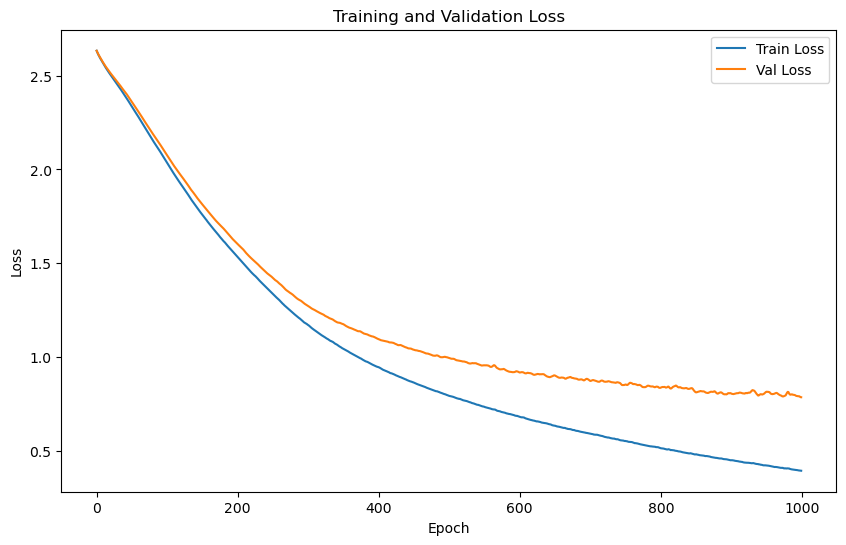

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7850 | Test Accuracy: 76.23%


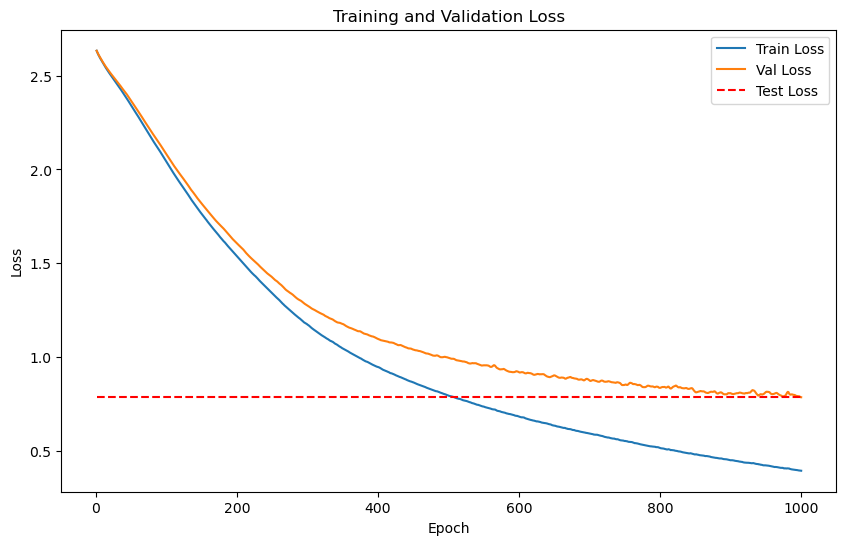

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.3109
Epoch [1/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.3914

Validation loss improved from inf to 0.3914. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.3132
Epoch [2/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.3925

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.3156
Epoch [3/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.3936

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3179
Epoch [4/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.3947

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.3219
Epoch [5/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.3968

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.3270
Epoch [6/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.3992

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.3336
Epoch [7/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4025

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.3415
Epoch [8/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4063

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.3496
Epoch [9/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.4101

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.3574
Epoch [10/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.4138

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.3653
Epoch [11/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4175

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.3679
Epoch [12/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4189

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.3702
Epoch [13/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.4201

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.3730
Epoch [14/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4218

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4716
    Batch [2/2], Val Loss: 0.3763
Epoch [15/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4239

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.3772
Epoch [16/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4248

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.3776
Epoch [17/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4250

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4726
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.3731
Epoch [18/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4226

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.3651
Epoch [19/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.4184

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4650
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.3551
Epoch [20/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4128

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.3449
Epoch [21/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.4072

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.3351
Epoch [22/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4016

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.3266
Epoch [23/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.3961

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.3193
Epoch [24/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.3911

Validation loss improved from 0.3914 to 0.3911. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4629
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.3115
Epoch [25/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.3858

Validation loss improved from 0.3911 to 0.3858. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.3034
Epoch [26/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.3803

Validation loss improved from 0.3858 to 0.3803. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.2967
Epoch [27/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.3756

Validation loss improved from 0.3803 to 0.3756. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.2898
Epoch [28/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3708

Validation loss improved from 0.3756 to 0.3708. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2822
Epoch [29/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3657

Validation loss improved from 0.3708 to 0.3657. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.2758
Epoch [30/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.3616

Validation loss improved from 0.3657 to 0.3616. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4458
    Batch [2/2], Val Loss: 0.2702
Epoch [31/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.3580

Validation loss improved from 0.3616 to 0.3580. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.2660
Epoch [32/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3551

Validation loss improved from 0.3580 to 0.3551. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.2646
Epoch [33/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.3534

Validation loss improved from 0.3551 to 0.3534. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.2643
Epoch [34/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3522

Validation loss improved from 0.3534 to 0.3522. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.2636
Epoch [35/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3508

Validation loss improved from 0.3522 to 0.3508. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.2639
Epoch [36/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3500

Validation loss improved from 0.3508 to 0.3500. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.2637
Epoch [37/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3489

Validation loss improved from 0.3500 to 0.3489. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.2632
Epoch [38/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.3479

Validation loss improved from 0.3489 to 0.3479. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.2626
Epoch [39/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.3470

Validation loss improved from 0.3479 to 0.3470. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.2626
Epoch [40/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.3465

Validation loss improved from 0.3470 to 0.3465. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.2628
Epoch [41/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3462

Validation loss improved from 0.3465 to 0.3462. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.2627
Epoch [42/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.3457

Validation loss improved from 0.3462 to 0.3457. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.2629
Epoch [43/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.3454

Validation loss improved from 0.3457 to 0.3454. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.2632
Epoch [44/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3451

Validation loss improved from 0.3454 to 0.3451. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.2632
Epoch [45/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3448

Validation loss improved from 0.3451 to 0.3448. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.2630
Epoch [46/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.3443

Validation loss improved from 0.3448 to 0.3443. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.2627
Epoch [47/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3439

Validation loss improved from 0.3443 to 0.3439. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.2626
Epoch [48/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3434

Validation loss improved from 0.3439 to 0.3434. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.2627
Epoch [49/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3430

Validation loss improved from 0.3434 to 0.3430. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.2626
Epoch [50/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3425

Validation loss improved from 0.3430 to 0.3425. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4213
    Batch [2/2], Val Loss: 0.2628
Epoch [51/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3420

Validation loss improved from 0.3425 to 0.3420. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.2632
Epoch [52/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.3417

Validation loss improved from 0.3420 to 0.3417. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.2633
Epoch [53/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.3412

Validation loss improved from 0.3417 to 0.3412. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.2636
Epoch [54/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3409

Validation loss improved from 0.3412 to 0.3409. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.2641
Epoch [55/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3407

Validation loss improved from 0.3409 to 0.3407. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.2643
Epoch [56/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3403

Validation loss improved from 0.3407 to 0.3403. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.2642
Epoch [57/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3397

Validation loss improved from 0.3403 to 0.3397. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4145
    Batch [2/2], Val Loss: 0.2643
Epoch [58/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3394

Validation loss improved from 0.3397 to 0.3394. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.2642
Epoch [59/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3390

Validation loss improved from 0.3394 to 0.3390. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.2641
Epoch [60/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3386

Validation loss improved from 0.3390 to 0.3386. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.2643
Epoch [61/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3383

Validation loss improved from 0.3386 to 0.3383. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.2647
Epoch [62/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3380

Validation loss improved from 0.3383 to 0.3380. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.2652
Epoch [63/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3378

Validation loss improved from 0.3380 to 0.3378. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.2654
Epoch [64/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3374

Validation loss improved from 0.3378 to 0.3374. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.2658
Epoch [65/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3372

Validation loss improved from 0.3374 to 0.3372. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4079
    Batch [2/2], Val Loss: 0.2662
Epoch [66/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3370

Validation loss improved from 0.3372 to 0.3370. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.2667
Epoch [67/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3371

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.2677
Epoch [68/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3376

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.2685
Epoch [69/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3381

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.2686
Epoch [70/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.4088
    Batch [2/2], Val Loss: 0.2692
Epoch [71/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3390

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.2699
Epoch [72/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.3397

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.2707
Epoch [73/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.3404

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [74/2000] - Validation


    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.2709
Epoch [74/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.2703
Epoch [75/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3404

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.2696
Epoch [76/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3400

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.2695
Epoch [77/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3398

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.2695
Epoch [78/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.3396

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.2683
Epoch [79/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3387

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.2681
Epoch [80/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3382

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.4076
    Batch [2/2], Val Loss: 0.2691
Epoch [81/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [82/2000] - Validation


    Batch [1/2], Val Loss: 0.4068
    Batch [2/2], Val Loss: 0.2699
Epoch [82/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3383

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [83/2000] - Validation


    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.2704
Epoch [83/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.2689
Epoch [84/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.3366

Validation loss improved from 0.3370 to 0.3366. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.2672
Epoch [85/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.3351

Validation loss improved from 0.3366 to 0.3351. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.2660
Epoch [86/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.3338

Validation loss improved from 0.3351 to 0.3338. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4008
    Batch [2/2], Val Loss: 0.2660
Epoch [87/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3334

Validation loss improved from 0.3338 to 0.3334. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.2665
Epoch [88/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.2674
Epoch [89/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.3339

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.2683
Epoch [90/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.3341

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.2688
Epoch [91/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.2694
Epoch [92/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3345

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.2697
Epoch [93/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3345

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.2695
Epoch [94/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3344

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.2680
Epoch [95/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3339

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.2663
Epoch [96/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3333

Validation loss improved from 0.3334 to 0.3333. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.2652
Epoch [97/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.3326

Validation loss improved from 0.3333 to 0.3326. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.2642
Epoch [98/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3320

Validation loss improved from 0.3326 to 0.3320. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.2628
Epoch [99/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3312

Validation loss improved from 0.3320 to 0.3312. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.2607
Epoch [100/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3301

Validation loss improved from 0.3312 to 0.3301. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.2601
Epoch [101/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3298

Validation loss improved from 0.3301 to 0.3298. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.2599
Epoch [102/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3296

Validation loss improved from 0.3298 to 0.3296. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.2590
Epoch [103/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3287

Validation loss improved from 0.3296 to 0.3287. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.2585
Epoch [104/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3278

Validation loss improved from 0.3287 to 0.3278. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3965
    Batch [2/2], Val Loss: 0.2567
Epoch [105/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3266

Validation loss improved from 0.3278 to 0.3266. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.2549
Epoch [106/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.3255

Validation loss improved from 0.3266 to 0.3255. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.2518
Epoch [107/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3238

Validation loss improved from 0.3255 to 0.3238. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.2485
Epoch [108/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3224

Validation loss improved from 0.3238 to 0.3224. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.2446
Epoch [109/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3207

Validation loss improved from 0.3224 to 0.3207. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.2424
Epoch [110/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.3196

Validation loss improved from 0.3207 to 0.3196. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.2435
Epoch [111/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.3203

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.2448
Epoch [112/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3208

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.2463
Epoch [113/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3217

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.2482
Epoch [114/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3228

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.2503
Epoch [115/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3242

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.2519
Epoch [116/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3253

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3991
    Batch [2/2], Val Loss: 0.2532
Epoch [117/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3261

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.2548
Epoch [118/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.2554
Epoch [119/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3274

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.3991
    Batch [2/2], Val Loss: 0.2555
Epoch [120/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.3273

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.3986
    Batch [2/2], Val Loss: 0.2556
Epoch [121/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3271

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.2553
Epoch [122/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3264

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.2549
Epoch [123/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3255

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.3953
    Batch [2/2], Val Loss: 0.2549
Epoch [124/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3251

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.3947
    Batch [2/2], Val Loss: 0.2548
Epoch [125/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.3248

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.2531
Epoch [126/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3236

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.2515
Epoch [127/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3220

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.2493
Epoch [128/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.3200

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.2463
Epoch [129/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3174

Validation loss improved from 0.3196 to 0.3174. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.2428
Epoch [130/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3146

Validation loss improved from 0.3174 to 0.3146. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.3846
    Batch [2/2], Val Loss: 0.2394
Epoch [131/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3120

Validation loss improved from 0.3146 to 0.3120. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.2362
Epoch [132/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3099

Validation loss improved from 0.3120 to 0.3099. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.2333
Epoch [133/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3079

Validation loss improved from 0.3099 to 0.3079. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.2303
Epoch [134/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.3060

Validation loss improved from 0.3079 to 0.3060. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.2277
Epoch [135/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3041

Validation loss improved from 0.3060 to 0.3041. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.3793
    Batch [2/2], Val Loss: 0.2250
Epoch [136/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3022

Validation loss improved from 0.3041 to 0.3022. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.2222
Epoch [137/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.3003

Validation loss improved from 0.3022 to 0.3003. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.3776
    Batch [2/2], Val Loss: 0.2200
Epoch [138/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2988

Validation loss improved from 0.3003 to 0.2988. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.2182
Epoch [139/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2968

Validation loss improved from 0.2988 to 0.2968. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.3726
    Batch [2/2], Val Loss: 0.2169
Epoch [140/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2947

Validation loss improved from 0.2968 to 0.2947. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.3710
    Batch [2/2], Val Loss: 0.2163
Epoch [141/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2936

Validation loss improved from 0.2947 to 0.2936. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.3694
    Batch [2/2], Val Loss: 0.2166
Epoch [142/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.2930

Validation loss improved from 0.2936 to 0.2930. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.2165
Epoch [143/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2922

Validation loss improved from 0.2930 to 0.2922. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.2150
Epoch [144/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2908

Validation loss improved from 0.2922 to 0.2908. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.2139
Epoch [145/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2894

Validation loss improved from 0.2908 to 0.2894. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.2136
Epoch [146/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2891

Validation loss improved from 0.2894 to 0.2891. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.2141
Epoch [147/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2896

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.2143
Epoch [148/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2899

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.2142
Epoch [149/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2903

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.2134
Epoch [150/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.3690
    Batch [2/2], Val Loss: 0.2140
Epoch [151/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.3703
    Batch [2/2], Val Loss: 0.2134
Epoch [152/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2919

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.2130
Epoch [153/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.3708
    Batch [2/2], Val Loss: 0.2131
Epoch [154/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2919

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.3706
    Batch [2/2], Val Loss: 0.2120
Epoch [155/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2913

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.2122
Epoch [156/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2912

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.2131
Epoch [157/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.2140
Epoch [158/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.2147
Epoch [159/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.3718
    Batch [2/2], Val Loss: 0.2166
Epoch [160/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2942

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.3717
    Batch [2/2], Val Loss: 0.2191
Epoch [161/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.2225
Epoch [162/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.3738
    Batch [2/2], Val Loss: 0.2251
Epoch [163/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2995

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.2267
Epoch [164/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.2274
Epoch [165/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.3015

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.2267
Epoch [166/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.3012

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.2247
Epoch [167/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3000

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.2233
Epoch [168/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2990

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.2221
Epoch [169/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2981

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.3732
    Batch [2/2], Val Loss: 0.2216
Epoch [170/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.3726
    Batch [2/2], Val Loss: 0.2204
Epoch [171/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2965

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.3724
    Batch [2/2], Val Loss: 0.2176
Epoch [172/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2950

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.3706
    Batch [2/2], Val Loss: 0.2131
Epoch [173/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2919

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.2091
Epoch [174/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2889

Validation loss improved from 0.2891 to 0.2889. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.3665
    Batch [2/2], Val Loss: 0.2059
Epoch [175/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2862

Validation loss improved from 0.2889 to 0.2862. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.2028
Epoch [176/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2835

Validation loss improved from 0.2862 to 0.2835. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.2002
Epoch [177/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.2808

Validation loss improved from 0.2835 to 0.2808. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.3589
    Batch [2/2], Val Loss: 0.1978
Epoch [178/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2783

Validation loss improved from 0.2808 to 0.2783. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.3566
    Batch [2/2], Val Loss: 0.1956
Epoch [179/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2761

Validation loss improved from 0.2783 to 0.2761. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.3547
    Batch [2/2], Val Loss: 0.1934
Epoch [180/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2740

Validation loss improved from 0.2761 to 0.2740. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.3533
    Batch [2/2], Val Loss: 0.1916
Epoch [181/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2724

Validation loss improved from 0.2740 to 0.2724. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.3523
    Batch [2/2], Val Loss: 0.1900
Epoch [182/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2711

Validation loss improved from 0.2724 to 0.2711. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.3515
    Batch [2/2], Val Loss: 0.1885
Epoch [183/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2700

Validation loss improved from 0.2711 to 0.2700. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.3511
    Batch [2/2], Val Loss: 0.1875
Epoch [184/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2693

Validation loss improved from 0.2700 to 0.2693. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1868
Epoch [185/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2688

Validation loss improved from 0.2693 to 0.2688. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1861
Epoch [186/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2683

Validation loss improved from 0.2688 to 0.2683. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.3504
    Batch [2/2], Val Loss: 0.1853
Epoch [187/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2679

Validation loss improved from 0.2683 to 0.2679. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3503
    Batch [2/2], Val Loss: 0.1846
Epoch [188/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2674

Validation loss improved from 0.2679 to 0.2674. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.3501
    Batch [2/2], Val Loss: 0.1839
Epoch [189/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2670

Validation loss improved from 0.2674 to 0.2670. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1833
Epoch [190/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2667

Validation loss improved from 0.2670 to 0.2667. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1828
Epoch [191/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2664

Validation loss improved from 0.2667 to 0.2664. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1823
Epoch [192/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2662

Validation loss improved from 0.2664 to 0.2662. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1821
Epoch [193/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1816
Epoch [194/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2658

Validation loss improved from 0.2661 to 0.2658. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3501
    Batch [2/2], Val Loss: 0.1814
Epoch [195/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1812
Epoch [196/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2656

Validation loss improved from 0.2658 to 0.2656. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3499
    Batch [2/2], Val Loss: 0.1808
Epoch [197/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2654

Validation loss improved from 0.2656 to 0.2654. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3499
    Batch [2/2], Val Loss: 0.1803
Epoch [198/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2651

Validation loss improved from 0.2654 to 0.2651. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3499
    Batch [2/2], Val Loss: 0.1799
Epoch [199/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.2649

Validation loss improved from 0.2651 to 0.2649. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3497
    Batch [2/2], Val Loss: 0.1795
Epoch [200/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2646

Validation loss improved from 0.2649 to 0.2646. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3497
    Batch [2/2], Val Loss: 0.1792
Epoch [201/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2645

Validation loss improved from 0.2646 to 0.2645. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3497
    Batch [2/2], Val Loss: 0.1790
Epoch [202/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2643

Validation loss improved from 0.2645 to 0.2643. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3496
    Batch [2/2], Val Loss: 0.1788
Epoch [203/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1787
Epoch [204/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1786
Epoch [205/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2641

Validation loss improved from 0.2641 to 0.2641. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1784
Epoch [206/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2639

Validation loss improved from 0.2641 to 0.2639. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1781
Epoch [207/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1779
Epoch [208/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3494
    Batch [2/2], Val Loss: 0.1778
Epoch [209/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2636

Validation loss improved from 0.2637 to 0.2636. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3492
    Batch [2/2], Val Loss: 0.1776
Epoch [210/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2634

Validation loss improved from 0.2636 to 0.2634. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1773
Epoch [211/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1772
Epoch [212/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2630

Validation loss improved from 0.2632 to 0.2630. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1771
Epoch [213/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1771
Epoch [214/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2627

Validation loss improved from 0.2629 to 0.2627. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1770
Epoch [215/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2625

Validation loss improved from 0.2627 to 0.2625. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1768
Epoch [216/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1767
Epoch [217/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2622

Validation loss improved from 0.2624 to 0.2622. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3476
    Batch [2/2], Val Loss: 0.1765
Epoch [218/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3476
    Batch [2/2], Val Loss: 0.1764
Epoch [219/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.1762
Epoch [220/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2619

Validation loss improved from 0.2620 to 0.2619. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.1761
Epoch [221/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2618

Validation loss improved from 0.2619 to 0.2618. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.1762
Epoch [222/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2618

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3474
    Batch [2/2], Val Loss: 0.1761
Epoch [223/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1760
Epoch [224/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.3471
    Batch [2/2], Val Loss: 0.1759
Epoch [225/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2615

Validation loss improved from 0.2616 to 0.2615. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1758
Epoch [226/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1757
Epoch [227/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1756
Epoch [228/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1754
Epoch [229/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1754
Epoch [230/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2611

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1753
Epoch [231/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2611

Validation loss improved from 0.2611 to 0.2611. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1752
Epoch [232/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1750
Epoch [233/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1748
Epoch [234/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2609

Validation loss improved from 0.2609 to 0.2609. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1747
Epoch [235/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1746
Epoch [236/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1746
Epoch [237/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1746
Epoch [238/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1746
Epoch [239/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2607

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1747
Epoch [240/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1747
Epoch [241/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2608

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1749
Epoch [242/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1751
Epoch [243/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1751
Epoch [244/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1751
Epoch [245/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1750
Epoch [246/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1750
Epoch [247/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1749
Epoch [248/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2610

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1748
Epoch [249/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2609

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1746
Epoch [250/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1745
Epoch [251/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.1744
Epoch [252/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2605

Validation loss improved from 0.2607 to 0.2605. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3466
    Batch [2/2], Val Loss: 0.1742
Epoch [253/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.1740
Epoch [254/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.1738
Epoch [255/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2601

Validation loss improved from 0.2603 to 0.2601. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.1735
Epoch [256/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.1733
Epoch [257/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3466
    Batch [2/2], Val Loss: 0.1731
Epoch [258/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2599

Validation loss improved from 0.2599 to 0.2599. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.1730
Epoch [259/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.1727
Epoch [260/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.1726
Epoch [261/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.1725
Epoch [262/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2596

Validation loss improved from 0.2596 to 0.2596. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1724
Epoch [263/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1724
Epoch [264/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1723
Epoch [265/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2596

Validation loss improved from 0.2596 to 0.2596. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1723
Epoch [266/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1723
Epoch [267/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.3471
    Batch [2/2], Val Loss: 0.1722
Epoch [268/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1723
Epoch [269/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.1723
Epoch [270/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3474
    Batch [2/2], Val Loss: 0.1723
Epoch [271/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3474
    Batch [2/2], Val Loss: 0.1724
Epoch [272/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2599

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.1723
Epoch [273/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2598

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.1721
Epoch [274/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2597

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1720
Epoch [275/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1719
Epoch [276/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2596

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1718
Epoch [277/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3471
    Batch [2/2], Val Loss: 0.1717
Epoch [278/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2594

Validation loss improved from 0.2595 to 0.2594. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1717
Epoch [279/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1716
Epoch [280/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2593

Validation loss improved from 0.2593 to 0.2593. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1715
Epoch [281/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.1716
Epoch [282/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3466
    Batch [2/2], Val Loss: 0.1716
Epoch [283/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2591

Validation loss improved from 0.2591 to 0.2591. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3464
    Batch [2/2], Val Loss: 0.1715
Epoch [284/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.1714
Epoch [285/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.1715
Epoch [286/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3462
    Batch [2/2], Val Loss: 0.1715
Epoch [287/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3461
    Batch [2/2], Val Loss: 0.1715
Epoch [288/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2588

Validation loss improved from 0.2588 to 0.2588. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3459
    Batch [2/2], Val Loss: 0.1715
Epoch [289/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.1716
Epoch [290/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.1717
Epoch [291/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.1717
Epoch [292/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3457
    Batch [2/2], Val Loss: 0.1717
Epoch [293/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.1716
Epoch [294/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.1716
Epoch [295/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.1718
Epoch [296/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3457
    Batch [2/2], Val Loss: 0.1719
Epoch [297/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2588

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3457
    Batch [2/2], Val Loss: 0.1721
Epoch [298/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3456
    Batch [2/2], Val Loss: 0.1724
Epoch [299/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3455
    Batch [2/2], Val Loss: 0.1725
Epoch [300/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3454
    Batch [2/2], Val Loss: 0.1725
Epoch [301/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.2590

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3452
    Batch [2/2], Val Loss: 0.1725
Epoch [302/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2589

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3450
    Batch [2/2], Val Loss: 0.1724
Epoch [303/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2587

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3449
    Batch [2/2], Val Loss: 0.1723
Epoch [304/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1724
Epoch [305/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1723
Epoch [306/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1722
Epoch [307/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2583

Validation loss improved from 0.2585 to 0.2583. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1722
Epoch [308/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2583

Validation loss improved from 0.2583 to 0.2583. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1721
Epoch [309/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1721
Epoch [310/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1720
Epoch [311/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1718
Epoch [312/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1716
Epoch [313/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1716
Epoch [314/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1714
Epoch [315/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1713
Epoch [316/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1711
Epoch [317/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2577

Validation loss improved from 0.2577 to 0.2577. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1711
Epoch [318/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2577

Validation loss improved from 0.2577 to 0.2577. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1711
Epoch [319/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1710
Epoch [320/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1707
Epoch [321/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1705
Epoch [322/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1703
Epoch [323/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2573

Validation loss improved from 0.2575 to 0.2573. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1701
Epoch [324/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2573

Validation loss improved from 0.2573 to 0.2573. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1700
Epoch [325/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1698
Epoch [326/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1697
Epoch [327/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2571

Validation loss improved from 0.2571 to 0.2571. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1694
Epoch [328/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1693
Epoch [329/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1692
Epoch [330/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2569

Validation loss improved from 0.2569 to 0.2569. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1692
Epoch [331/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1693
Epoch [332/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1694
Epoch [333/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1694
Epoch [334/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1696
Epoch [335/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1697
Epoch [336/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1698
Epoch [337/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1699
Epoch [338/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1701
Epoch [339/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1702
Epoch [340/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1704
Epoch [341/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1705
Epoch [342/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1705
Epoch [343/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1706
Epoch [344/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1707
Epoch [345/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1708
Epoch [346/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1709
Epoch [347/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1710
Epoch [348/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1710
Epoch [349/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1711
Epoch [350/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2578

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1710
Epoch [351/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2577

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1709
Epoch [352/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1708
Epoch [353/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2576

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1707
Epoch [354/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2575

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1706
Epoch [355/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2574

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1703
Epoch [356/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.2573

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1701
Epoch [357/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2572

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1700
Epoch [358/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2571

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1698
Epoch [359/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1697
Epoch [360/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2569

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1696
Epoch [361/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2569

Validation loss improved from 0.2569 to 0.2569. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1695
Epoch [362/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1694
Epoch [363/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1693
Epoch [364/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2567

Validation loss improved from 0.2567 to 0.2567. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1692
Epoch [365/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2567

Validation loss improved from 0.2567 to 0.2567. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1692
Epoch [366/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1691
Epoch [367/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1690
Epoch [368/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1690
Epoch [369/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1689
Epoch [370/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1689
Epoch [371/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1688
Epoch [372/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2565

Validation loss improved from 0.2565 to 0.2565. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1688
Epoch [373/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1688
Epoch [374/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1688
Epoch [375/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1687
Epoch [376/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1687
Epoch [377/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1687
Epoch [378/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1687
Epoch [379/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [380/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [381/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [382/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [383/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [384/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [385/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [386/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [387/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [388/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [389/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [390/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [391/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [392/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [393/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [394/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [395/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [396/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [397/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [398/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [399/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [400/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1686
Epoch [401/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1685
Epoch [402/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1685
Epoch [403/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1685
Epoch [404/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1685
Epoch [405/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [406/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [407/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [408/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [409/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [410/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [411/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [412/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [413/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [414/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [415/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [416/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [417/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [418/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1685
Epoch [419/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1685
Epoch [420/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1685
Epoch [421/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [422/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [423/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [424/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [425/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1684
Epoch [426/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1683
Epoch [427/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1683
Epoch [428/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1683
Epoch [429/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1683
Epoch [430/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1683
Epoch [431/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1683
Epoch [432/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [433/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [434/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [435/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [436/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [437/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [438/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [439/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [440/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [441/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [442/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [443/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [444/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [445/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [446/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [447/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [448/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [449/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [450/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [451/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [452/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1683
Epoch [453/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1683
Epoch [454/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1683
Epoch [455/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1683
Epoch [456/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1683
Epoch [457/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1683
Epoch [458/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [459/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [460/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [461/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [462/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [463/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1683
Epoch [464/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1683
Epoch [465/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [466/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [467/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [468/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [469/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2561

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [470/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1682
Epoch [471/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [472/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [473/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [474/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [475/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [476/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [477/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [478/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [479/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [480/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [481/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [482/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [483/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1683
Epoch [484/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1683
Epoch [485/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1683
Epoch [486/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1683
Epoch [487/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [488/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [489/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [490/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1682
Epoch [491/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [492/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [493/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [494/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [495/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [496/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [497/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [498/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [499/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [500/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [501/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [502/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [503/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2559

Validation loss improved from 0.2559 to 0.2559. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [504/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [505/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [506/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [507/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [508/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [509/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [510/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [511/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [512/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [513/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1682
Epoch [514/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [515/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1681
Epoch [516/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [517/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [518/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [519/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [520/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [521/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [522/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [523/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [524/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [525/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [526/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [527/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [528/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2560

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [529/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [530/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [531/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [532/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [533/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [534/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [535/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [536/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [537/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [538/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [539/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [540/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [541/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1681
Epoch [542/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [543/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [544/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [545/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [546/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [547/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [548/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [549/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [550/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1680
Epoch [551/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [552/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [553/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [554/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [555/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [556/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [557/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [558/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [559/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [560/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [561/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [562/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [563/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [564/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [565/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [566/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [567/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [568/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [569/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [570/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [571/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [572/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [573/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [574/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [575/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [576/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [577/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [578/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [579/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [580/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [581/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [582/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [583/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [584/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [585/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [586/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [587/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [588/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [589/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [590/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [591/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [592/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [593/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [594/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [595/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [596/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [597/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [598/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [599/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [600/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [601/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [602/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1680
Epoch [603/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2559

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 603!!
No improvement for 100 epochs


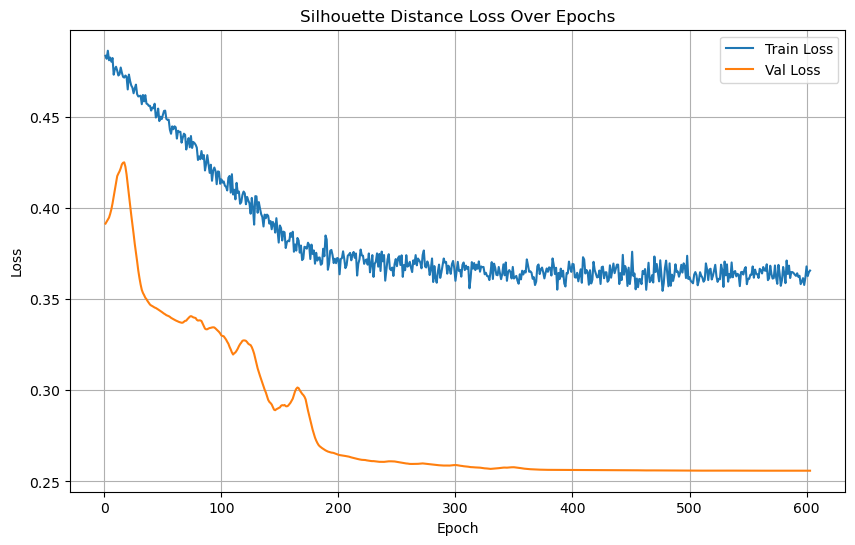

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/48], Loss: 0.2752


Test Batch [20/48], Loss: 0.2004
Test Batch [30/48], Loss: 0.2117
Test Batch [40/48], Loss: 0.5000

Test Loss: 0.2687


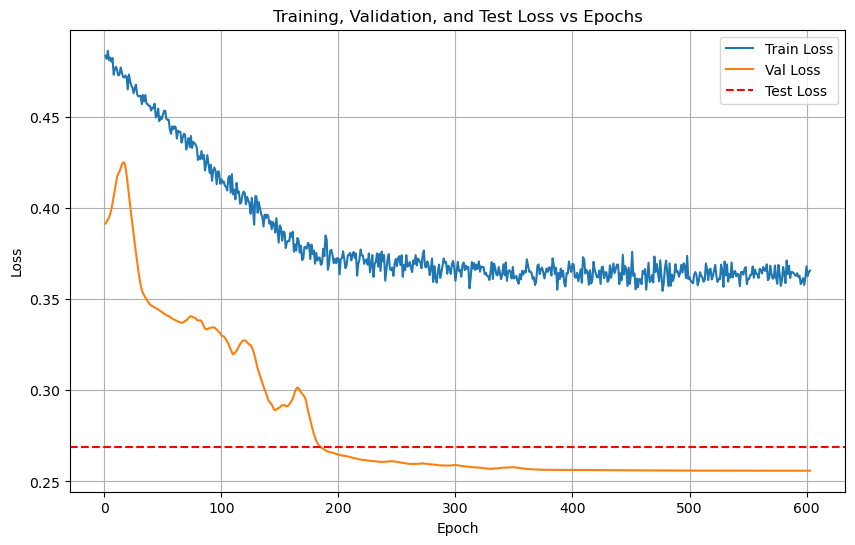

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/48 for test dataset.
  Processed batch 20/48 for test dataset.


  Processed batch 30/48 for test dataset.
  Processed batch 40/48 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       0.71      1.00      0.83         5
           4       0.50      0.40      0.44         5
           5       1.00      0.40      0.57         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.67      0.80      0.73         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       0.71      1.00      0.83         5
          12       0.62      1.00      0.77         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6721  |  Val Loss: 2.6361
Validation loss improved from inf to 2.6361.
[Epoch 2/1000] Train Loss: 2.6586  |  Val Loss: 2.6267
Validation loss improved from 2.6361 to 2.6267.
[Epoch 3/1000] Train Loss: 2.6462  |  Val Loss: 2.6174
Validation loss improved from 2.6267 to 2.6174.
[Epoch 4/1000] Train Loss: 2.6343  |  Val Loss: 2.6078
Validation loss improved from 2.6174 to 2.6078.
[Epoch 5/1000] Train Loss: 2.6227  |  Val Loss: 2.5983
Validation loss improved from 2.6078 to 2.5983.
[Epoch 6/1000] Train Loss: 2.6107  |  Val Loss: 2.5892
Validation loss improved from 2.5983 to 2.5892.
[Epoch 7/1000] Train Loss: 2.5995  |  Val Loss: 2.5797
Validation loss improved from 2.5892 to 2.5797.
[Epoch 8/1000] Train Loss: 2.5885  |  Val Loss: 2.5701
Validation loss improved from 2.5797 to 2.5701.
[Epoch 9/1000] Train Loss: 2.5770  |  Val Loss: 2.5602
Validation loss improved from 2.5701 to 2.5602.
[Epoch 10/1000] Train Loss: 2.5653  |  Val Loss: 2.5506
Validation loss impr

[Epoch 20/1000] Train Loss: 2.4654  |  Val Loss: 2.4664
Validation loss improved from 2.4741 to 2.4664.
[Epoch 21/1000] Train Loss: 2.4563  |  Val Loss: 2.4591
Validation loss improved from 2.4664 to 2.4591.
[Epoch 22/1000] Train Loss: 2.4470  |  Val Loss: 2.4519
Validation loss improved from 2.4591 to 2.4519.
[Epoch 23/1000] Train Loss: 2.4385  |  Val Loss: 2.4446
Validation loss improved from 2.4519 to 2.4446.
[Epoch 24/1000] Train Loss: 2.4298  |  Val Loss: 2.4374
Validation loss improved from 2.4446 to 2.4374.


[Epoch 25/1000] Train Loss: 2.4211  |  Val Loss: 2.4301
Validation loss improved from 2.4374 to 2.4301.


[Epoch 26/1000] Train Loss: 2.4121  |  Val Loss: 2.4231
Validation loss improved from 2.4301 to 2.4231.
[Epoch 27/1000] Train Loss: 2.4037  |  Val Loss: 2.4161
Validation loss improved from 2.4231 to 2.4161.
[Epoch 28/1000] Train Loss: 2.3950  |  Val Loss: 2.4091
Validation loss improved from 2.4161 to 2.4091.
[Epoch 29/1000] Train Loss: 2.3862  |  Val Loss: 2.4021
Validation loss improved from 2.4091 to 2.4021.
[Epoch 30/1000] Train Loss: 2.3776  |  Val Loss: 2.3950
Validation loss improved from 2.4021 to 2.3950.
[Epoch 31/1000] Train Loss: 2.3690  |  Val Loss: 2.3877
Validation loss improved from 2.3950 to 2.3877.
[Epoch 32/1000] Train Loss: 2.3605  |  Val Loss: 2.3800
Validation loss improved from 2.3877 to 2.3800.
[Epoch 33/1000] Train Loss: 2.3514  |  Val Loss: 2.3725
Validation loss improved from 2.3800 to 2.3725.
[Epoch 34/1000] Train Loss: 2.3426  |  Val Loss: 2.3649
Validation loss improved from 2.3725 to 2.3649.
[Epoch 35/1000] Train Loss: 2.3337  |  Val Loss: 2.3575
Validati

[Epoch 50/1000] Train Loss: 2.1969  |  Val Loss: 2.2381
Validation loss improved from 2.2466 to 2.2381.
[Epoch 51/1000] Train Loss: 2.1874  |  Val Loss: 2.2298
Validation loss improved from 2.2381 to 2.2298.
[Epoch 52/1000] Train Loss: 2.1779  |  Val Loss: 2.2215
Validation loss improved from 2.2298 to 2.2215.
[Epoch 53/1000] Train Loss: 2.1685  |  Val Loss: 2.2130
Validation loss improved from 2.2215 to 2.2130.
[Epoch 54/1000] Train Loss: 2.1590  |  Val Loss: 2.2045
Validation loss improved from 2.2130 to 2.2045.
[Epoch 55/1000] Train Loss: 2.1495  |  Val Loss: 2.1959
Validation loss improved from 2.2045 to 2.1959.
[Epoch 56/1000] Train Loss: 2.1396  |  Val Loss: 2.1872
Validation loss improved from 2.1959 to 2.1872.


[Epoch 57/1000] Train Loss: 2.1300  |  Val Loss: 2.1785
Validation loss improved from 2.1872 to 2.1785.
[Epoch 58/1000] Train Loss: 2.1199  |  Val Loss: 2.1697
Validation loss improved from 2.1785 to 2.1697.
[Epoch 59/1000] Train Loss: 2.1099  |  Val Loss: 2.1608
Validation loss improved from 2.1697 to 2.1608.
[Epoch 60/1000] Train Loss: 2.0998  |  Val Loss: 2.1518
Validation loss improved from 2.1608 to 2.1518.
[Epoch 61/1000] Train Loss: 2.0897  |  Val Loss: 2.1426
Validation loss improved from 2.1518 to 2.1426.
[Epoch 62/1000] Train Loss: 2.0793  |  Val Loss: 2.1335
Validation loss improved from 2.1426 to 2.1335.
[Epoch 63/1000] Train Loss: 2.0688  |  Val Loss: 2.1242
Validation loss improved from 2.1335 to 2.1242.
[Epoch 64/1000] Train Loss: 2.0584  |  Val Loss: 2.1150
Validation loss improved from 2.1242 to 2.1150.
[Epoch 65/1000] Train Loss: 2.0478  |  Val Loss: 2.1057
Validation loss improved from 2.1150 to 2.1057.
[Epoch 66/1000] Train Loss: 2.0375  |  Val Loss: 2.0964
Validati

[Epoch 79/1000] Train Loss: 1.8912  |  Val Loss: 1.9645
Validation loss improved from 1.9751 to 1.9645.
[Epoch 80/1000] Train Loss: 1.8789  |  Val Loss: 1.9538
Validation loss improved from 1.9645 to 1.9538.
[Epoch 81/1000] Train Loss: 1.8670  |  Val Loss: 1.9430
Validation loss improved from 1.9538 to 1.9430.
[Epoch 82/1000] Train Loss: 1.8542  |  Val Loss: 1.9323
Validation loss improved from 1.9430 to 1.9323.
[Epoch 83/1000] Train Loss: 1.8420  |  Val Loss: 1.9213
Validation loss improved from 1.9323 to 1.9213.
[Epoch 84/1000] Train Loss: 1.8293  |  Val Loss: 1.9100
Validation loss improved from 1.9213 to 1.9100.
[Epoch 85/1000] Train Loss: 1.8166  |  Val Loss: 1.8984
Validation loss improved from 1.9100 to 1.8984.
[Epoch 86/1000] Train Loss: 1.8038  |  Val Loss: 1.8869
Validation loss improved from 1.8984 to 1.8869.
[Epoch 87/1000] Train Loss: 1.7904  |  Val Loss: 1.8755
Validation loss improved from 1.8869 to 1.8755.


[Epoch 88/1000] Train Loss: 1.7777  |  Val Loss: 1.8640
Validation loss improved from 1.8755 to 1.8640.
[Epoch 89/1000] Train Loss: 1.7647  |  Val Loss: 1.8527
Validation loss improved from 1.8640 to 1.8527.
[Epoch 90/1000] Train Loss: 1.7517  |  Val Loss: 1.8414
Validation loss improved from 1.8527 to 1.8414.
[Epoch 91/1000] Train Loss: 1.7387  |  Val Loss: 1.8302
Validation loss improved from 1.8414 to 1.8302.
[Epoch 92/1000] Train Loss: 1.7259  |  Val Loss: 1.8190
Validation loss improved from 1.8302 to 1.8190.
[Epoch 93/1000] Train Loss: 1.7127  |  Val Loss: 1.8080
Validation loss improved from 1.8190 to 1.8080.
[Epoch 94/1000] Train Loss: 1.6998  |  Val Loss: 1.7971
Validation loss improved from 1.8080 to 1.7971.
[Epoch 95/1000] Train Loss: 1.6868  |  Val Loss: 1.7859
Validation loss improved from 1.7971 to 1.7859.
[Epoch 96/1000] Train Loss: 1.6736  |  Val Loss: 1.7747
Validation loss improved from 1.7859 to 1.7747.
[Epoch 97/1000] Train Loss: 1.6601  |  Val Loss: 1.7632
Validati

[Epoch 109/1000] Train Loss: 1.4993  |  Val Loss: 1.6236
Validation loss improved from 1.6353 to 1.6236.
[Epoch 110/1000] Train Loss: 1.4860  |  Val Loss: 1.6123
Validation loss improved from 1.6236 to 1.6123.
[Epoch 111/1000] Train Loss: 1.4732  |  Val Loss: 1.6010
Validation loss improved from 1.6123 to 1.6010.
[Epoch 112/1000] Train Loss: 1.4600  |  Val Loss: 1.5898
Validation loss improved from 1.6010 to 1.5898.
[Epoch 113/1000] Train Loss: 1.4471  |  Val Loss: 1.5787
Validation loss improved from 1.5898 to 1.5787.
[Epoch 114/1000] Train Loss: 1.4341  |  Val Loss: 1.5677
Validation loss improved from 1.5787 to 1.5677.
[Epoch 115/1000] Train Loss: 1.4217  |  Val Loss: 1.5567
Validation loss improved from 1.5677 to 1.5567.
[Epoch 116/1000] Train Loss: 1.4086  |  Val Loss: 1.5455
Validation loss improved from 1.5567 to 1.5455.
[Epoch 117/1000] Train Loss: 1.3961  |  Val Loss: 1.5343
Validation loss improved from 1.5455 to 1.5343.


[Epoch 118/1000] Train Loss: 1.3832  |  Val Loss: 1.5232
Validation loss improved from 1.5343 to 1.5232.
[Epoch 119/1000] Train Loss: 1.3712  |  Val Loss: 1.5123
Validation loss improved from 1.5232 to 1.5123.
[Epoch 120/1000] Train Loss: 1.3585  |  Val Loss: 1.5014
Validation loss improved from 1.5123 to 1.5014.
[Epoch 121/1000] Train Loss: 1.3460  |  Val Loss: 1.4906
Validation loss improved from 1.5014 to 1.4906.
[Epoch 122/1000] Train Loss: 1.3341  |  Val Loss: 1.4800
Validation loss improved from 1.4906 to 1.4800.
[Epoch 123/1000] Train Loss: 1.3219  |  Val Loss: 1.4692
Validation loss improved from 1.4800 to 1.4692.
[Epoch 124/1000] Train Loss: 1.3098  |  Val Loss: 1.4584
Validation loss improved from 1.4692 to 1.4584.
[Epoch 125/1000] Train Loss: 1.2980  |  Val Loss: 1.4477
Validation loss improved from 1.4584 to 1.4477.
[Epoch 126/1000] Train Loss: 1.2860  |  Val Loss: 1.4368
Validation loss improved from 1.4477 to 1.4368.
[Epoch 127/1000] Train Loss: 1.2740  |  Val Loss: 1.426

[Epoch 141/1000] Train Loss: 1.1160  |  Val Loss: 1.2875
Validation loss improved from 1.2965 to 1.2875.
[Epoch 142/1000] Train Loss: 1.1052  |  Val Loss: 1.2786
Validation loss improved from 1.2875 to 1.2786.
[Epoch 143/1000] Train Loss: 1.0948  |  Val Loss: 1.2694
Validation loss improved from 1.2786 to 1.2694.
[Epoch 144/1000] Train Loss: 1.0840  |  Val Loss: 1.2604
Validation loss improved from 1.2694 to 1.2604.
[Epoch 145/1000] Train Loss: 1.0734  |  Val Loss: 1.2515
Validation loss improved from 1.2604 to 1.2515.
[Epoch 146/1000] Train Loss: 1.0633  |  Val Loss: 1.2427
Validation loss improved from 1.2515 to 1.2427.
[Epoch 147/1000] Train Loss: 1.0528  |  Val Loss: 1.2338
Validation loss improved from 1.2427 to 1.2338.
[Epoch 148/1000] Train Loss: 1.0424  |  Val Loss: 1.2247
Validation loss improved from 1.2338 to 1.2247.
[Epoch 149/1000] Train Loss: 1.0320  |  Val Loss: 1.2155
Validation loss improved from 1.2247 to 1.2155.


[Epoch 150/1000] Train Loss: 1.0216  |  Val Loss: 1.2060
Validation loss improved from 1.2155 to 1.2060.
[Epoch 151/1000] Train Loss: 1.0115  |  Val Loss: 1.1967
Validation loss improved from 1.2060 to 1.1967.
[Epoch 152/1000] Train Loss: 1.0013  |  Val Loss: 1.1876
Validation loss improved from 1.1967 to 1.1876.
[Epoch 153/1000] Train Loss: 0.9911  |  Val Loss: 1.1788
Validation loss improved from 1.1876 to 1.1788.
[Epoch 154/1000] Train Loss: 0.9811  |  Val Loss: 1.1697
Validation loss improved from 1.1788 to 1.1697.
[Epoch 155/1000] Train Loss: 0.9713  |  Val Loss: 1.1604
Validation loss improved from 1.1697 to 1.1604.
[Epoch 156/1000] Train Loss: 0.9616  |  Val Loss: 1.1512
Validation loss improved from 1.1604 to 1.1512.
[Epoch 157/1000] Train Loss: 0.9514  |  Val Loss: 1.1424
Validation loss improved from 1.1512 to 1.1424.
[Epoch 158/1000] Train Loss: 0.9420  |  Val Loss: 1.1336
Validation loss improved from 1.1424 to 1.1336.
[Epoch 159/1000] Train Loss: 0.9322  |  Val Loss: 1.125

[Epoch 171/1000] Train Loss: 0.8159  |  Val Loss: 1.0246
Validation loss improved from 1.0322 to 1.0246.
[Epoch 172/1000] Train Loss: 0.8065  |  Val Loss: 1.0171
Validation loss improved from 1.0246 to 1.0171.
[Epoch 173/1000] Train Loss: 0.7972  |  Val Loss: 1.0096
Validation loss improved from 1.0171 to 1.0096.
[Epoch 174/1000] Train Loss: 0.7879  |  Val Loss: 1.0019
Validation loss improved from 1.0096 to 1.0019.
[Epoch 175/1000] Train Loss: 0.7790  |  Val Loss: 0.9942
Validation loss improved from 1.0019 to 0.9942.
[Epoch 176/1000] Train Loss: 0.7700  |  Val Loss: 0.9862
Validation loss improved from 0.9942 to 0.9862.
[Epoch 177/1000] Train Loss: 0.7608  |  Val Loss: 0.9784
Validation loss improved from 0.9862 to 0.9784.
[Epoch 178/1000] Train Loss: 0.7522  |  Val Loss: 0.9704
Validation loss improved from 0.9784 to 0.9704.


[Epoch 179/1000] Train Loss: 0.7438  |  Val Loss: 0.9626
Validation loss improved from 0.9704 to 0.9626.
[Epoch 180/1000] Train Loss: 0.7353  |  Val Loss: 0.9550
Validation loss improved from 0.9626 to 0.9550.
[Epoch 181/1000] Train Loss: 0.7269  |  Val Loss: 0.9476
Validation loss improved from 0.9550 to 0.9476.
[Epoch 182/1000] Train Loss: 0.7185  |  Val Loss: 0.9404
Validation loss improved from 0.9476 to 0.9404.
[Epoch 183/1000] Train Loss: 0.7103  |  Val Loss: 0.9338
Validation loss improved from 0.9404 to 0.9338.
[Epoch 184/1000] Train Loss: 0.7024  |  Val Loss: 0.9275
Validation loss improved from 0.9338 to 0.9275.
[Epoch 185/1000] Train Loss: 0.6945  |  Val Loss: 0.9216
Validation loss improved from 0.9275 to 0.9216.
[Epoch 186/1000] Train Loss: 0.6870  |  Val Loss: 0.9157
Validation loss improved from 0.9216 to 0.9157.
[Epoch 187/1000] Train Loss: 0.6798  |  Val Loss: 0.9096
Validation loss improved from 0.9157 to 0.9096.
[Epoch 188/1000] Train Loss: 0.6722  |  Val Loss: 0.903

[Epoch 202/1000] Train Loss: 0.5713  |  Val Loss: 0.8170
Validation loss improved from 0.8227 to 0.8170.
[Epoch 203/1000] Train Loss: 0.5645  |  Val Loss: 0.8114
Validation loss improved from 0.8170 to 0.8114.
[Epoch 204/1000] Train Loss: 0.5579  |  Val Loss: 0.8060
Validation loss improved from 0.8114 to 0.8060.
[Epoch 205/1000] Train Loss: 0.5514  |  Val Loss: 0.8007
Validation loss improved from 0.8060 to 0.8007.
[Epoch 206/1000] Train Loss: 0.5450  |  Val Loss: 0.7954
Validation loss improved from 0.8007 to 0.7954.
[Epoch 207/1000] Train Loss: 0.5385  |  Val Loss: 0.7905
Validation loss improved from 0.7954 to 0.7905.
[Epoch 208/1000] Train Loss: 0.5323  |  Val Loss: 0.7857
Validation loss improved from 0.7905 to 0.7857.
[Epoch 209/1000] Train Loss: 0.5260  |  Val Loss: 0.7810
Validation loss improved from 0.7857 to 0.7810.


[Epoch 210/1000] Train Loss: 0.5200  |  Val Loss: 0.7762
Validation loss improved from 0.7810 to 0.7762.
[Epoch 211/1000] Train Loss: 0.5140  |  Val Loss: 0.7712
Validation loss improved from 0.7762 to 0.7712.
[Epoch 212/1000] Train Loss: 0.5082  |  Val Loss: 0.7660
Validation loss improved from 0.7712 to 0.7660.
[Epoch 213/1000] Train Loss: 0.5023  |  Val Loss: 0.7610
Validation loss improved from 0.7660 to 0.7610.
[Epoch 214/1000] Train Loss: 0.4964  |  Val Loss: 0.7558
Validation loss improved from 0.7610 to 0.7558.
[Epoch 215/1000] Train Loss: 0.4907  |  Val Loss: 0.7507
Validation loss improved from 0.7558 to 0.7507.
[Epoch 216/1000] Train Loss: 0.4849  |  Val Loss: 0.7460
Validation loss improved from 0.7507 to 0.7460.
[Epoch 217/1000] Train Loss: 0.4792  |  Val Loss: 0.7414
Validation loss improved from 0.7460 to 0.7414.
[Epoch 218/1000] Train Loss: 0.4733  |  Val Loss: 0.7368
Validation loss improved from 0.7414 to 0.7368.
[Epoch 219/1000] Train Loss: 0.4676  |  Val Loss: 0.732

[Epoch 229/1000] Train Loss: 0.4152  |  Val Loss: 0.6901
Validation loss improved from 0.6941 to 0.6901.
[Epoch 230/1000] Train Loss: 0.4103  |  Val Loss: 0.6864
Validation loss improved from 0.6901 to 0.6864.
[Epoch 231/1000] Train Loss: 0.4054  |  Val Loss: 0.6827
Validation loss improved from 0.6864 to 0.6827.
[Epoch 232/1000] Train Loss: 0.4005  |  Val Loss: 0.6789
Validation loss improved from 0.6827 to 0.6789.
[Epoch 233/1000] Train Loss: 0.3959  |  Val Loss: 0.6752
Validation loss improved from 0.6789 to 0.6752.
[Epoch 234/1000] Train Loss: 0.3913  |  Val Loss: 0.6718
Validation loss improved from 0.6752 to 0.6718.
[Epoch 235/1000] Train Loss: 0.3867  |  Val Loss: 0.6686
Validation loss improved from 0.6718 to 0.6686.


[Epoch 236/1000] Train Loss: 0.3824  |  Val Loss: 0.6654
Validation loss improved from 0.6686 to 0.6654.
[Epoch 237/1000] Train Loss: 0.3778  |  Val Loss: 0.6624
Validation loss improved from 0.6654 to 0.6624.
[Epoch 238/1000] Train Loss: 0.3733  |  Val Loss: 0.6599
Validation loss improved from 0.6624 to 0.6599.
[Epoch 239/1000] Train Loss: 0.3689  |  Val Loss: 0.6571
Validation loss improved from 0.6599 to 0.6571.
[Epoch 240/1000] Train Loss: 0.3645  |  Val Loss: 0.6539
Validation loss improved from 0.6571 to 0.6539.
[Epoch 241/1000] Train Loss: 0.3603  |  Val Loss: 0.6505
Validation loss improved from 0.6539 to 0.6505.
[Epoch 242/1000] Train Loss: 0.3560  |  Val Loss: 0.6474
Validation loss improved from 0.6505 to 0.6474.
[Epoch 243/1000] Train Loss: 0.3518  |  Val Loss: 0.6443
Validation loss improved from 0.6474 to 0.6443.
[Epoch 244/1000] Train Loss: 0.3479  |  Val Loss: 0.6411
Validation loss improved from 0.6443 to 0.6411.
[Epoch 245/1000] Train Loss: 0.3439  |  Val Loss: 0.637

[Epoch 260/1000] Train Loss: 0.2900  |  Val Loss: 0.5991
Validation loss improved from 0.6017 to 0.5991.
[Epoch 261/1000] Train Loss: 0.2867  |  Val Loss: 0.5961
Validation loss improved from 0.5991 to 0.5961.
[Epoch 262/1000] Train Loss: 0.2836  |  Val Loss: 0.5928
Validation loss improved from 0.5961 to 0.5928.
[Epoch 263/1000] Train Loss: 0.2806  |  Val Loss: 0.5896
Validation loss improved from 0.5928 to 0.5896.
[Epoch 264/1000] Train Loss: 0.2778  |  Val Loss: 0.5869
Validation loss improved from 0.5896 to 0.5869.
[Epoch 265/1000] Train Loss: 0.2749  |  Val Loss: 0.5851
Validation loss improved from 0.5869 to 0.5851.


[Epoch 266/1000] Train Loss: 0.2719  |  Val Loss: 0.5837
Validation loss improved from 0.5851 to 0.5837.
[Epoch 267/1000] Train Loss: 0.2687  |  Val Loss: 0.5821
Validation loss improved from 0.5837 to 0.5821.
[Epoch 268/1000] Train Loss: 0.2658  |  Val Loss: 0.5809
Validation loss improved from 0.5821 to 0.5809.
[Epoch 269/1000] Train Loss: 0.2628  |  Val Loss: 0.5796
Validation loss improved from 0.5809 to 0.5796.
[Epoch 270/1000] Train Loss: 0.2598  |  Val Loss: 0.5785
Validation loss improved from 0.5796 to 0.5785.
[Epoch 271/1000] Train Loss: 0.2570  |  Val Loss: 0.5775
Validation loss improved from 0.5785 to 0.5775.
[Epoch 272/1000] Train Loss: 0.2542  |  Val Loss: 0.5765
Validation loss improved from 0.5775 to 0.5765.
[Epoch 273/1000] Train Loss: 0.2514  |  Val Loss: 0.5750
Validation loss improved from 0.5765 to 0.5750.
[Epoch 274/1000] Train Loss: 0.2486  |  Val Loss: 0.5733
Validation loss improved from 0.5750 to 0.5733.
[Epoch 275/1000] Train Loss: 0.2459  |  Val Loss: 0.571

[Epoch 289/1000] Train Loss: 0.2123  |  Val Loss: 0.5478
Validation loss improved from 0.5489 to 0.5478.
[Epoch 290/1000] Train Loss: 0.2102  |  Val Loss: 0.5467
Validation loss improved from 0.5478 to 0.5467.
[Epoch 291/1000] Train Loss: 0.2082  |  Val Loss: 0.5456
Validation loss improved from 0.5467 to 0.5456.
[Epoch 292/1000] Train Loss: 0.2061  |  Val Loss: 0.5443
Validation loss improved from 0.5456 to 0.5443.
[Epoch 293/1000] Train Loss: 0.2040  |  Val Loss: 0.5431
Validation loss improved from 0.5443 to 0.5431.
[Epoch 294/1000] Train Loss: 0.2019  |  Val Loss: 0.5413
Validation loss improved from 0.5431 to 0.5413.
[Epoch 295/1000] Train Loss: 0.1999  |  Val Loss: 0.5397
Validation loss improved from 0.5413 to 0.5397.
[Epoch 296/1000] Train Loss: 0.1978  |  Val Loss: 0.5388
Validation loss improved from 0.5397 to 0.5388.
[Epoch 297/1000] Train Loss: 0.1958  |  Val Loss: 0.5377
Validation loss improved from 0.5388 to 0.5377.


[Epoch 298/1000] Train Loss: 0.1939  |  Val Loss: 0.5368
Validation loss improved from 0.5377 to 0.5368.
[Epoch 299/1000] Train Loss: 0.1919  |  Val Loss: 0.5360
Validation loss improved from 0.5368 to 0.5360.
[Epoch 300/1000] Train Loss: 0.1902  |  Val Loss: 0.5351
Validation loss improved from 0.5360 to 0.5351.
[Epoch 301/1000] Train Loss: 0.1883  |  Val Loss: 0.5338
Validation loss improved from 0.5351 to 0.5338.
[Epoch 302/1000] Train Loss: 0.1864  |  Val Loss: 0.5322
Validation loss improved from 0.5338 to 0.5322.
[Epoch 303/1000] Train Loss: 0.1848  |  Val Loss: 0.5310
Validation loss improved from 0.5322 to 0.5310.
[Epoch 304/1000] Train Loss: 0.1828  |  Val Loss: 0.5296
Validation loss improved from 0.5310 to 0.5296.
[Epoch 305/1000] Train Loss: 0.1811  |  Val Loss: 0.5282
Validation loss improved from 0.5296 to 0.5282.
[Epoch 306/1000] Train Loss: 0.1795  |  Val Loss: 0.5272
Validation loss improved from 0.5282 to 0.5272.
[Epoch 307/1000] Train Loss: 0.1778  |  Val Loss: 0.526

[Epoch 321/1000] Train Loss: 0.1552  |  Val Loss: 0.5114
Validation loss improved from 0.5118 to 0.5114.
[Epoch 322/1000] Train Loss: 0.1539  |  Val Loss: 0.5106
Validation loss improved from 0.5114 to 0.5106.
[Epoch 323/1000] Train Loss: 0.1524  |  Val Loss: 0.5097
Validation loss improved from 0.5106 to 0.5097.
[Epoch 324/1000] Train Loss: 0.1510  |  Val Loss: 0.5085
Validation loss improved from 0.5097 to 0.5085.
[Epoch 325/1000] Train Loss: 0.1496  |  Val Loss: 0.5074
Validation loss improved from 0.5085 to 0.5074.
[Epoch 326/1000] Train Loss: 0.1481  |  Val Loss: 0.5067
Validation loss improved from 0.5074 to 0.5067.
[Epoch 327/1000] Train Loss: 0.1469  |  Val Loss: 0.5059
Validation loss improved from 0.5067 to 0.5059.
[Epoch 328/1000] Train Loss: 0.1457  |  Val Loss: 0.5046
Validation loss improved from 0.5059 to 0.5046.
[Epoch 329/1000] Train Loss: 0.1444  |  Val Loss: 0.5034
Validation loss improved from 0.5046 to 0.5034.
[Epoch 330/1000] Train Loss: 0.1432  |  Val Loss: 0.502

[Epoch 332/1000] Train Loss: 0.1409  |  Val Loss: 0.5014
Validation loss improved from 0.5021 to 0.5014.
[Epoch 333/1000] Train Loss: 0.1396  |  Val Loss: 0.5009
Validation loss improved from 0.5014 to 0.5009.
[Epoch 334/1000] Train Loss: 0.1384  |  Val Loss: 0.5004
Validation loss improved from 0.5009 to 0.5004.
[Epoch 335/1000] Train Loss: 0.1372  |  Val Loss: 0.4997
Validation loss improved from 0.5004 to 0.4997.
[Epoch 336/1000] Train Loss: 0.1360  |  Val Loss: 0.4993
Validation loss improved from 0.4997 to 0.4993.
[Epoch 337/1000] Train Loss: 0.1349  |  Val Loss: 0.4998
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 338/1000] Train Loss: 0.1338  |  Val Loss: 0.4999
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 339/1000] Train Loss: 0.1325  |  Val Loss: 0.4997
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 340/1000] Train Loss: 0.1314  |  Val Loss: 0.4997
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 341/1000] Train Loss: 0.

[Epoch 351/1000] Train Loss: 0.1197  |  Val Loss: 0.4871
Validation loss improved from 0.4876 to 0.4871.
[Epoch 352/1000] Train Loss: 0.1187  |  Val Loss: 0.4870
Validation loss improved from 0.4871 to 0.4870.
[Epoch 353/1000] Train Loss: 0.1177  |  Val Loss: 0.4867
Validation loss improved from 0.4870 to 0.4867.
[Epoch 354/1000] Train Loss: 0.1167  |  Val Loss: 0.4862
Validation loss improved from 0.4867 to 0.4862.
[Epoch 355/1000] Train Loss: 0.1158  |  Val Loss: 0.4856
Validation loss improved from 0.4862 to 0.4856.
[Epoch 356/1000] Train Loss: 0.1149  |  Val Loss: 0.4854
Validation loss improved from 0.4856 to 0.4854.
[Epoch 357/1000] Train Loss: 0.1139  |  Val Loss: 0.4854
Validation loss improved from 0.4854 to 0.4854.
[Epoch 358/1000] Train Loss: 0.1128  |  Val Loss: 0.4862
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 359/1000] Train Loss: 0.1119  |  Val Loss: 0.4877
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 360/1000] Train Loss: 0.1111  |  Val

[Epoch 362/1000] Train Loss: 0.1094  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 363/1000] Train Loss: 0.1084  |  Val Loss: 0.4899
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 364/1000] Train Loss: 0.1076  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 365/1000] Train Loss: 0.1068  |  Val Loss: 0.4893
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 366/1000] Train Loss: 0.1059  |  Val Loss: 0.4884
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 367/1000] Train Loss: 0.1050  |  Val Loss: 0.4872
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 368/1000] Train Loss: 0.1042  |  Val Loss: 0.4866
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 369/1000] Train Loss: 0.1033  |  Val Loss: 0.4860
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 370/1000] Train Loss: 0.1025  |  Val Loss: 0.4855
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 382/1000] Train Loss: 0.0935  |  Val Loss: 0.4844
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 383/1000] Train Loss: 0.0927  |  Val Loss: 0.4854
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 384/1000] Train Loss: 0.0920  |  Val Loss: 0.4866
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 385/1000] Train Loss: 0.0913  |  Val Loss: 0.4874
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 386/1000] Train Loss: 0.0907  |  Val Loss: 0.4882
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 387/1000] Train Loss: 0.0901  |  Val Loss: 0.4890
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 388/1000] Train Loss: 0.0894  |  Val Loss: 0.4896
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 389/1000] Train Loss: 0.0888  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 390/1000] Train Loss: 0.0881  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 392/1000] Train Loss: 0.0867  |  Val Loss: 0.4890
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 393/1000] Train Loss: 0.0860  |  Val Loss: 0.4885
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 394/1000] Train Loss: 0.0854  |  Val Loss: 0.4876
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 395/1000] Train Loss: 0.0847  |  Val Loss: 0.4867
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 396/1000] Train Loss: 0.0840  |  Val Loss: 0.4862
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 397/1000] Train Loss: 0.0834  |  Val Loss: 0.4854
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 398/1000] Train Loss: 0.0829  |  Val Loss: 0.4843
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 399/1000] Train Loss: 0.0823  |  Val Loss: 0.4833
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 400/1000] Train Loss: 0.0818  |  Val Loss: 0.4823
Validation loss improved from 0.4825 to 0.4823.

[Epoch 415/1000] Train Loss: 0.0739  |  Val Loss: 0.4776
Validation loss improved from 0.4777 to 0.4776.
[Epoch 416/1000] Train Loss: 0.0733  |  Val Loss: 0.4783
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 417/1000] Train Loss: 0.0727  |  Val Loss: 0.4796
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 418/1000] Train Loss: 0.0722  |  Val Loss: 0.4805
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 419/1000] Train Loss: 0.0718  |  Val Loss: 0.4812
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 420/1000] Train Loss: 0.0712  |  Val Loss: 0.4816
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 421/1000] Train Loss: 0.0708  |  Val Loss: 0.4816
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 422/1000] Train Loss: 0.0703  |  Val Loss: 0.4813
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 423/1000] Train Loss: 0.0698  |  Val Loss: 0.4809
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 424/1000] Train Loss: 0.0693  |  Val Loss: 0.4806
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 425/1000] Train Loss: 0.0688  |  Val Loss: 0.4805
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 426/1000] Train Loss: 0.0683  |  Val Loss: 0.4807
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 427/1000] Train Loss: 0.0678  |  Val Loss: 0.4812
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 428/1000] Train Loss: 0.0674  |  Val Loss: 0.4821
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 429/1000] Train Loss: 0.0669  |  Val Loss: 0.4834
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 430/1000] Train Loss: 0.0665  |  Val Loss: 0.4851
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 431/1000] Train Loss: 0.0661  |  Val Loss: 0.4860
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 432/1000] Train Loss: 0.0656  |  Val Loss: 0.4861
!! Validation loss did NOT improve !! Patience: 

[Epoch 447/1000] Train Loss: 0.0597  |  Val Loss: 0.4780
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 448/1000] Train Loss: 0.0592  |  Val Loss: 0.4783
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 449/1000] Train Loss: 0.0589  |  Val Loss: 0.4787
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 450/1000] Train Loss: 0.0585  |  Val Loss: 0.4793
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 451/1000] Train Loss: 0.0582  |  Val Loss: 0.4805
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 452/1000] Train Loss: 0.0578  |  Val Loss: 0.4810
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 453/1000] Train Loss: 0.0575  |  Val Loss: 0.4814
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 454/1000] Train Loss: 0.0571  |  Val Loss: 0.4809
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 455/1000] Train Loss: 0.0567  |  Val Loss: 0.4805
!! Validation loss did NOT improve !! Patience:

[Epoch 457/1000] Train Loss: 0.0561  |  Val Loss: 0.4808
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 458/1000] Train Loss: 0.0557  |  Val Loss: 0.4815
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 459/1000] Train Loss: 0.0553  |  Val Loss: 0.4819
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 460/1000] Train Loss: 0.0550  |  Val Loss: 0.4823
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 461/1000] Train Loss: 0.0546  |  Val Loss: 0.4824
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 462/1000] Train Loss: 0.0543  |  Val Loss: 0.4821
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 463/1000] Train Loss: 0.0539  |  Val Loss: 0.4817
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 464/1000] Train Loss: 0.0537  |  Val Loss: 0.4817
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 465/1000] Train Loss: 0.0533  |  Val Loss: 0.4811
!! Validation loss did NOT improve !! Patience:

[Epoch 479/1000] Train Loss: 0.0490  |  Val Loss: 0.4806
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 480/1000] Train Loss: 0.0487  |  Val Loss: 0.4810
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 481/1000] Train Loss: 0.0484  |  Val Loss: 0.4811
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 482/1000] Train Loss: 0.0481  |  Val Loss: 0.4811
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 483/1000] Train Loss: 0.0478  |  Val Loss: 0.4805
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 484/1000] Train Loss: 0.0476  |  Val Loss: 0.4804
!! Validation loss did NOT improve !! Patience: 69/100


[Epoch 485/1000] Train Loss: 0.0473  |  Val Loss: 0.4812
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 486/1000] Train Loss: 0.0470  |  Val Loss: 0.4819
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 487/1000] Train Loss: 0.0468  |  Val Loss: 0.4823
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 488/1000] Train Loss: 0.0466  |  Val Loss: 0.4827
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 489/1000] Train Loss: 0.0464  |  Val Loss: 0.4830
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 490/1000] Train Loss: 0.0462  |  Val Loss: 0.4839
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 491/1000] Train Loss: 0.0459  |  Val Loss: 0.4841
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 492/1000] Train Loss: 0.0456  |  Val Loss: 0.4836
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 493/1000] Train Loss: 0.0454  |  Val Loss: 0.4829
!! Validation loss did NOT improve !! Patience:

[Epoch 506/1000] Train Loss: 0.0421  |  Val Loss: 0.4813
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 507/1000] Train Loss: 0.0418  |  Val Loss: 0.4835
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 508/1000] Train Loss: 0.0416  |  Val Loss: 0.4860
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 509/1000] Train Loss: 0.0413  |  Val Loss: 0.4877
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 510/1000] Train Loss: 0.0411  |  Val Loss: 0.4897
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 511/1000] Train Loss: 0.0409  |  Val Loss: 0.4904
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 512/1000] Train Loss: 0.0407  |  Val Loss: 0.4903
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 513/1000] Train Loss: 0.0405  |  Val Loss: 0.4898
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 514/1000] Train Loss: 0.0402  |  Val Loss: 0.4894
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 515/1000] Train Loss: 0.0400  |  Val Loss: 0.4889
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 516/1000] Train Loss: 0.0397  |  Val Loss: 0.4886
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 517/1000] Train Loss: 0.0395  |  Val Loss: 0.4884
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 518/1000] Train Loss: 0.0393  |  Val Loss: 0.4886
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 519/1000] Train Loss: 0.0390  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 520/1000] Train Loss: 0.0389  |  Val Loss: 0.4905
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 521/1000] Train Loss: 0.0386  |  Val Loss: 0.4911
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 522/1000] Train Loss: 0.0384  |  Val Loss: 0.4920
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 523/1000] Train Loss: 0.0383  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience:

[Epoch 537/1000] Train Loss: 0.0355  |  Val Loss: 0.4897
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 538/1000] Train Loss: 0.0353  |  Val Loss: 0.4905
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 539/1000] Train Loss: 0.0351  |  Val Loss: 0.4917
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 540/1000] Train Loss: 0.0349  |  Val Loss: 0.4924
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 541/1000] Train Loss: 0.0348  |  Val Loss: 0.4927
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 542/1000] Train Loss: 0.0346  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 543/1000] Train Loss: 0.0344  |  Val Loss: 0.4930
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 544/1000] Train Loss: 0.0342  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 545/1000] Train Loss: 0.0340  |  Val Loss: 0.4928
!! Validation loss did NOT improve !! Patience:

[Epoch 546/1000] Train Loss: 0.0338  |  Val Loss: 0.4927
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 547/1000] Train Loss: 0.0336  |  Val Loss: 0.4927
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 548/1000] Train Loss: 0.0335  |  Val Loss: 0.4924
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 549/1000] Train Loss: 0.0333  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 550/1000] Train Loss: 0.0332  |  Val Loss: 0.4918
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 551/1000] Train Loss: 0.0330  |  Val Loss: 0.4916
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 552/1000] Train Loss: 0.0328  |  Val Loss: 0.4918
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 553/1000] Train Loss: 0.0327  |  Val Loss: 0.4919
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 554/1000] Train Loss: 0.0325  |  Val Loss: 0.4917
!! Validation loss did NOT improve !! Patience:

[Epoch 566/1000] Train Loss: 0.0307  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 567/1000] Train Loss: 0.0306  |  Val Loss: 0.4908
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 568/1000] Train Loss: 0.0304  |  Val Loss: 0.4902
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 569/1000] Train Loss: 0.0303  |  Val Loss: 0.4900
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 570/1000] Train Loss: 0.0301  |  Val Loss: 0.4904
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 571/1000] Train Loss: 0.0299  |  Val Loss: 0.4918
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 572/1000] Train Loss: 0.0297  |  Val Loss: 0.4930
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 573/1000] Train Loss: 0.0296  |  Val Loss: 0.4939
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 574/1000] Train Loss: 0.0295  |  Val Loss: 0.4946
!! Validation loss did NOT improve !! Patience:

[Epoch 575/1000] Train Loss: 0.0293  |  Val Loss: 0.4951
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 576/1000] Train Loss: 0.0292  |  Val Loss: 0.4946
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 577/1000] Train Loss: 0.0290  |  Val Loss: 0.4938
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 578/1000] Train Loss: 0.0289  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 579/1000] Train Loss: 0.0287  |  Val Loss: 0.4922
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 580/1000] Train Loss: 0.0286  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 581/1000] Train Loss: 0.0284  |  Val Loss: 0.4921
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 582/1000] Train Loss: 0.0283  |  Val Loss: 0.4922
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 583/1000] Train Loss: 0.0281  |  Val Loss: 0.4927
!! Validation loss did NOT improve !! Patience:

[Epoch 597/1000] Train Loss: 0.0264  |  Val Loss: 0.4958
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 598/1000] Train Loss: 0.0263  |  Val Loss: 0.4960
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 599/1000] Train Loss: 0.0262  |  Val Loss: 0.4961
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 600/1000] Train Loss: 0.0260  |  Val Loss: 0.4959
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 601/1000] Train Loss: 0.0259  |  Val Loss: 0.4957
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 601 !!
No improvement for 100 epochs.


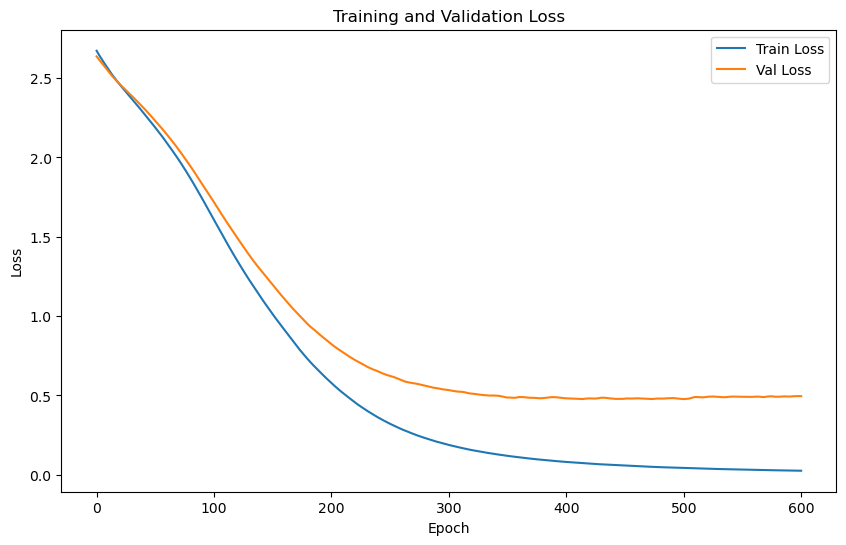

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.4923 | Test Accuracy: 84.50%


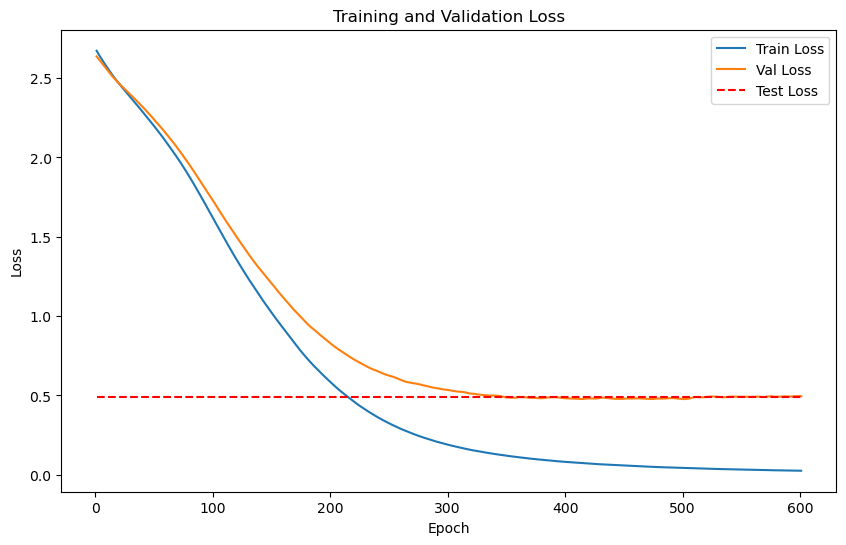

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


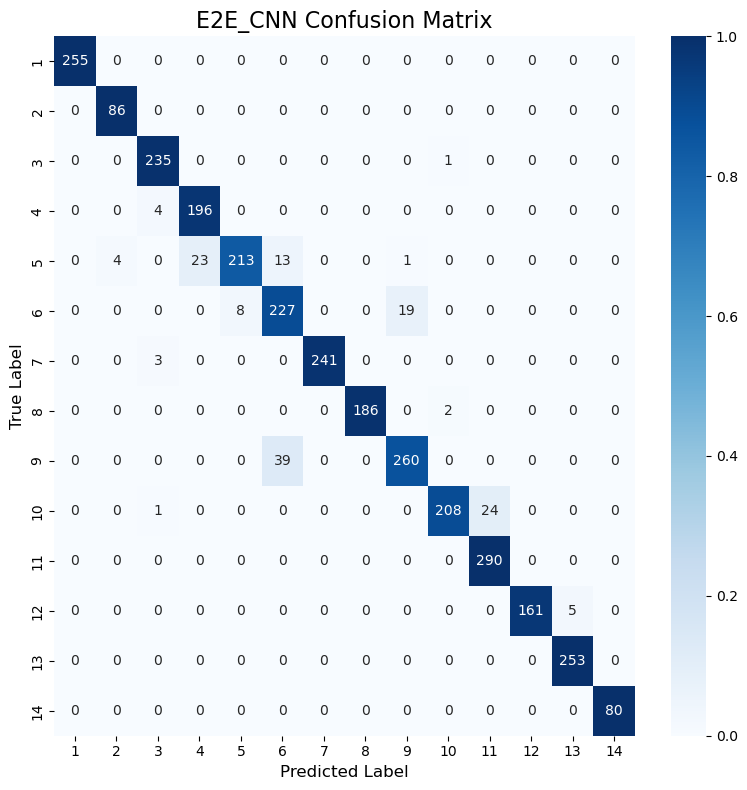

Classification Accuracy: 95.16%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


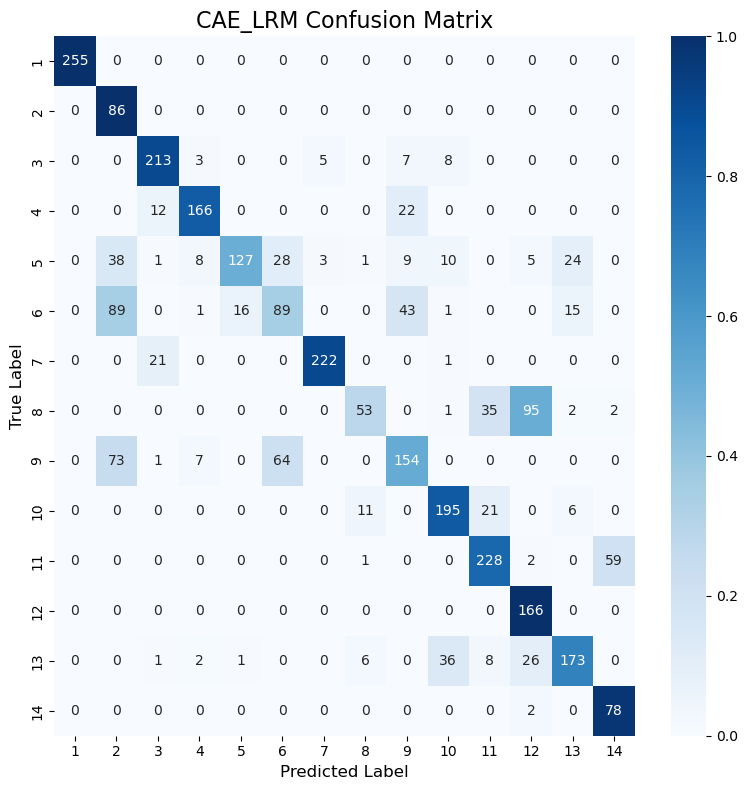

Classification Accuracy: 72.58%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


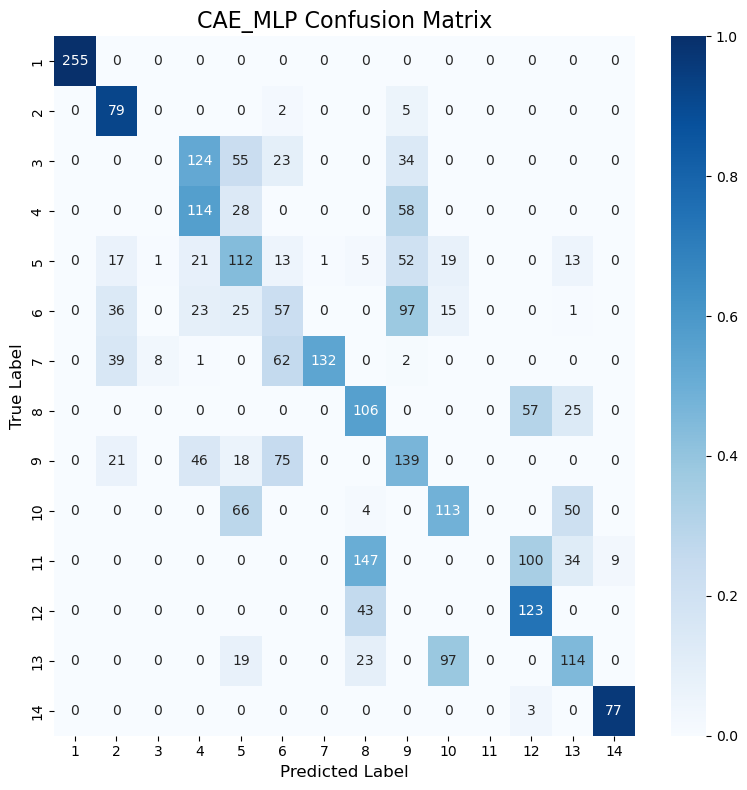

Classification Accuracy: 46.77%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


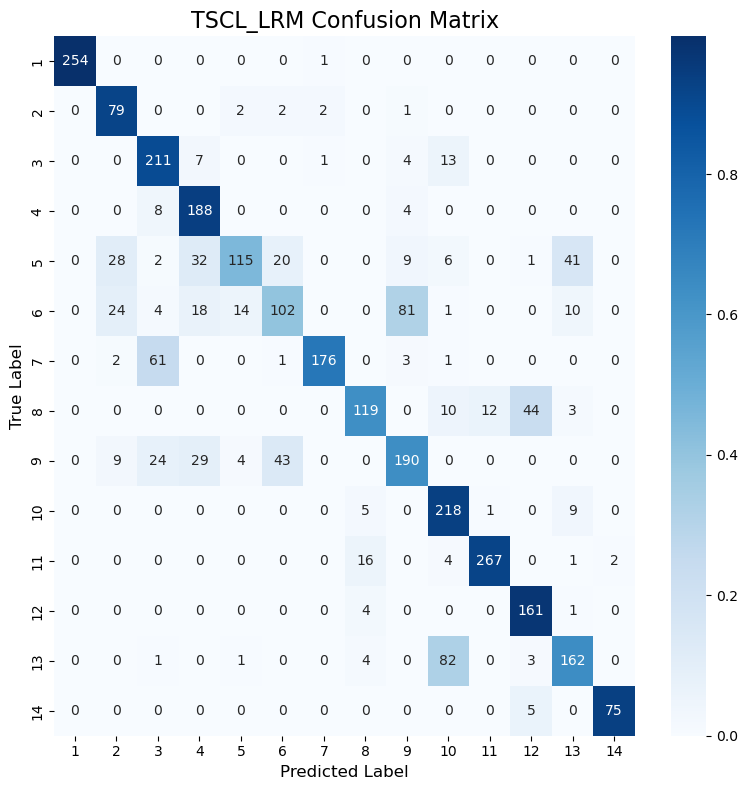

Classification Accuracy: 76.27%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


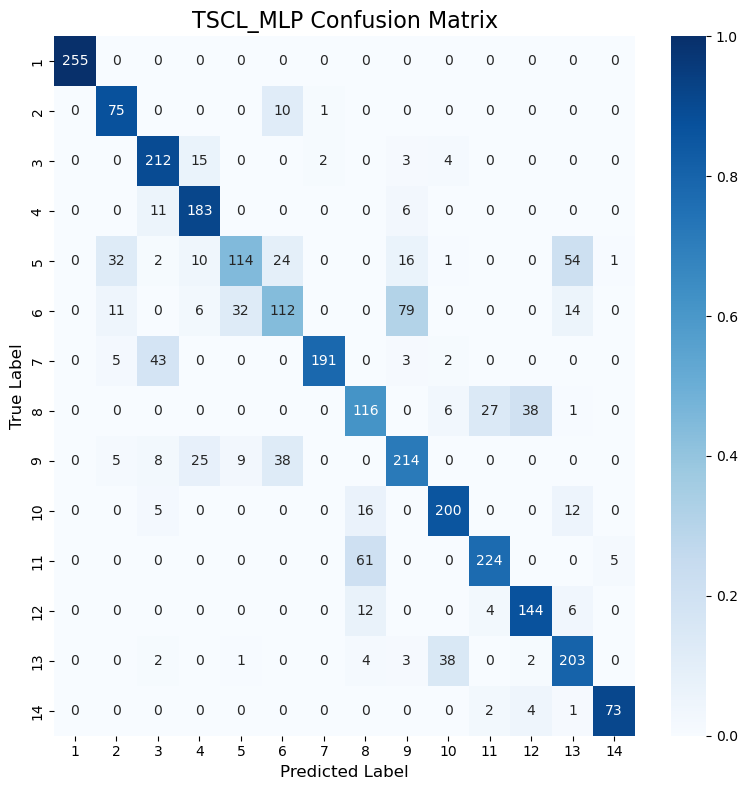

Classification Accuracy: 76.23%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


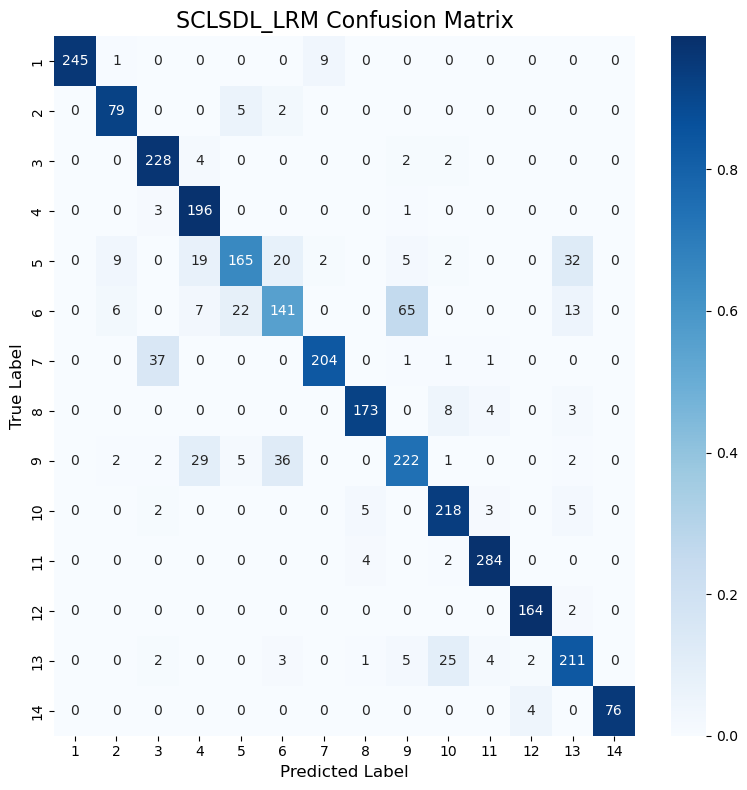

Classification Accuracy: 85.78%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


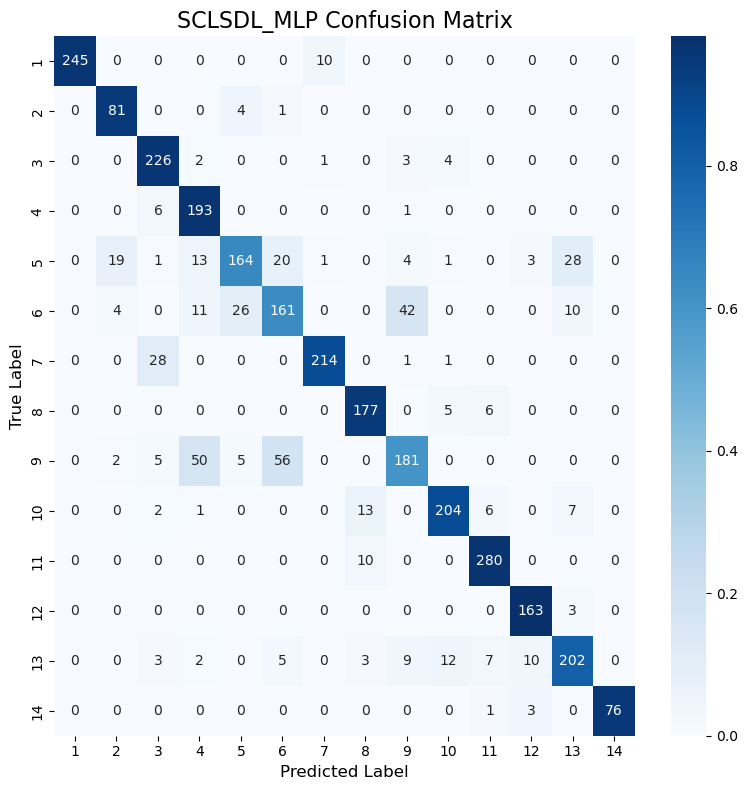

Classification Accuracy: 84.50%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          95.16
1    LRM (CAE)          72.58
2    MLP (CAE)          46.77
3     TSCL LRM          76.27
4     TSCL MLP          76.23
5  SCL_SDL LRM          85.78
6  SCL_SDL MLP          84.50

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          95.16
5  SCL_SDL LRM          85.78
6  SCL_SDL MLP          84.50
3     TSCL LRM          76.27
4     TSCL MLP          76.23
1    LRM (CAE)          72.58
2    MLP (CAE)          46.77
